# MNIST train

This is a part of some experiments for Knowledge Distillation.

- Train an MNIST model
- Train a smaller model (trainee) using Knowledge distillation
    - Find optimal parameter configs
- Compare with other training strategies
    - Train the smaller model from scratch
    - Train the smaller model from the trainee model's weights - does it diverge?
- Relevant metrics
    - Precision, recall, accuracy
    - Time the models

Other experiments to try:
- Other datasets?
- Mixture of experts -> one model somehow? (there'll be multiple soft targets OR mean them..)
- KD wrt different architectures:
    - ResNet -> ResNet?
    - ResNet -> simpler architecture
    - Simpler architecture to ResNet

### Other unrelated ideas

- Training strategies
    - Training techniques and tricks
        - Hard negative mining and how it helps
    - Curriculum learning
    - Annealing learning rates
    - Cyclic learning rates
    - Batch normalization

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

In [3]:
df_train_val = pd.read_csv('data/train.csv')

In [4]:
df_test = pd.read_csv('data/test.csv')

In [5]:
df_train_val.shape, df_test.shape

((42000, 785), (28000, 784))

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

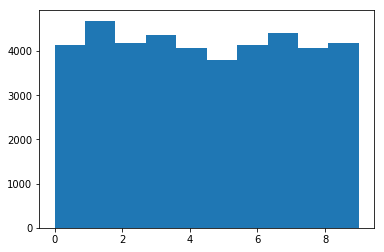

In [6]:
plt.hist(df_train_val.label)

### Split train into train-val

In [7]:
np.random.seed(1123)
df_train_val = df_train_val.sample(frac=1)

In [8]:
df_train_val.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
21290      2       0       0       0       0       0       0       0       0   
19992      8       0       0       0       0       0       0       0       0   
8221       1       0       0       0       0       0       0       0       0   
33538      1       0       0       0       0       0       0       0       0   
15284      7       0       0       0       0       0       0       0       0   

       pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
21290       0    ...            0         0         0         0         0   
19992       0    ...            0         0         0         0         0   
8221        0    ...            0         0         0         0         0   
33538       0    ...            0         0         0         0         0   
15284       0    ...            0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
21290         0         0         0         0         0  
19992         0         0         0         0         0  
8221          0         0         0         0         0  
33538         0         0         0         0         0  
15284         0         0         0         0         0  

[5 rows x 785 columns]

In [9]:
val_frac = 0.1
n_train = math.ceil((1-val_frac) * df_train_val.shape[0])

df_train = df_train_val.iloc[:n_train]
df_val = df_train_val.iloc[n_train:]

assert df_train.shape[0] + df_val.shape[0] == df_train_val.shape[0]

In [10]:
df_train.shape

(37800, 785)

In [11]:
n_train = math.ceil((1-val_frac) * df_train_val.shape[0])

df_train = df_train_val.iloc[:n_train]
df_val = df_train_val.iloc[n_train:]

assert df_train.shape[0] + df_val.shape[0] == df_train_val.shape[0]

In [12]:
df_val.shape

(4200, 785)

### Create dataloaders

In [13]:
from typing import Tuple

In [14]:
from torch.utils.data import dataloader

In [15]:
def get_dataset(df) -> Tuple[np.array, np.array]:
    if 'label' not in df:
        raise ValueError('This dataframe does not have labels!')
    
    # Extract numpy arrays
    labels = df['label'].values
    images = df.drop('label', axis=1).values
    assert len(labels) == len(images)
    
    # Reshape the images to make 28*28
    images = images.reshape(-1, 1, 28, 28)
    
    # Pad to 32*32
    images = np.pad(images, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0)

    # Convert to pytorch Tensors
    images = torch.FloatTensor(images.astype(np.float32))
    labels = torch.LongTensor(labels.astype(np.int))
    
    # Create a dataset object
    dataset = torch.utils.data.TensorDataset(images, labels)
    assert len(dataset) == len(df)
    return dataset

In [16]:
%%time
dataset_train = get_dataset(df_train)
dataset_val = get_dataset(df_val)

CPU times: user 4.76 s, sys: 1.62 s, total: 6.38 s
Wall time: 1.69 s


In [17]:
print(len(dataset_train))
print(len(dataset_val))

37800
4200


In [18]:
batch_size = 8

In [19]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

# Check sizes
for ix, _ in enumerate(dataloader_val):
    pass
assert (ix+1) * batch_size == len(dataset_val)

for ix, _ in enumerate(dataloader_train):
    pass
assert (ix+1) * batch_size == len(dataset_train)

### Visualize a few images

In [20]:
def visualize_batch(batch):
    images, labels = batch
    
    plt.figure(figsize=(20, 10))

    for ix in range(batch_size):
        plt.subplot(1, batch_size, ix+1)
        plt.imshow(images[ix].squeeze(), cmap='gray')
        plt.title(labels[ix].data.numpy())

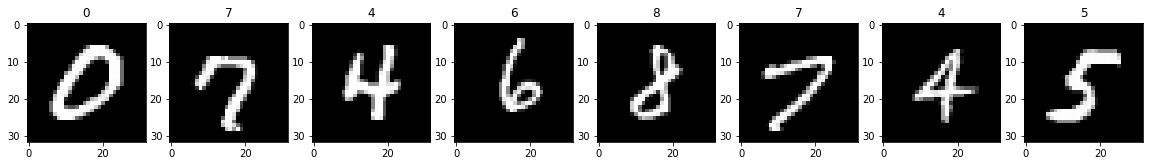

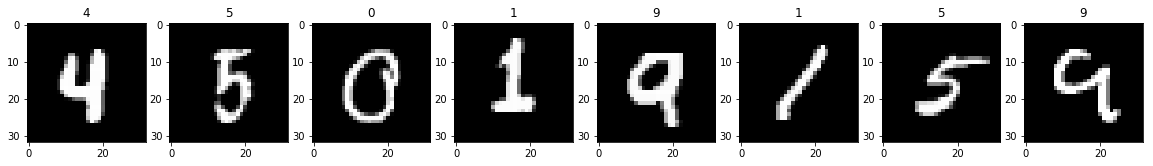

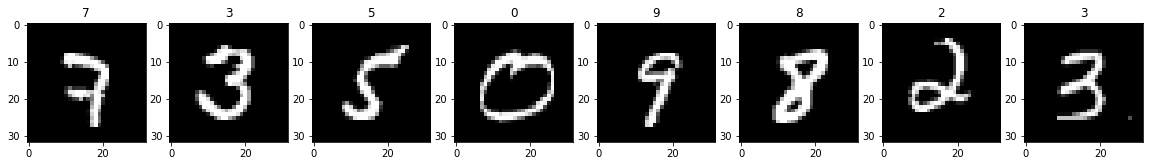

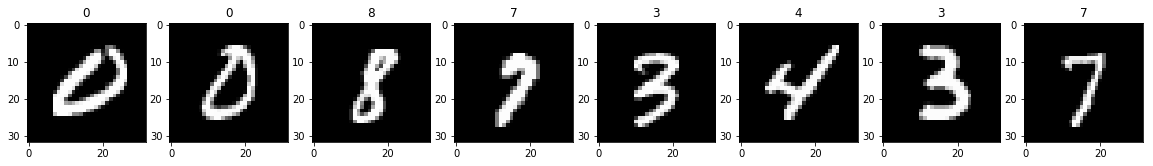

In [21]:
for ix, next_batch in enumerate(dataloader_train):
    if ix >= 4:
        break
    visualize_batch(next_batch)

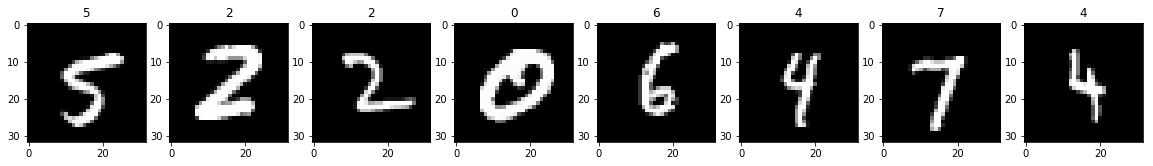

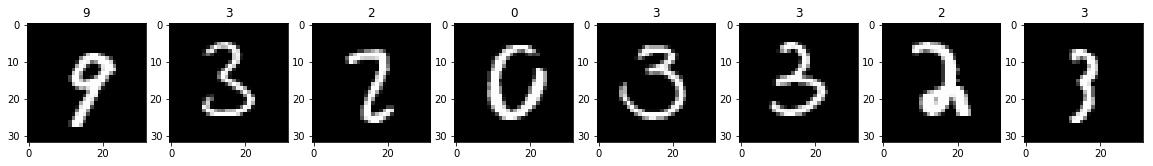

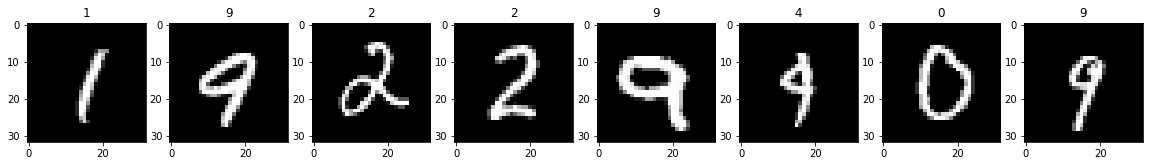

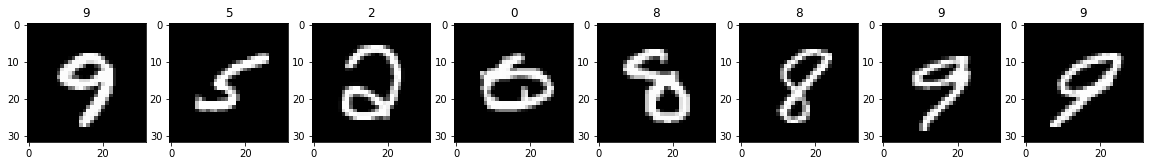

In [22]:
for ix, next_batch in enumerate(dataloader_val):
    if ix >= 4:
        break
    visualize_batch(next_batch)

### Get the relative label weights

In [23]:
loss_weights = np.bincount(df_train_val['label'])

In [24]:
loss_weights = 1. / loss_weights
loss_weights = loss_weights / loss_weights.sum()

Text(0,0.5,'Loss weight')

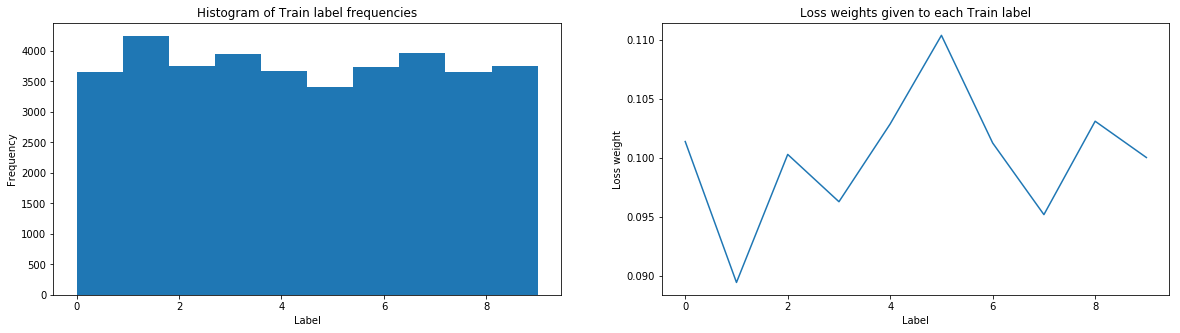

In [25]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(df_train['label'])
plt.title('Histogram of Train label frequencies')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(loss_weights)
plt.title('Loss weights given to each Train label')
plt.xlabel('Label')
plt.ylabel('Loss weight')

In [26]:
del df_train, df_val, df_train_val

## Model

In [27]:
import os
import pathlib
import tensorboardX

In [28]:
len(dataset_val)

4200

In [29]:
def forward_once(model, batch, loss):
    images, labels = batch
    images = images.cuda()
    labels = labels.cuda()
    
    preds = model(images)
    error = loss(preds, labels)
    return preds, error


def validate_model(model, dataloader, loss, n_iters=10, plot=True):
    assert n_iters > 0
    model.train(False)

    total_acc = 0
    total_error = 0
    for iteration, next_batch in enumerate(dataloader):
        preds, error = forward_once(model, next_batch, loss)
        preds = torch.argmax(preds, dim=1).data.cpu().numpy()
        acc = np.mean(preds == next_batch[1].numpy())
        
        total_error += error.data.cpu().numpy()
        total_acc += acc

        if iteration + 1 >= n_iters:
            break

    mean_acc = total_acc / n_iters
    mean_error = total_error / n_iters

    if plot:
        visualize_batch(next_batch)
        print('Preds:', preds)
        plt.show()

    model.train(True)
    
    return mean_error, mean_acc


def train(model, n_epochs=100, val_every=1000, log_every=100):
    """
    NOTE: DEPENDS ON MANY GLOBAL VARIABLES!
    """
    model.train(True)
    epochs = np.arange(n_epochs)

    total_iters = 0
    for epoch in epochs:
        for iteration, next_batch in enumerate(dataloader_train):
            total_iters += 1
            optimizer.zero_grad()
            preds, error = forward_once(model, next_batch, loss)
            error.backward()
            optimizer.step()

            # calculate acc
            preds = torch.argmax(preds, dim=1).data.cpu().numpy()
            acc_train = np.mean(preds == next_batch[1].numpy())

            if iteration % log_every == 0:
                writer.add_scalar('train.loss', error.data.cpu().numpy(), total_iters)
                writer.add_scalar('train.acc', acc_train, total_iters)

            if iteration % val_every == 0:
                err_val, acc_val = validate_model(model, dataloader_val, loss)

                print('Epoch: {}, Iteration: {}'.format(epoch, total_iters))
                print('Loss: {:.4f}, Accuracy: {:.2f}%'.format(err_val, acc_val*100))
                writer.add_scalar('val.loss', err_val, total_iters)
                writer.add_scalar('val.acc', acc_val, total_iters)

        # Save every epoch
        torch.save(model.state_dict(), path_to_weights / '{}.pt'.format(epoch))

### Create a simple model

In [59]:
class Net(nn.Module):
    @staticmethod
    def _make_encoder(n_in, n_out):
        return nn.Sequential(
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(num_features=n_out),
        )

    def __init__(self,) -> None:
        super().__init__()
        self.low_feat = self._make_encoder(1, 4)
        
        self.encoders = nn.Sequential(
            self._make_encoder(4, 4),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(4, 4),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(4, 4),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(4, 4),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        
        self.linears = nn.Sequential(
            nn.Linear(16, 16),
            nn.Linear(16, 16),
        )
        
        self.classifier = nn.Linear(16, 10)
    
    def forward(self, x):
        feats = self.low_feat(x)
        encoded = self.encoders(feats).view(-1, 16)
        preds = self.linears(encoded)
        preds = self.classifier(preds)
        return F.log_softmax(preds, dim=1)

In [60]:
def get_model_and_params(model_cls, gpu=None):
    # Test run!
    model = model_cls()

    img = torch.from_numpy(np.random.rand(1, 1, 32, 32).astype(np.float32))
    assert model(img).shape[1] == 10 and model(img).shape[0] == 1

    count = 0
    params = []
    for param in model.parameters():
        if param.requires_grad:
            count += np.prod(param.shape)
            params.append(param)

    print('{:,} trainable paramaters!'.format(count))
    if gpu is not None:
        model = model.cuda(device=gpu)

    return model, params

### Train

In [61]:
model, params = get_model_and_params(Net, gpu=0)

1,346 trainable paramaters!


In [62]:
loss_weights = torch.FloatTensor(loss_weights)

loss = nn.NLLLoss(weight=loss_weights).cuda()
optimizer = optim.SGD(params, lr=1e-3)

In [64]:
# Weights and logging directories
model_str = 'MNIST-tiny-3.00'

path_to_weights = pathlib.Path('/opt/anuj/weights') / model_str
path_to_log_s = '../tensorboard_logs/{}'.format(model_str)

# To prevent over-writing!
os.makedirs(str(path_to_weights), exist_ok=True)
writer = tensorboardX.SummaryWriter(path_to_log_s)

Preds: [0 0 0 0 0 0 9 0]


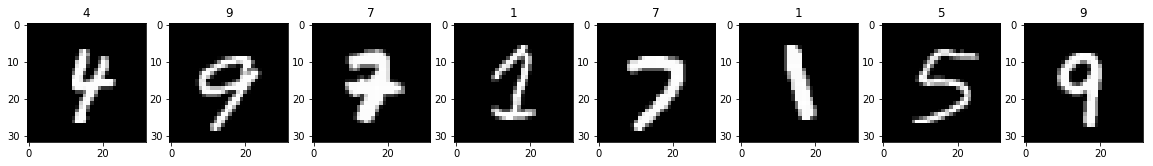

Epoch: 0, Iteration: 1
Loss: 2.2736, Accuracy: 15.00%
Preds: [6 8 1 1 3 0 6 1]


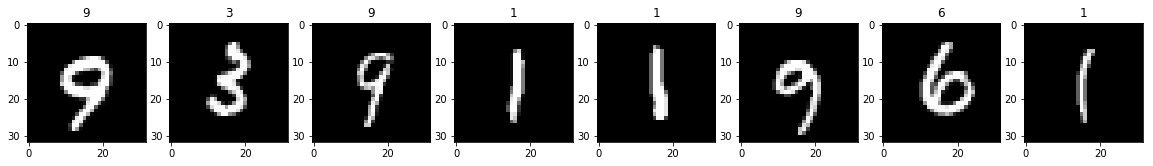

Epoch: 0, Iteration: 1001
Loss: 1.8824, Accuracy: 46.25%
Preds: [6 3 5 8 9 7 0 1]


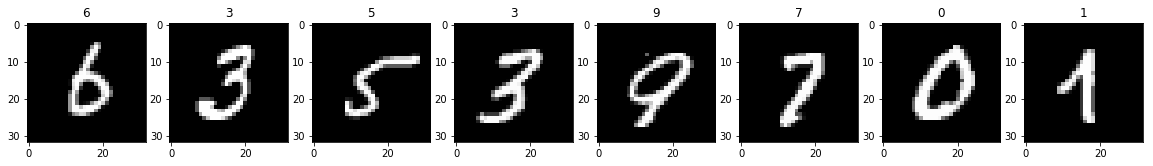

Epoch: 0, Iteration: 2001
Loss: 0.6988, Accuracy: 72.50%
Preds: [6 0 7 4 0 7 0 4]


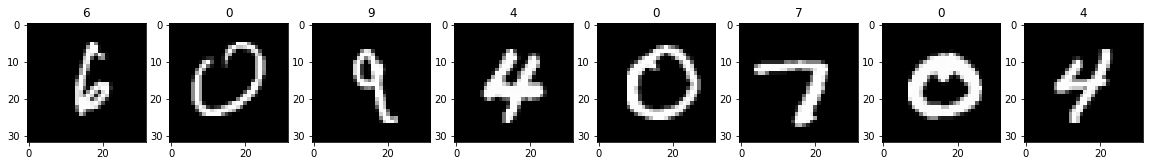

Epoch: 0, Iteration: 3001
Loss: 0.7230, Accuracy: 78.75%
Preds: [7 2 8 5 6 0 2 4]


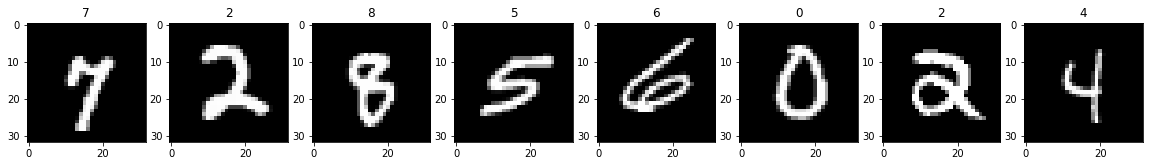

Epoch: 0, Iteration: 4001
Loss: 0.4213, Accuracy: 88.75%
Preds: [1 6 9 5 2 0 1 7]


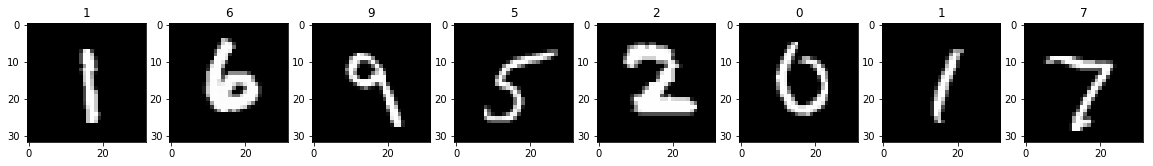

Epoch: 1, Iteration: 4726
Loss: 0.3520, Accuracy: 86.25%
Preds: [5 1 8 6 7 0 1 5]


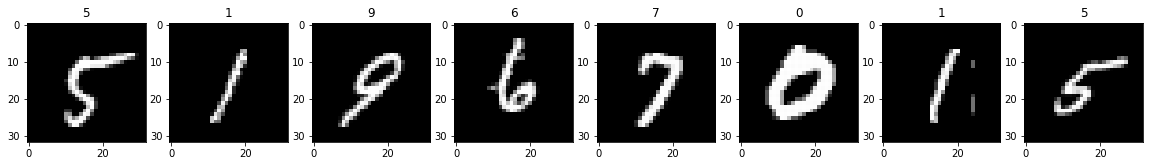

Epoch: 1, Iteration: 5726
Loss: 0.2256, Accuracy: 93.75%
Preds: [5 4 3 7 6 3 7 2]


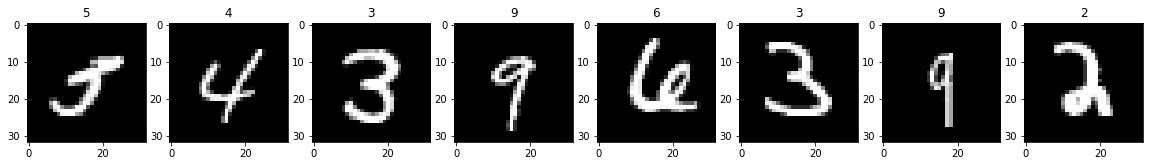

Epoch: 1, Iteration: 6726
Loss: 0.3010, Accuracy: 88.75%
Preds: [3 8 7 4 8 2 8 2]


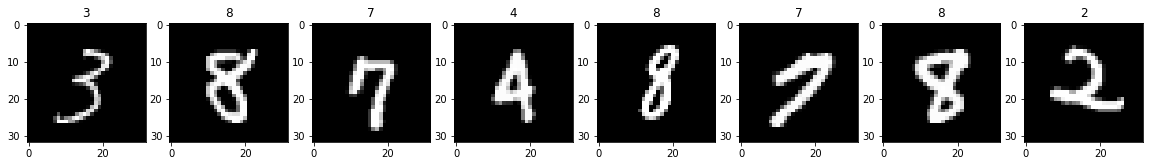

Epoch: 1, Iteration: 7726
Loss: 0.1531, Accuracy: 96.25%
Preds: [3 0 0 0 6 6 5 9]


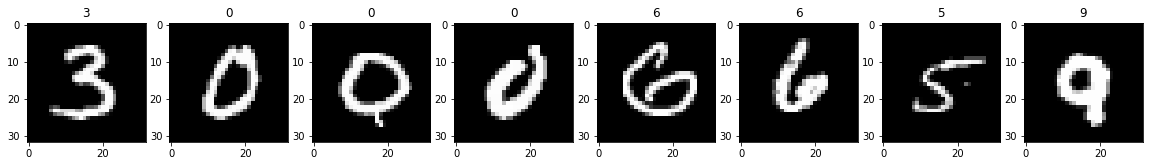

Epoch: 1, Iteration: 8726
Loss: 0.2259, Accuracy: 95.00%
Preds: [8 1 6 4 2 9 6 9]


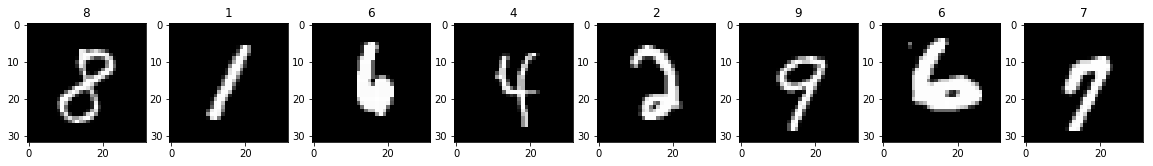

Epoch: 2, Iteration: 9451
Loss: 0.1222, Accuracy: 95.00%
Preds: [8 0 0 4 0 3 5 9]


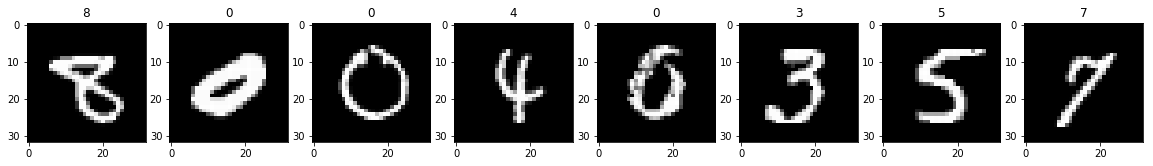

Epoch: 2, Iteration: 10451
Loss: 0.2201, Accuracy: 93.75%
Preds: [0 2 8 1 1 6 1 0]


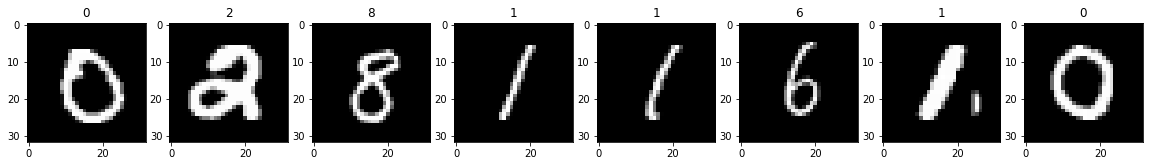

Epoch: 2, Iteration: 11451
Loss: 0.1036, Accuracy: 98.75%
Preds: [3 4 3 8 9 4 1 9]


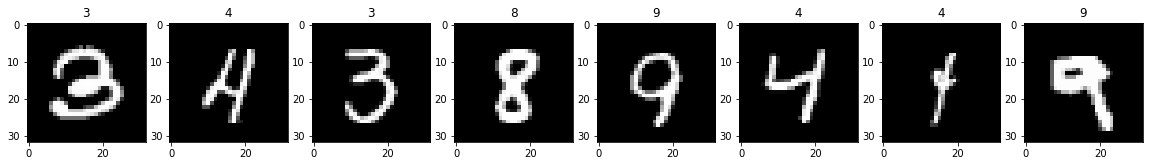

Epoch: 2, Iteration: 12451
Loss: 0.1293, Accuracy: 95.00%
Preds: [9 4 3 8 7 3 1 1]


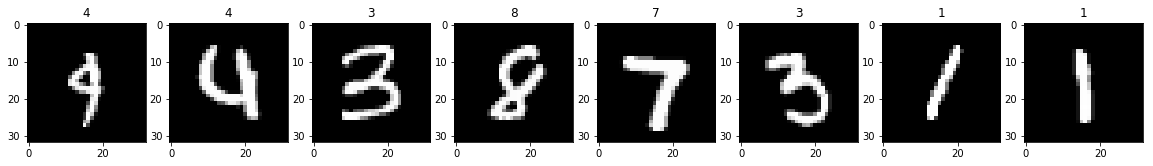

Epoch: 2, Iteration: 13451
Loss: 0.1716, Accuracy: 93.75%
Preds: [3 1 2 1 6 3 0 0]


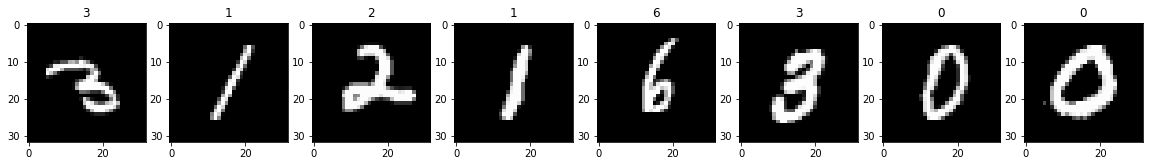

Epoch: 3, Iteration: 14176
Loss: 0.2538, Accuracy: 93.75%
Preds: [7 0 1 4 9 7 5 8]


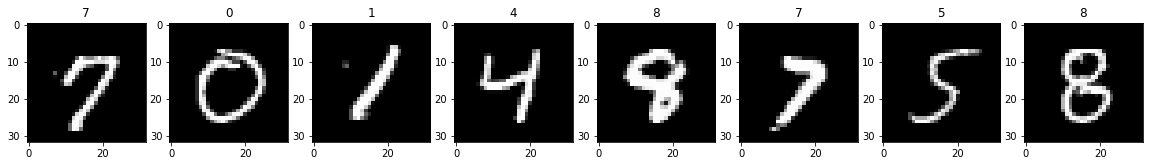

Epoch: 3, Iteration: 15176
Loss: 0.1718, Accuracy: 96.25%
Preds: [0 7 1 4 4 2 2 8]


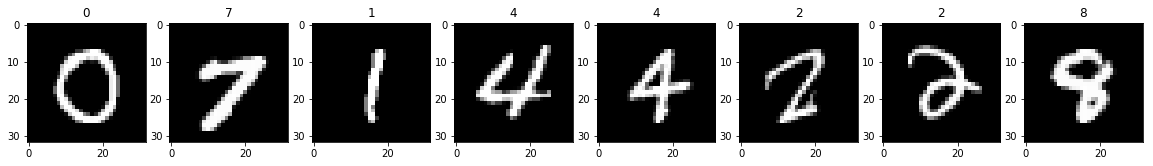

Epoch: 3, Iteration: 16176
Loss: 0.0810, Accuracy: 98.75%
Preds: [0 5 1 3 1 8 5 4]


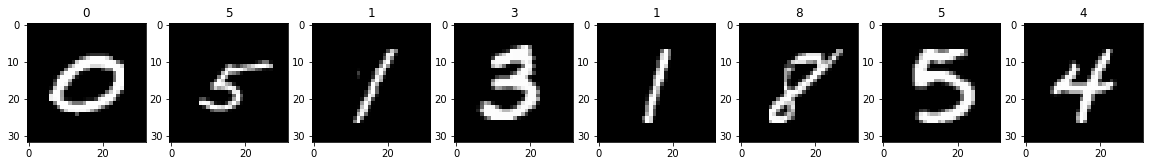

Epoch: 3, Iteration: 17176
Loss: 0.1116, Accuracy: 95.00%
Preds: [0 6 9 7 0 2 3 0]


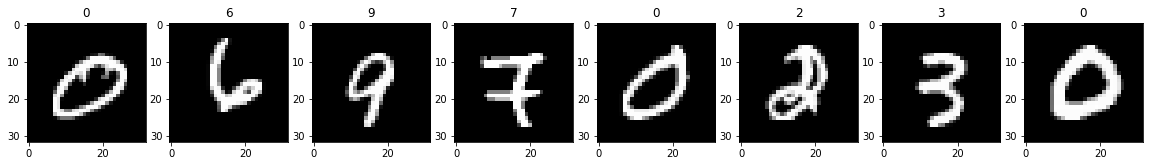

Epoch: 3, Iteration: 18176
Loss: 0.2756, Accuracy: 91.25%
Preds: [2 1 2 0 6 5 9 5]


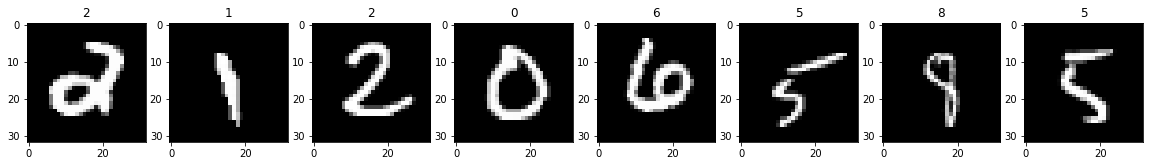

Epoch: 4, Iteration: 18901
Loss: 0.2238, Accuracy: 92.50%
Preds: [9 8 1 5 9 0 8 9]


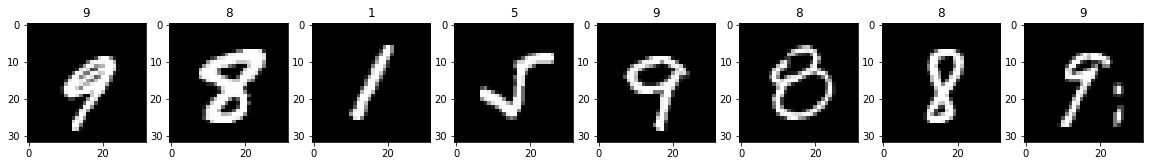

Epoch: 4, Iteration: 19901
Loss: 0.2331, Accuracy: 92.50%
Preds: [2 2 0 0 0 4 0 8]


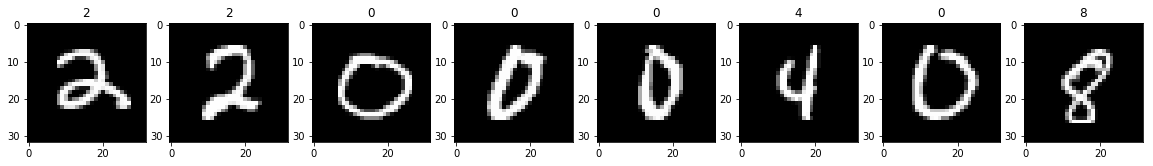

Epoch: 4, Iteration: 20901
Loss: 0.1884, Accuracy: 92.50%
Preds: [2 1 3 6 0 9 8 4]


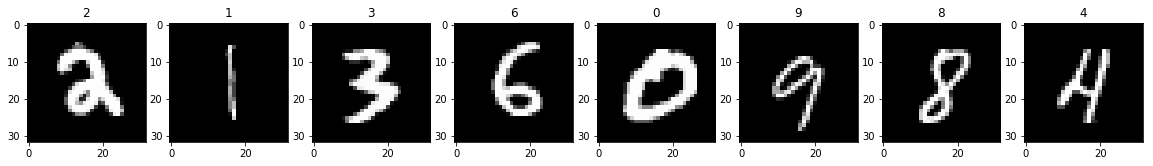

Epoch: 4, Iteration: 21901
Loss: 0.1166, Accuracy: 97.50%
Preds: [9 7 5 1 7 3 5 5]


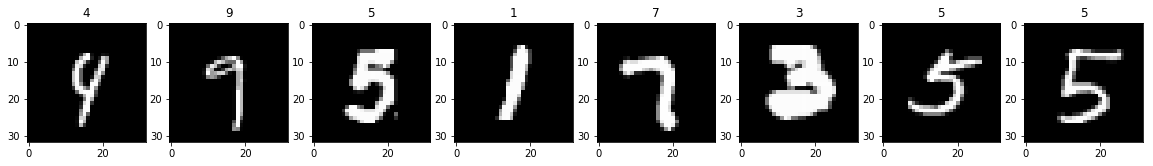

Epoch: 4, Iteration: 22901
Loss: 0.1005, Accuracy: 96.25%
Preds: [4 8 5 0 6 2 7 4]


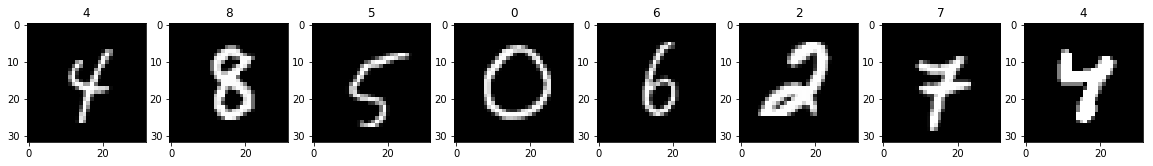

Epoch: 5, Iteration: 23626
Loss: 0.1475, Accuracy: 95.00%
Preds: [3 7 5 6 1 9 7 1]


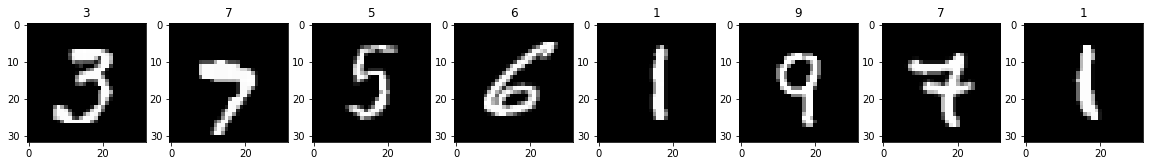

Epoch: 5, Iteration: 24626
Loss: 0.2143, Accuracy: 92.50%
Preds: [6 5 4 0 4 2 5 5]


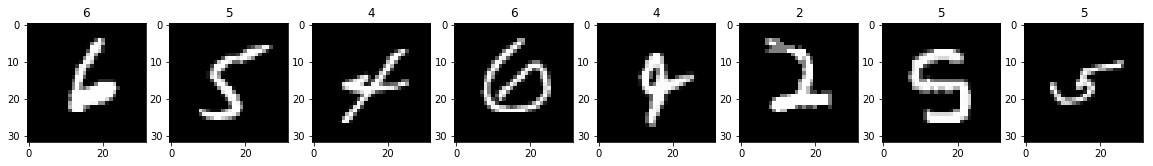

Epoch: 5, Iteration: 25626
Loss: 0.2171, Accuracy: 92.50%
Preds: [3 3 0 2 6 0 7 8]


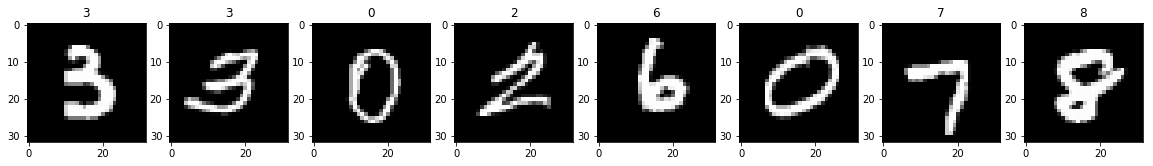

Epoch: 5, Iteration: 26626
Loss: 0.1335, Accuracy: 93.75%
Preds: [9 6 1 6 7 6 2 7]


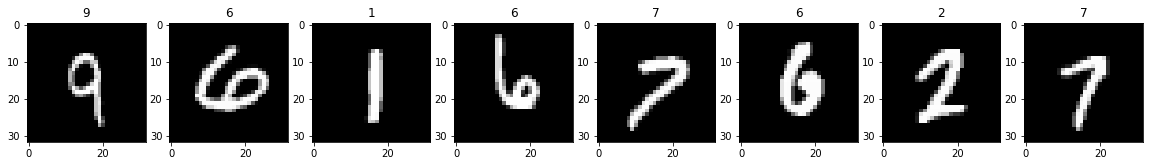

Epoch: 5, Iteration: 27626
Loss: 0.0637, Accuracy: 97.50%
Preds: [3 3 7 1 5 9 9 9]


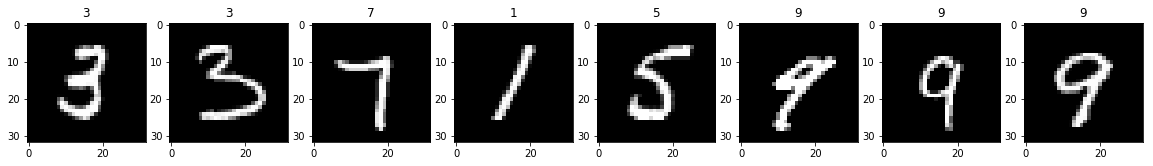

Epoch: 6, Iteration: 28351
Loss: 0.1097, Accuracy: 97.50%
Preds: [9 8 5 2 6 2 0 0]


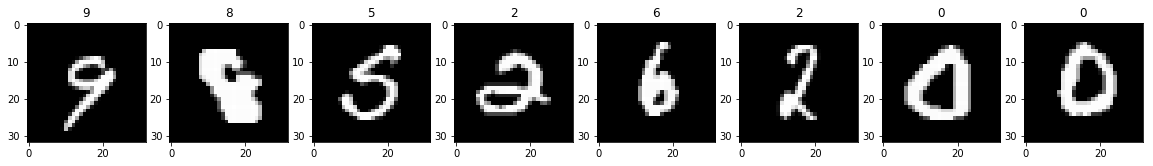

Epoch: 6, Iteration: 29351
Loss: 0.1521, Accuracy: 96.25%
Preds: [6 7 2 8 8 2 3 4]


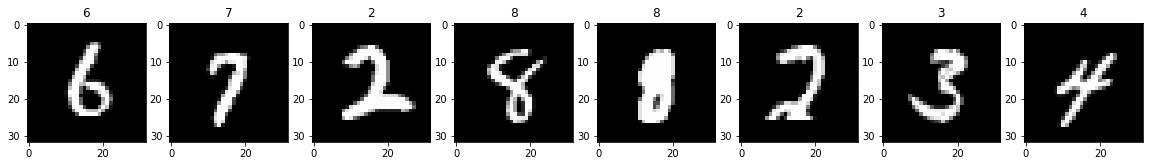

Epoch: 6, Iteration: 30351
Loss: 0.1242, Accuracy: 95.00%
Preds: [0 1 6 2 7 3 6 2]


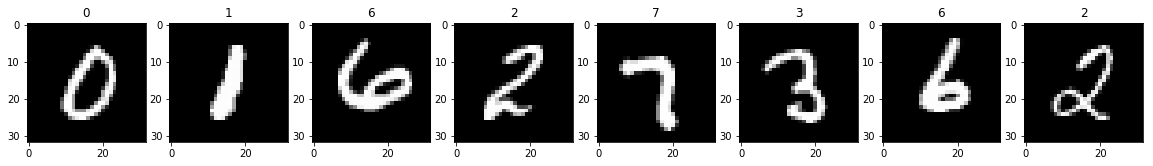

Epoch: 6, Iteration: 31351
Loss: 0.1176, Accuracy: 93.75%
Preds: [3 4 8 4 3 5 4 0]


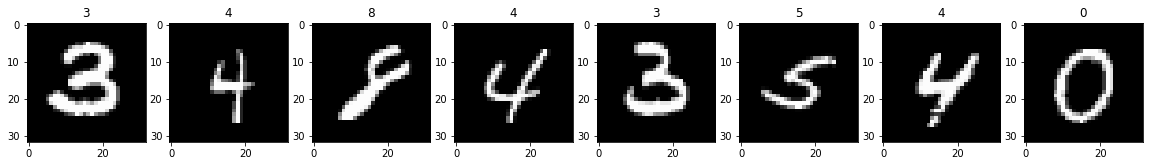

Epoch: 6, Iteration: 32351
Loss: 0.0410, Accuracy: 98.75%
Preds: [6 1 0 7 1 7 4 1]


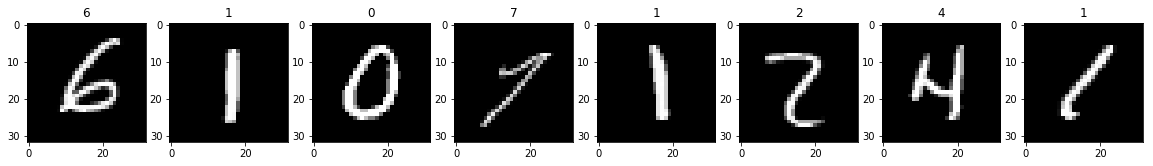

Epoch: 7, Iteration: 33076
Loss: 0.2200, Accuracy: 91.25%
Preds: [7 0 7 8 6 0 9 4]


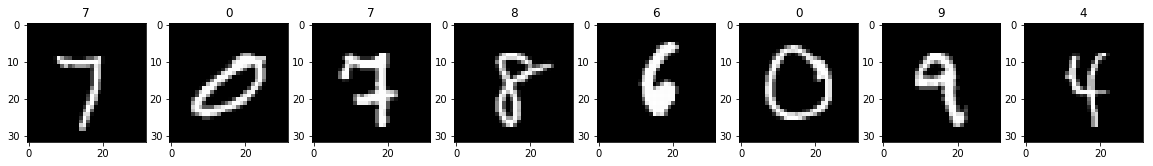

Epoch: 7, Iteration: 34076
Loss: 0.0726, Accuracy: 98.75%
Preds: [1 0 0 1 7 7 9 8]


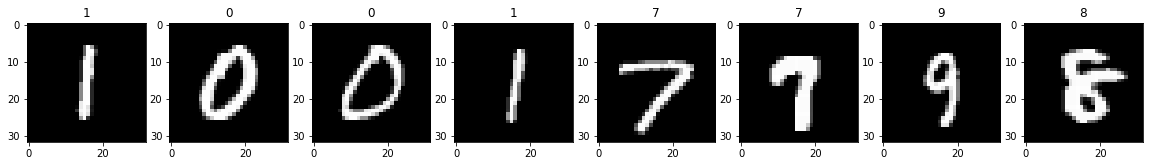

Epoch: 7, Iteration: 35076
Loss: 0.1362, Accuracy: 96.25%
Preds: [1 7 5 5 2 1 5 4]


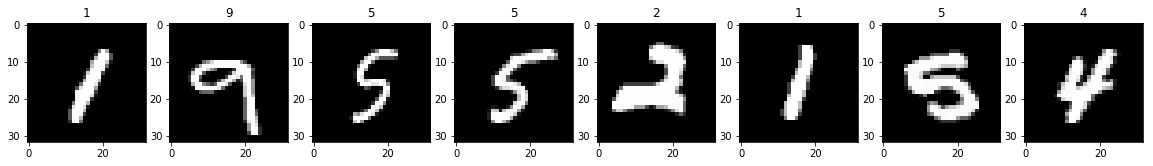

Epoch: 7, Iteration: 36076
Loss: 0.0899, Accuracy: 96.25%
Preds: [5 8 8 6 7 3 2 2]


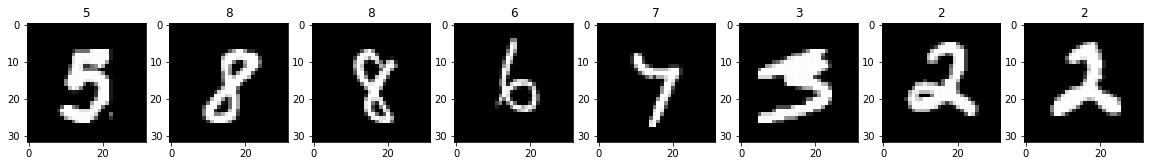

Epoch: 7, Iteration: 37076
Loss: 0.0571, Accuracy: 98.75%
Preds: [9 6 9 8 1 1 8 5]


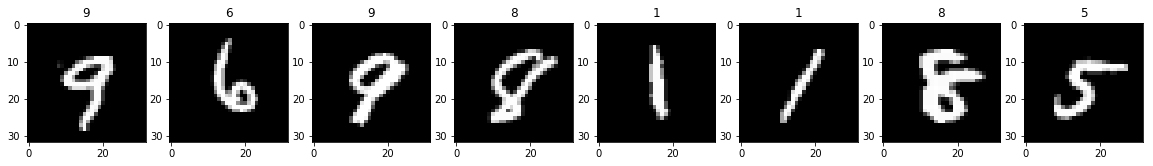

Epoch: 8, Iteration: 37801
Loss: 0.1079, Accuracy: 97.50%
Preds: [0 8 0 6 2 2 6 5]


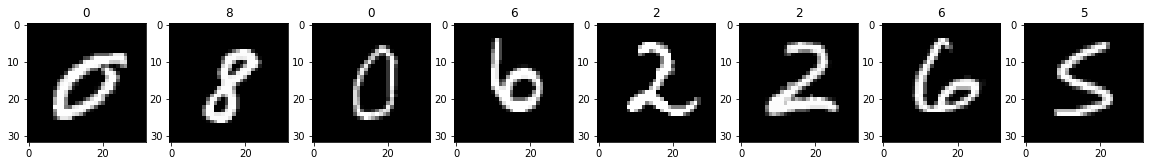

Epoch: 8, Iteration: 38801
Loss: 0.1914, Accuracy: 96.25%
Preds: [1 3 6 3 3 7 8 9]


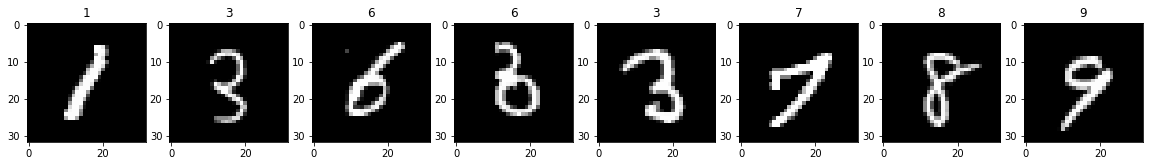

Epoch: 8, Iteration: 39801
Loss: 0.1777, Accuracy: 95.00%
Preds: [3 1 2 2 2 6 6 9]


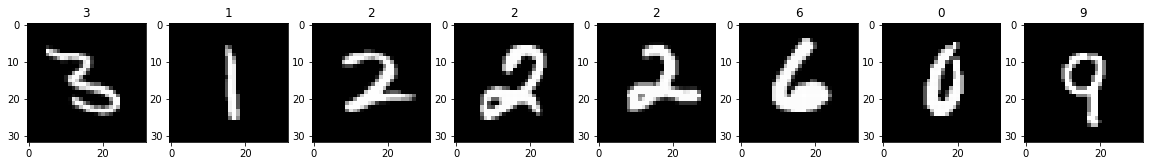

Epoch: 8, Iteration: 40801
Loss: 0.1992, Accuracy: 95.00%
Preds: [5 4 8 4 0 9 9 2]


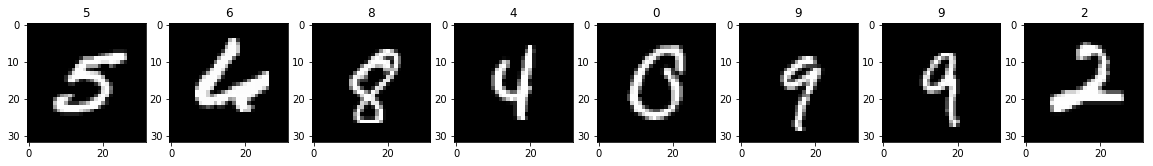

Epoch: 8, Iteration: 41801
Loss: 0.1754, Accuracy: 92.50%
Preds: [7 8 6 8 8 2 3 0]


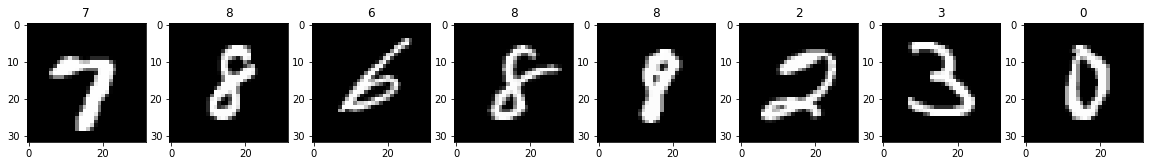

Epoch: 9, Iteration: 42526
Loss: 0.0859, Accuracy: 97.50%
Preds: [7 5 2 7 0 7 2 7]


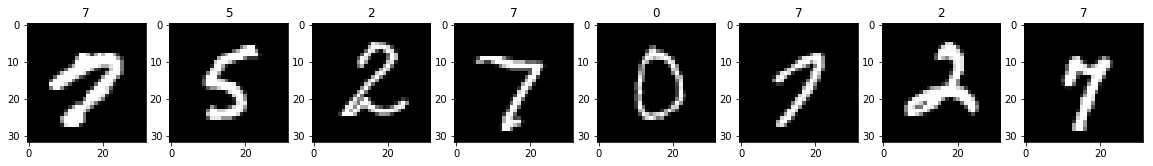

Epoch: 9, Iteration: 43526
Loss: 0.0872, Accuracy: 97.50%
Preds: [8 8 5 0 8 8 4 6]


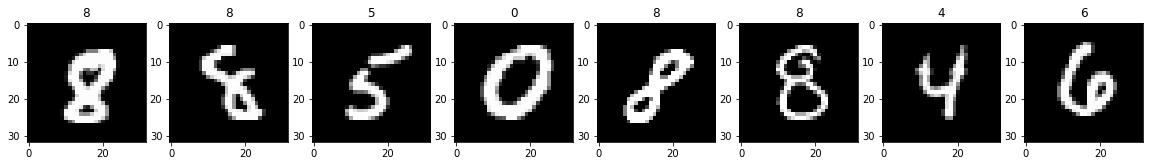

Epoch: 9, Iteration: 44526
Loss: 0.1332, Accuracy: 95.00%
Preds: [5 2 3 2 0 2 0 6]


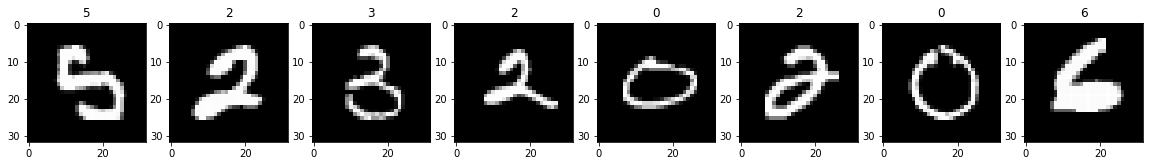

Epoch: 9, Iteration: 45526
Loss: 0.2770, Accuracy: 95.00%
Preds: [7 5 4 7 0 5 4 1]


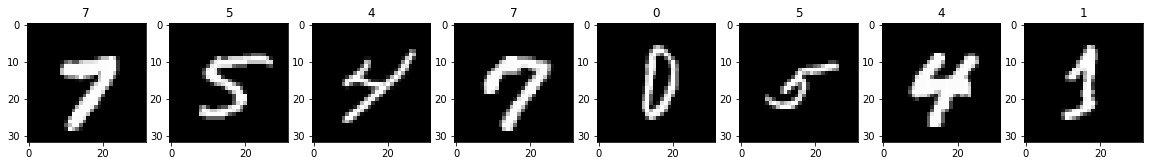

Epoch: 9, Iteration: 46526
Loss: 0.0936, Accuracy: 97.50%
Preds: [8 1 9 0 5 2 4 9]


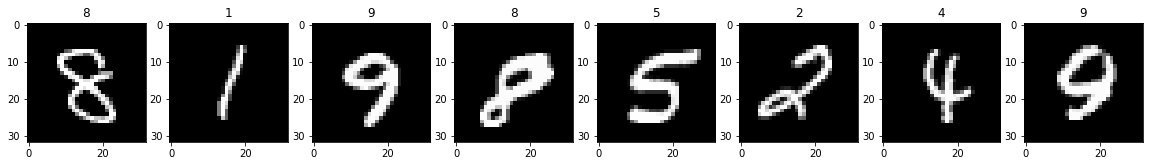

Epoch: 10, Iteration: 47251
Loss: 0.1231, Accuracy: 96.25%
Preds: [0 3 2 2 8 3 0 2]


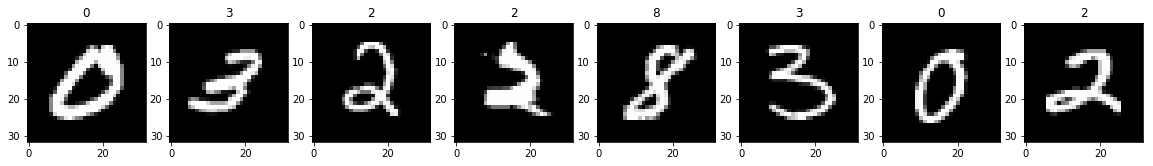

Epoch: 10, Iteration: 48251
Loss: 0.0972, Accuracy: 97.50%
Preds: [7 4 2 0 2 8 4 7]


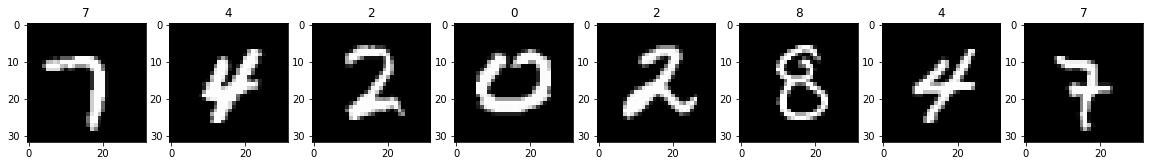

Epoch: 10, Iteration: 49251
Loss: 0.1021, Accuracy: 96.25%
Preds: [8 1 4 9 9 3 6 6]


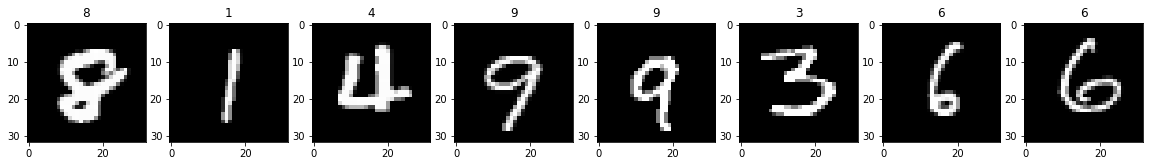

Epoch: 10, Iteration: 50251
Loss: 0.1825, Accuracy: 96.25%
Preds: [6 7 2 8 0 3 1 1]


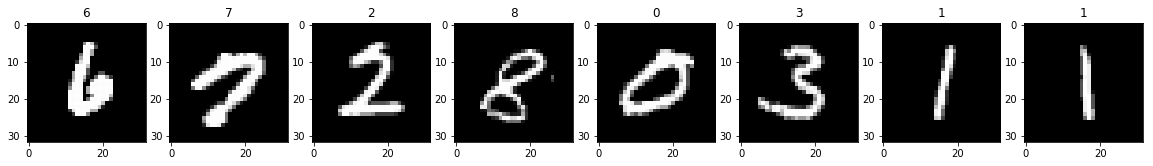

Epoch: 10, Iteration: 51251
Loss: 0.2102, Accuracy: 95.00%
Preds: [9 6 1 0 5 3 6 3]


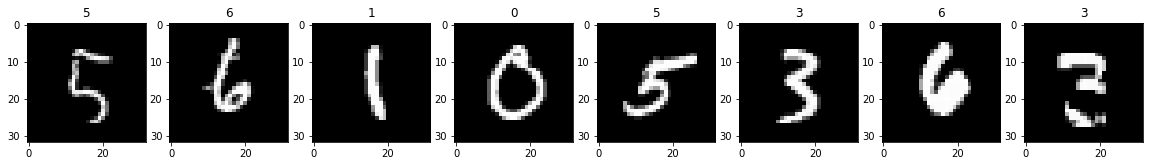

Epoch: 11, Iteration: 51976
Loss: 0.1875, Accuracy: 92.50%
Preds: [1 6 8 9 4 6 4 8]


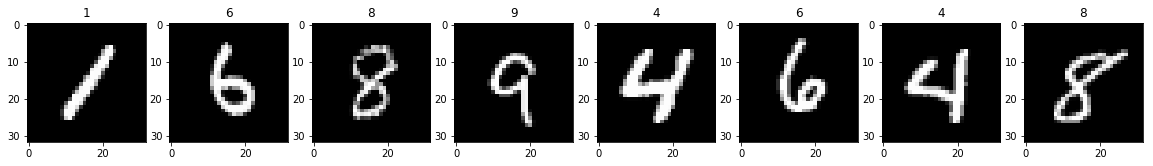

Epoch: 11, Iteration: 52976
Loss: 0.1043, Accuracy: 93.75%
Preds: [3 0 0 7 8 1 7 6]


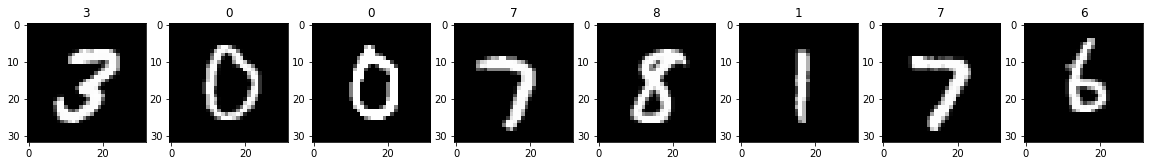

Epoch: 11, Iteration: 53976
Loss: 0.2204, Accuracy: 96.25%
Preds: [3 6 5 0 6 3 1 0]


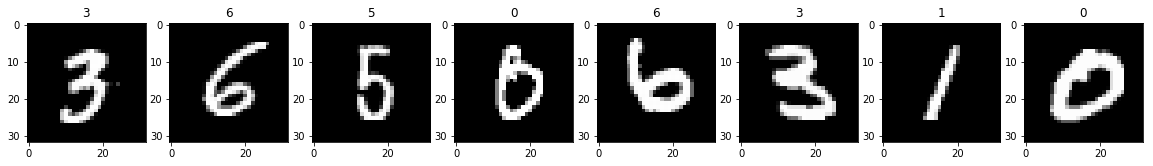

Epoch: 11, Iteration: 54976
Loss: 0.0948, Accuracy: 97.50%
Preds: [7 5 7 7 2 4 5 3]


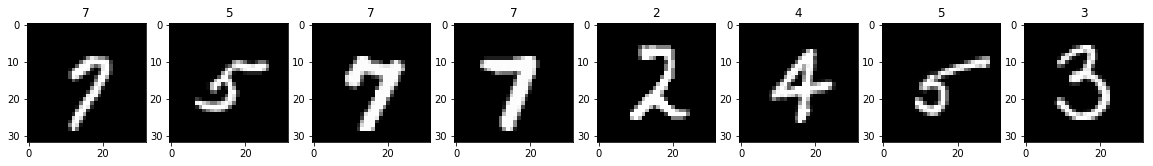

Epoch: 11, Iteration: 55976
Loss: 0.1511, Accuracy: 95.00%
Preds: [1 5 2 3 5 7 4 4]


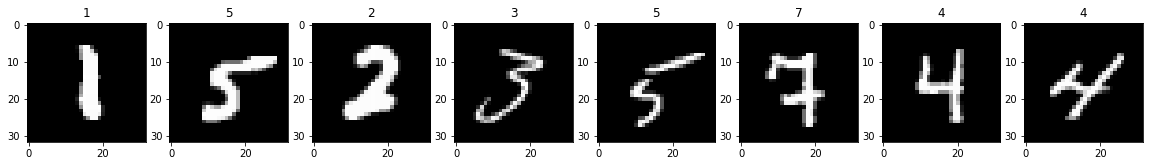

Epoch: 12, Iteration: 56701
Loss: 0.0929, Accuracy: 98.75%
Preds: [4 5 1 7 4 9 8 1]


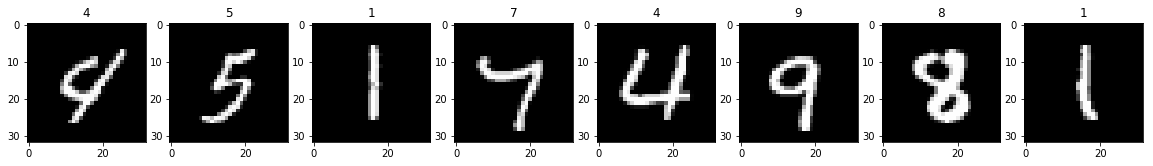

Epoch: 12, Iteration: 57701
Loss: 0.1022, Accuracy: 95.00%
Preds: [5 5 0 1 7 4 1 7]


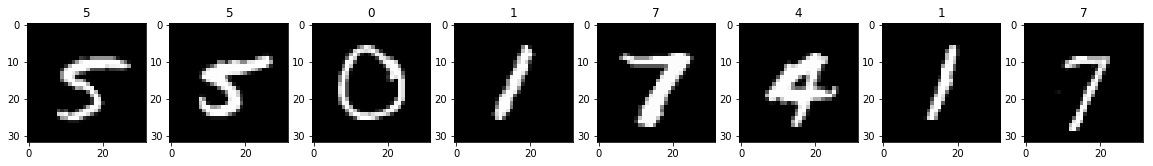

Epoch: 12, Iteration: 58701
Loss: 0.0870, Accuracy: 96.25%
Preds: [9 8 9 8 3 4 2 6]


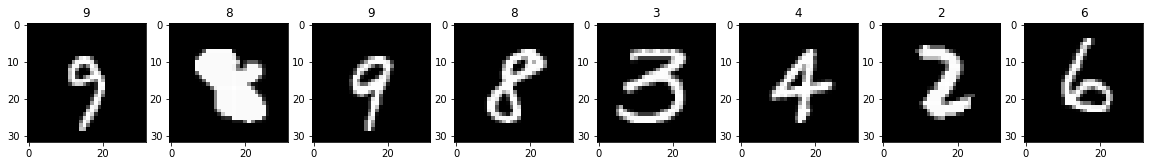

Epoch: 12, Iteration: 59701
Loss: 0.1549, Accuracy: 96.25%
Preds: [1 9 2 1 9 8 2 1]


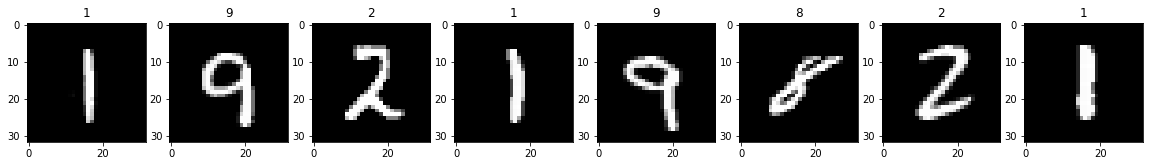

Epoch: 12, Iteration: 60701
Loss: 0.1860, Accuracy: 97.50%
Preds: [2 3 2 8 6 4 0 7]


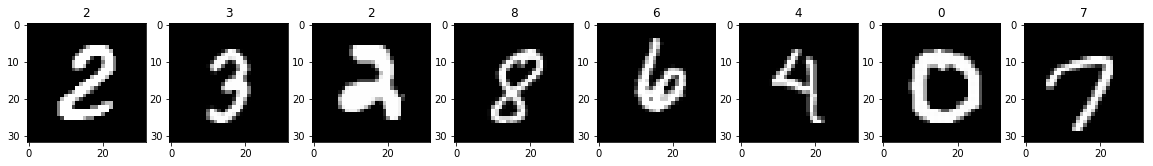

Epoch: 13, Iteration: 61426
Loss: 0.1045, Accuracy: 95.00%
Preds: [9 1 6 2 5 7 4 9]


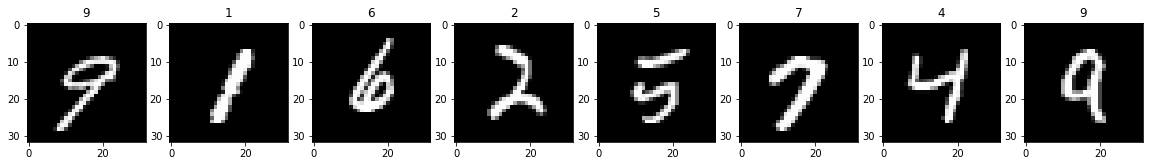

Epoch: 13, Iteration: 62426
Loss: 0.1706, Accuracy: 96.25%
Preds: [6 2 9 7 2 4 8 4]


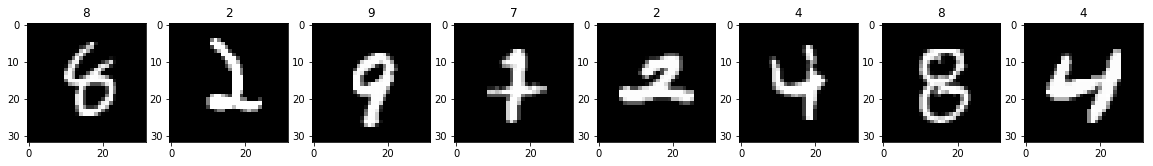

Epoch: 13, Iteration: 63426
Loss: 0.1515, Accuracy: 96.25%
Preds: [2 8 1 9 7 8 6 8]


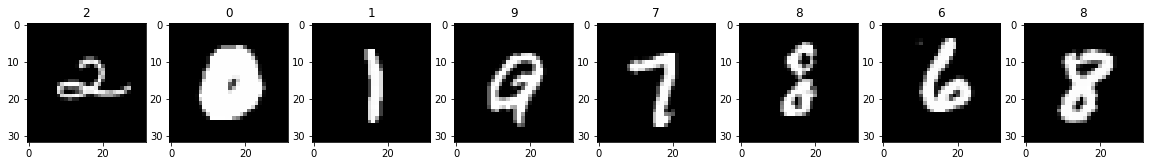

Epoch: 13, Iteration: 64426
Loss: 0.1392, Accuracy: 96.25%
Preds: [2 8 9 2 8 3 5 3]


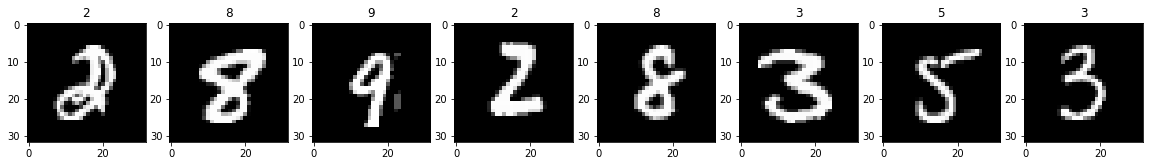

Epoch: 13, Iteration: 65426
Loss: 0.1379, Accuracy: 95.00%
Preds: [1 1 7 2 8 0 1 7]


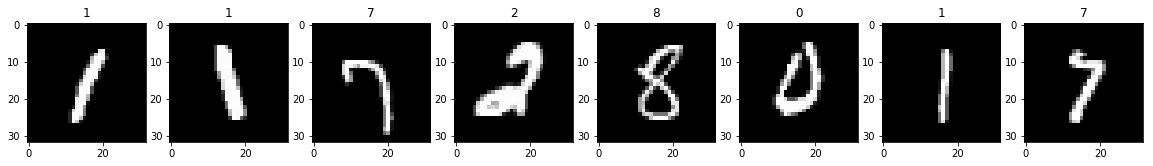

Epoch: 14, Iteration: 66151
Loss: 0.1727, Accuracy: 95.00%
Preds: [3 8 1 4 0 1 6 2]


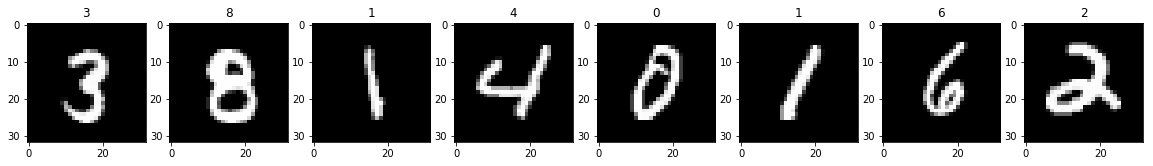

Epoch: 14, Iteration: 67151
Loss: 0.1164, Accuracy: 97.50%
Preds: [1 8 6 8 1 4 4 6]


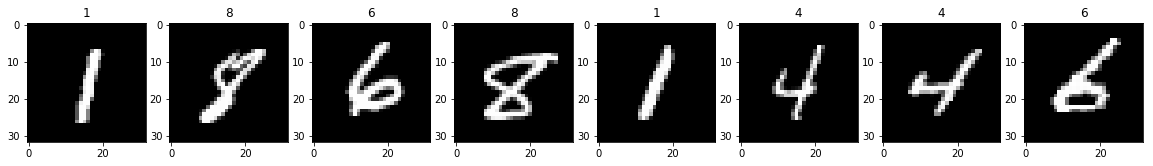

Epoch: 14, Iteration: 68151
Loss: 0.0800, Accuracy: 96.25%
Preds: [3 7 6 9 7 0 0 2]


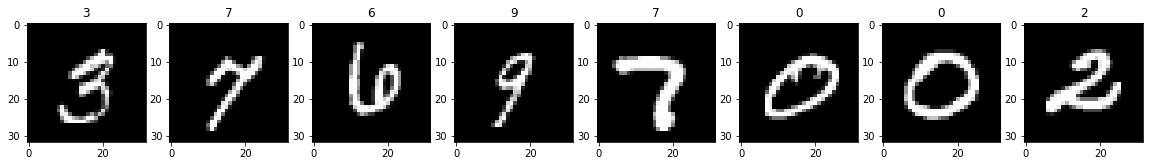

Epoch: 14, Iteration: 69151
Loss: 0.0544, Accuracy: 98.75%
Preds: [5 3 2 2 8 3 1 4]


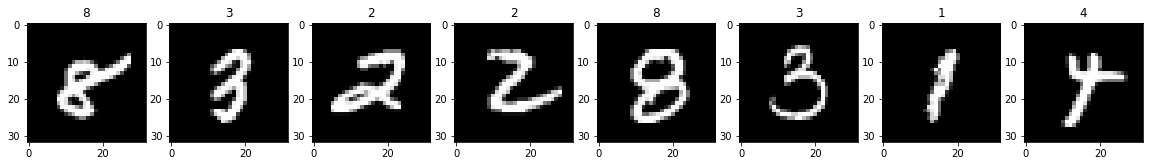

Epoch: 14, Iteration: 70151
Loss: 0.2375, Accuracy: 95.00%
Preds: [8 0 0 6 7 7 1 1]


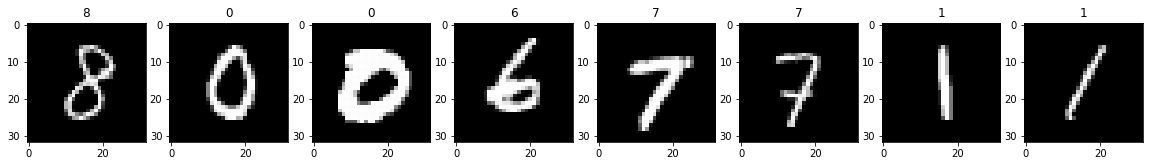

Epoch: 15, Iteration: 70876
Loss: 0.1095, Accuracy: 96.25%
Preds: [6 8 9 0 6 1 7 9]


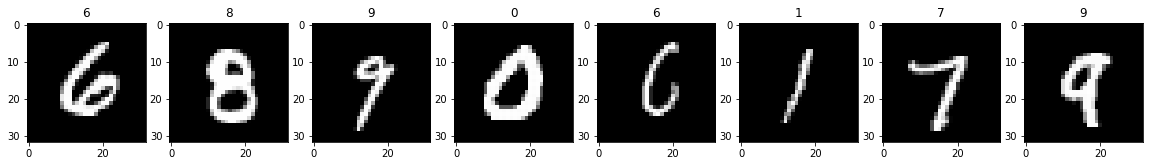

Epoch: 15, Iteration: 71876
Loss: 0.3019, Accuracy: 93.75%
Preds: [9 8 6 2 9 5 7 4]


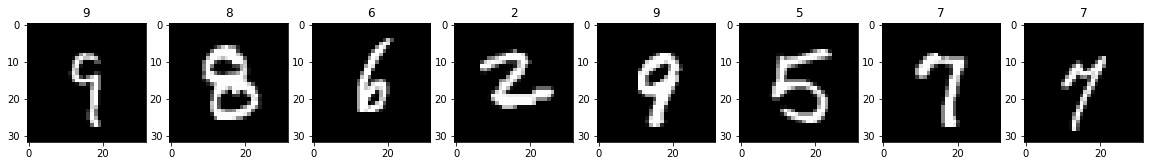

Epoch: 15, Iteration: 72876
Loss: 0.2180, Accuracy: 95.00%
Preds: [6 1 1 9 0 6 5 0]


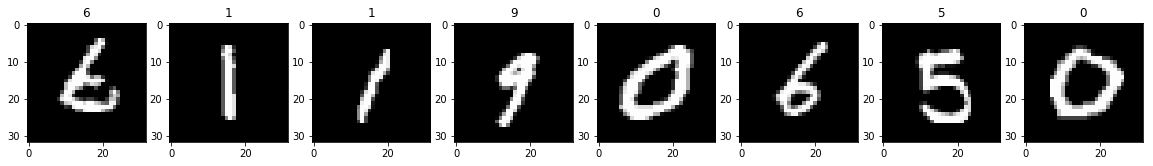

Epoch: 15, Iteration: 73876
Loss: 0.2200, Accuracy: 92.50%
Preds: [2 5 5 6 2 0 7 7]


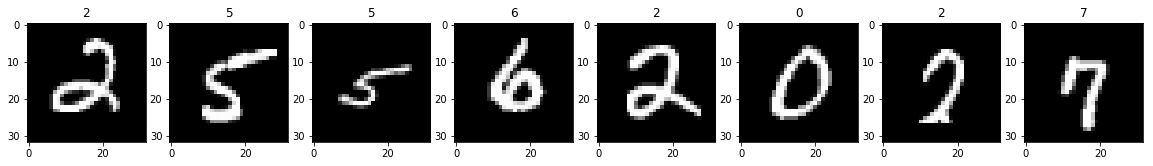

Epoch: 15, Iteration: 74876
Loss: 0.2266, Accuracy: 96.25%
Preds: [1 5 1 3 0 0 3 0]


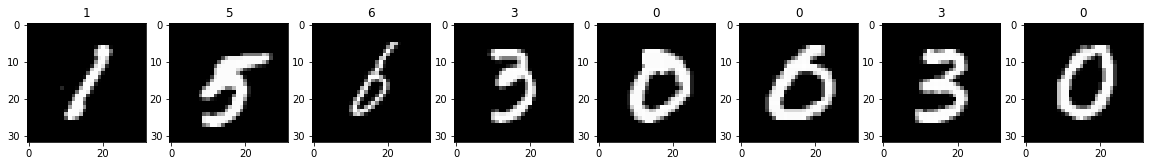

Epoch: 16, Iteration: 75601
Loss: 0.1236, Accuracy: 95.00%
Preds: [3 7 0 9 8 3 0 4]


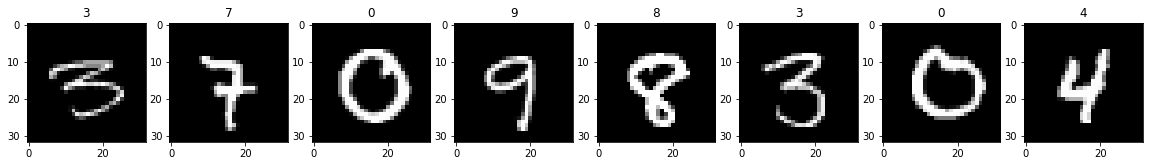

Epoch: 16, Iteration: 76601
Loss: 0.0287, Accuracy: 100.00%
Preds: [4 6 9 9 4 1 4 7]


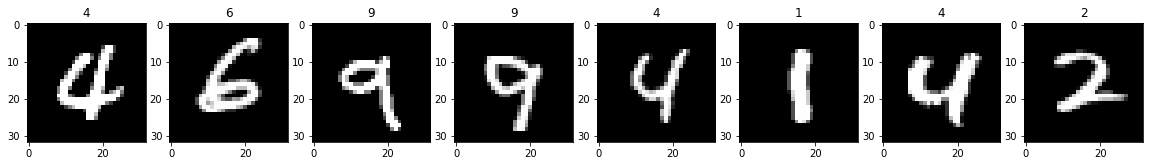

Epoch: 16, Iteration: 77601
Loss: 0.2154, Accuracy: 92.50%
Preds: [2 3 6 1 1 1 1 0]


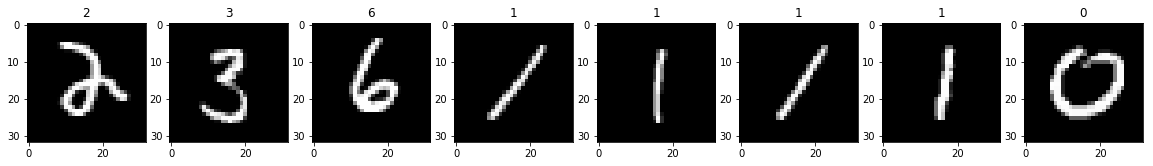

Epoch: 16, Iteration: 78601
Loss: 0.1070, Accuracy: 95.00%
Preds: [4 9 0 8 6 5 6 4]


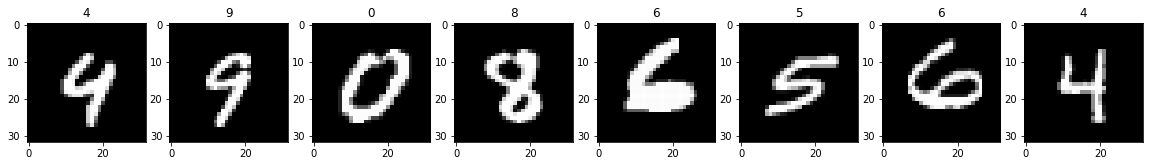

Epoch: 16, Iteration: 79601
Loss: 0.0784, Accuracy: 97.50%
Preds: [4 4 3 6 1 2 8 7]


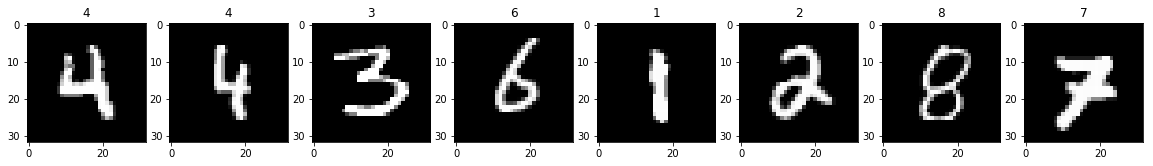

Epoch: 17, Iteration: 80326
Loss: 0.0934, Accuracy: 97.50%
Preds: [0 4 9 9 6 3 8 3]


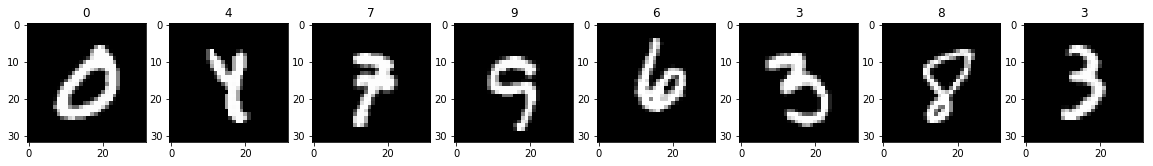

Epoch: 17, Iteration: 81326
Loss: 0.2238, Accuracy: 93.75%
Preds: [1 7 2 6 5 7 4 6]


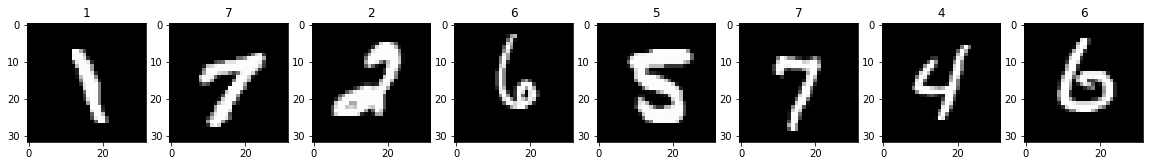

Epoch: 17, Iteration: 82326
Loss: 0.0499, Accuracy: 98.75%
Preds: [8 1 1 3 0 0 5 2]


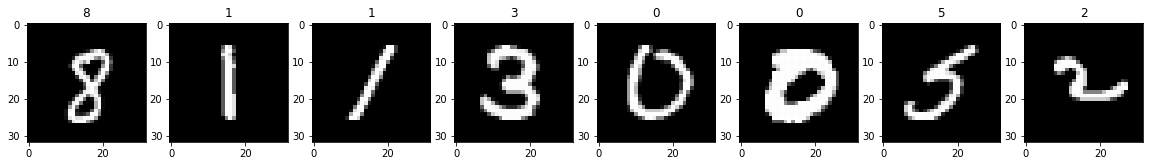

Epoch: 17, Iteration: 83326
Loss: 0.0515, Accuracy: 97.50%
Preds: [8 5 3 5 8 9 1 2]


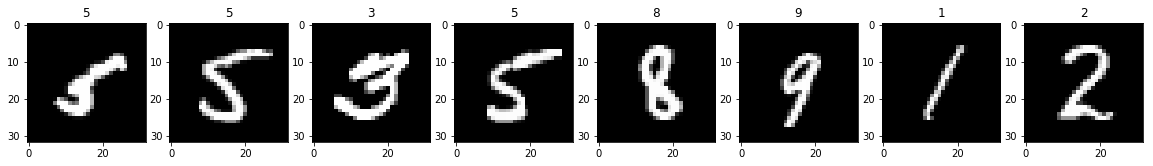

Epoch: 17, Iteration: 84326
Loss: 0.0588, Accuracy: 97.50%
Preds: [7 5 9 1 7 1 6 9]


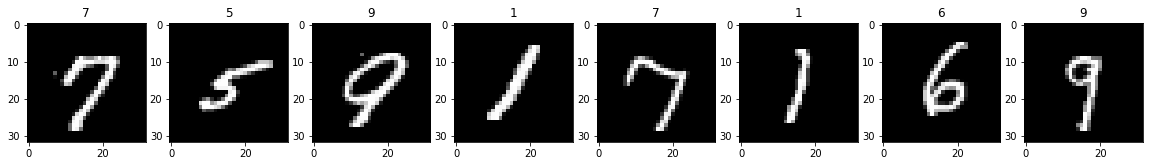

Epoch: 18, Iteration: 85051
Loss: 0.1900, Accuracy: 92.50%
Preds: [9 7 7 2 5 6 9 0]


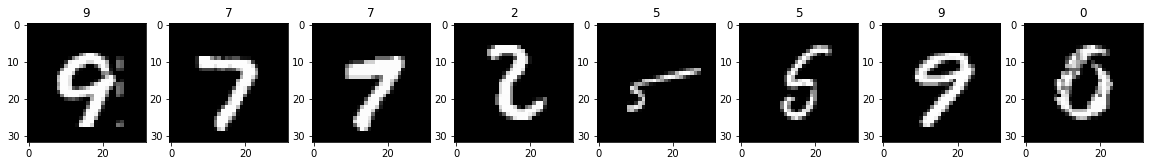

Epoch: 18, Iteration: 86051
Loss: 0.0718, Accuracy: 96.25%
Preds: [0 3 2 5 5 9 9 1]


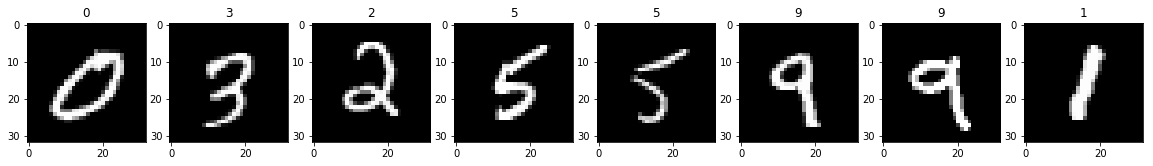

Epoch: 18, Iteration: 87051
Loss: 0.2225, Accuracy: 93.75%
Preds: [6 0 3 8 8 6 3 8]


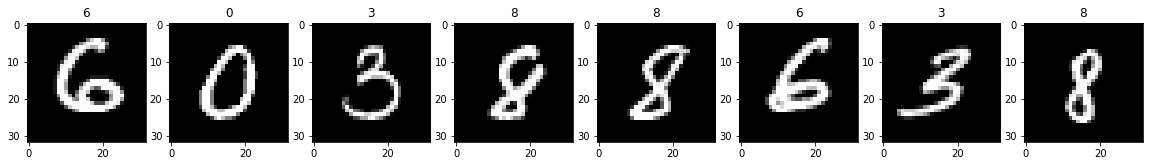

Epoch: 18, Iteration: 88051
Loss: 0.0678, Accuracy: 100.00%
Preds: [1 5 6 5 3 9 0 2]


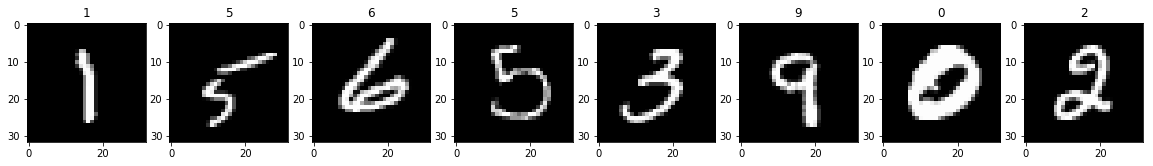

Epoch: 18, Iteration: 89051
Loss: 0.1365, Accuracy: 95.00%
Preds: [1 3 9 9 7 1 1 7]


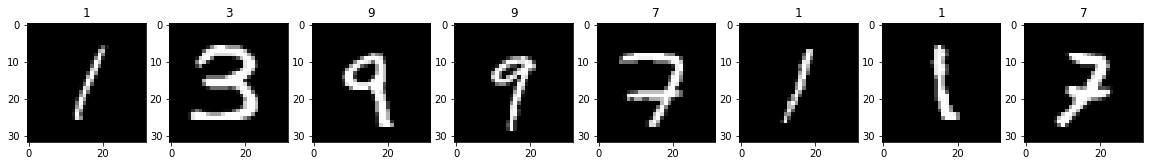

Epoch: 19, Iteration: 89776
Loss: 0.0578, Accuracy: 98.75%
Preds: [1 2 3 0 8 3 8 7]


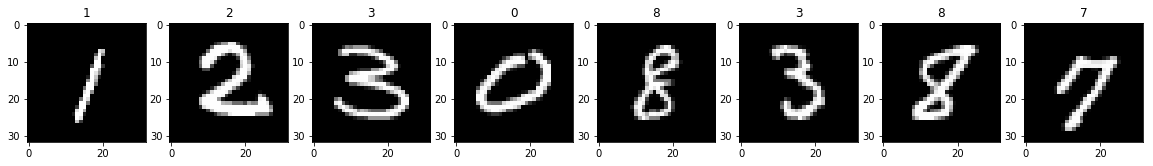

Epoch: 19, Iteration: 90776
Loss: 0.0624, Accuracy: 98.75%
Preds: [3 3 8 7 1 2 6 7]


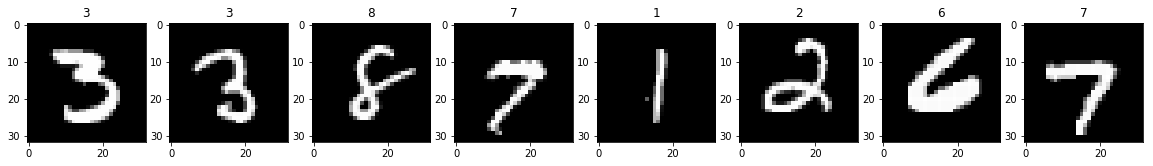

Epoch: 19, Iteration: 91776
Loss: 0.0558, Accuracy: 97.50%
Preds: [3 0 3 1 6 7 3 3]


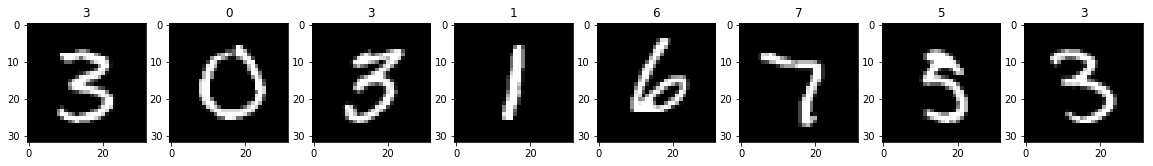

Epoch: 19, Iteration: 92776
Loss: 0.1180, Accuracy: 96.25%
Preds: [0 5 3 0 1 2 0 8]


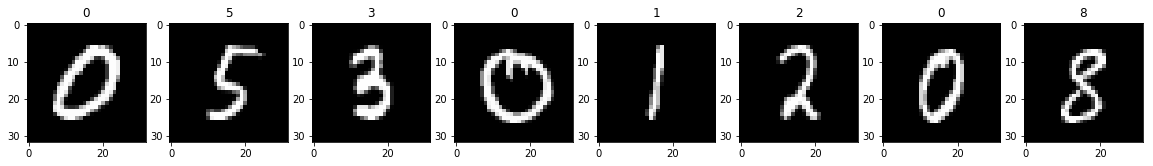

Epoch: 19, Iteration: 93776
Loss: 0.2327, Accuracy: 92.50%
Preds: [5 9 2 0 0 6 9 0]


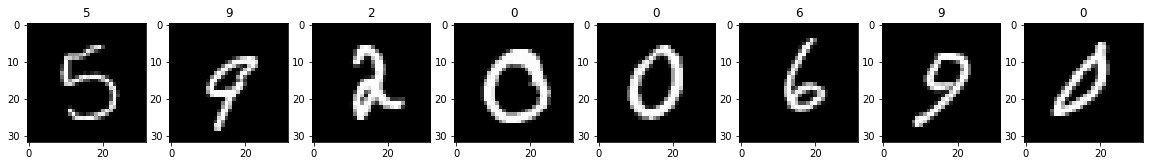

Epoch: 20, Iteration: 94501
Loss: 0.1122, Accuracy: 93.75%
Preds: [2 0 0 6 9 3 5 0]


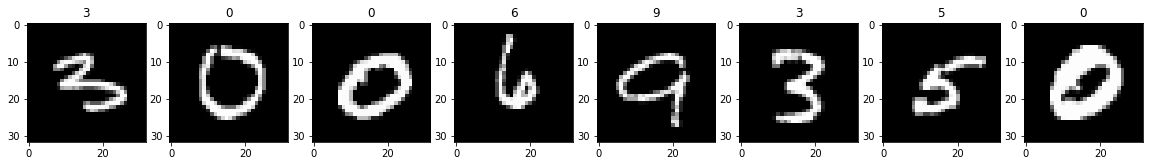

Epoch: 20, Iteration: 95501
Loss: 0.1459, Accuracy: 95.00%
Preds: [4 7 0 0 7 4 2 2]


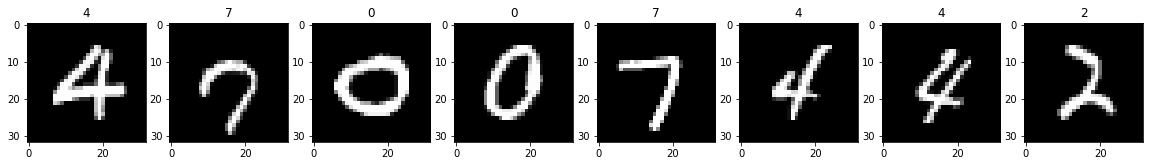

Epoch: 20, Iteration: 96501
Loss: 0.1293, Accuracy: 96.25%
Preds: [6 6 4 8 5 4 4 8]


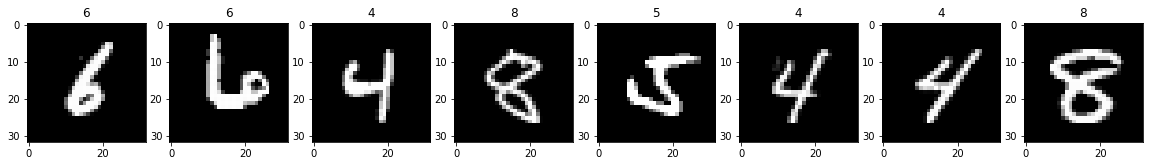

Epoch: 20, Iteration: 97501
Loss: 0.1122, Accuracy: 96.25%
Preds: [8 3 4 2 8 4 8 5]


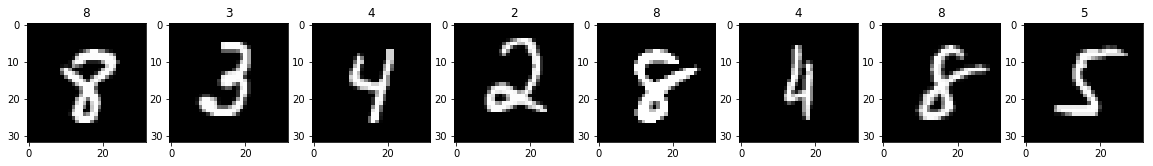

Epoch: 20, Iteration: 98501
Loss: 0.0957, Accuracy: 95.00%
Preds: [4 2 0 1 8 5 6 2]


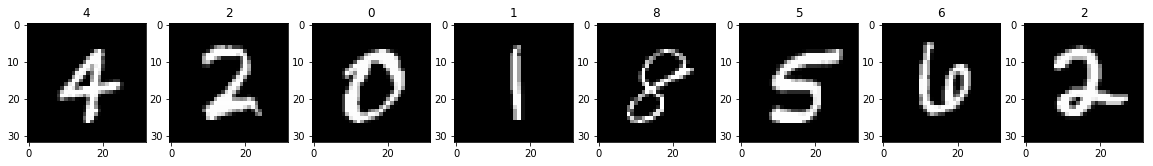

Epoch: 21, Iteration: 99226
Loss: 0.1155, Accuracy: 96.25%
Preds: [4 3 3 7 2 0 4 6]


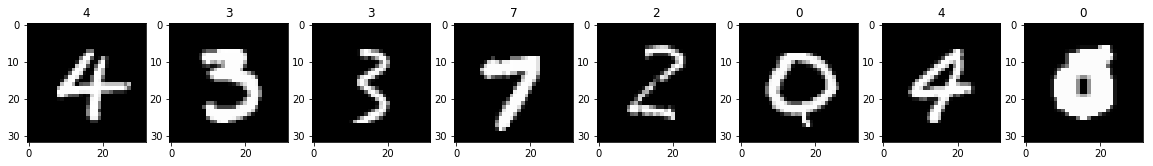

Epoch: 21, Iteration: 100226
Loss: 0.0946, Accuracy: 96.25%
Preds: [7 6 0 3 2 1 7 7]


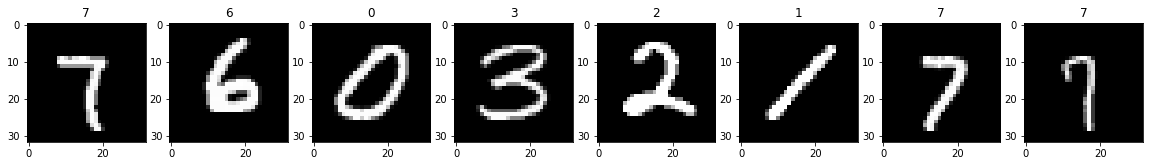

Epoch: 21, Iteration: 101226
Loss: 0.0539, Accuracy: 98.75%
Preds: [9 1 8 8 3 9 4 4]


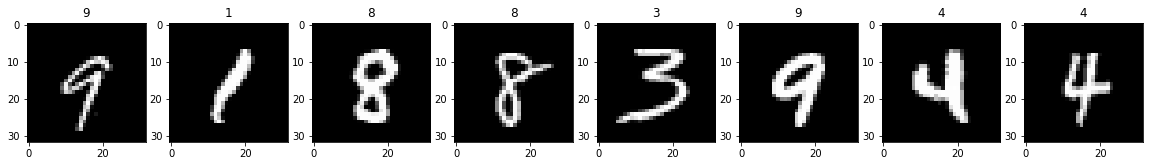

Epoch: 21, Iteration: 102226
Loss: 0.0479, Accuracy: 98.75%
Preds: [8 8 8 9 2 6 8 2]


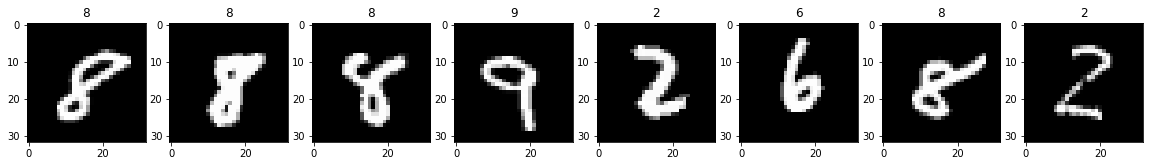

Epoch: 21, Iteration: 103226
Loss: 0.0908, Accuracy: 97.50%
Preds: [5 9 3 0 6 7 4 2]


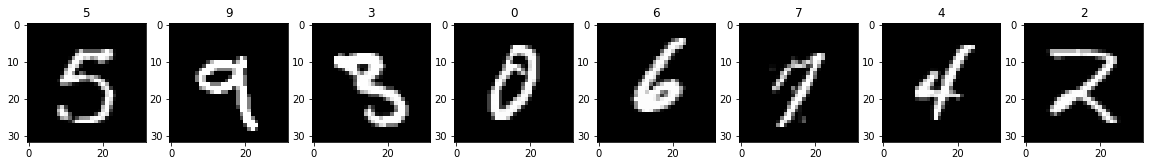

Epoch: 22, Iteration: 103951
Loss: 0.0270, Accuracy: 98.75%
Preds: [6 7 8 9 4 8 5 6]


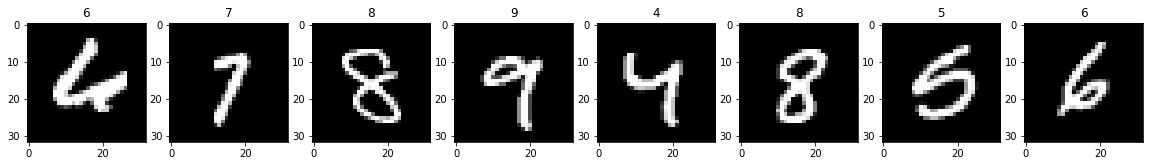

Epoch: 22, Iteration: 104951
Loss: 0.0172, Accuracy: 100.00%
Preds: [0 0 1 2 8 4 1 0]


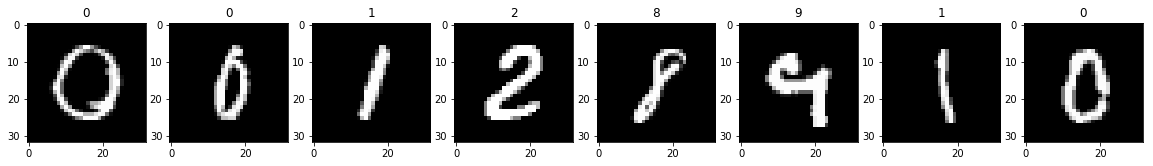

Epoch: 22, Iteration: 105951
Loss: 0.1517, Accuracy: 93.75%
Preds: [5 4 7 1 1 4 8 6]


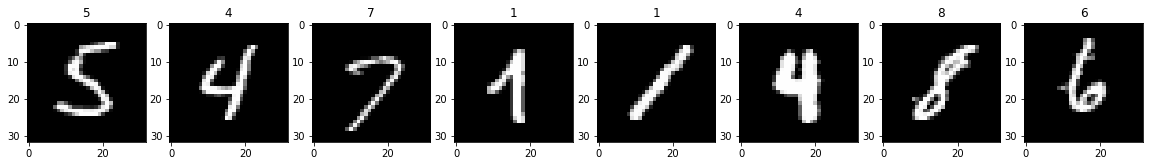

Epoch: 22, Iteration: 106951
Loss: 0.0668, Accuracy: 97.50%
Preds: [4 2 6 9 4 6 6 4]


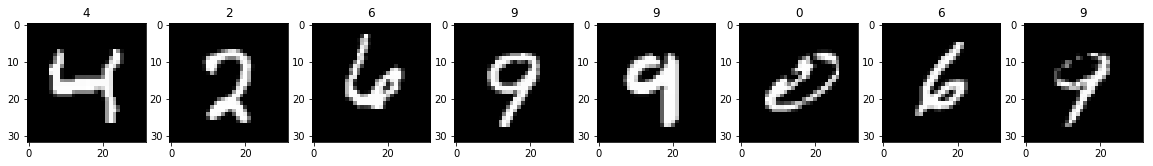

Epoch: 22, Iteration: 107951
Loss: 0.2846, Accuracy: 91.25%
Preds: [4 3 3 4 9 0 6 6]


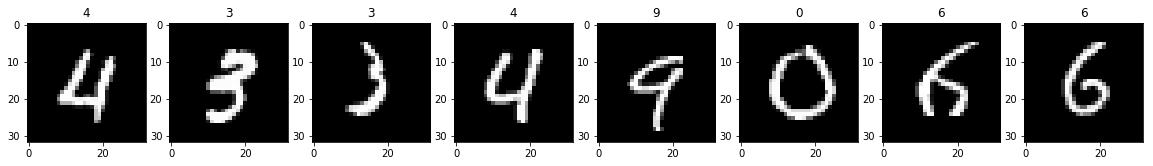

Epoch: 23, Iteration: 108676
Loss: 0.0620, Accuracy: 98.75%
Preds: [4 2 0 2 9 8 8 6]


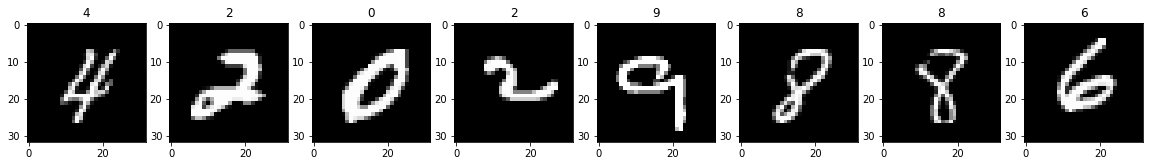

Epoch: 23, Iteration: 109676
Loss: 0.1102, Accuracy: 97.50%
Preds: [5 2 0 0 4 6 8 0]


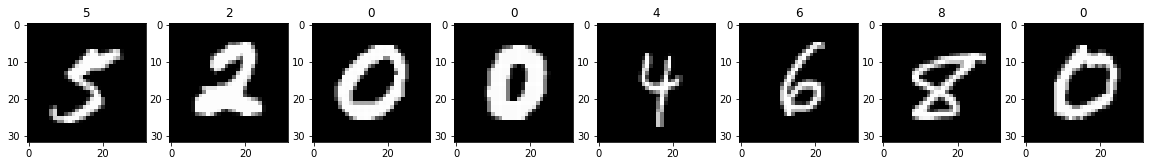

Epoch: 23, Iteration: 110676
Loss: 0.1117, Accuracy: 95.00%
Preds: [7 6 2 8 9 0 6 2]


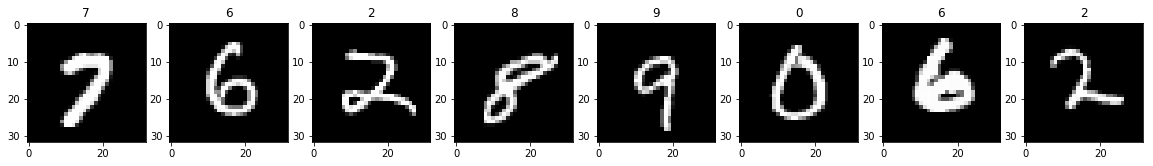

Epoch: 23, Iteration: 111676
Loss: 0.2298, Accuracy: 93.75%
Preds: [9 9 3 6 6 9 0 6]


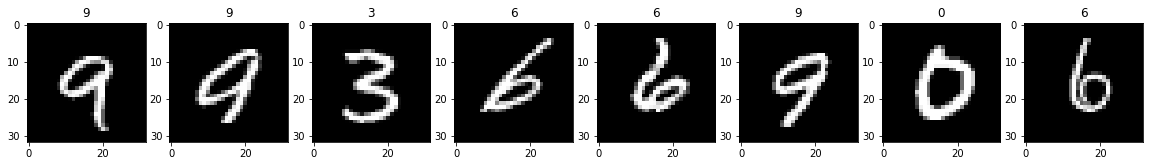

Epoch: 23, Iteration: 112676
Loss: 0.1721, Accuracy: 96.25%
Preds: [2 9 7 9 3 8 5 8]


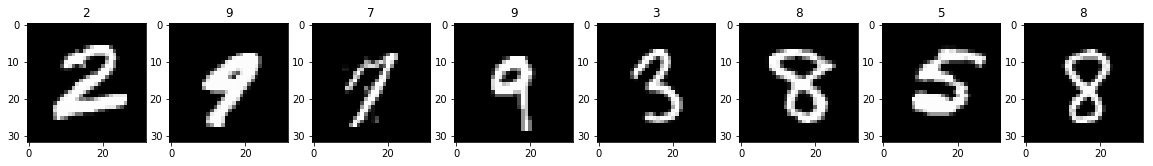

Epoch: 24, Iteration: 113401
Loss: 0.1756, Accuracy: 92.50%
Preds: [2 5 4 0 4 5 0 5]


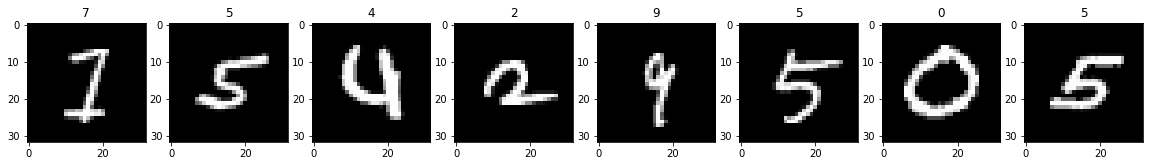

Epoch: 24, Iteration: 114401
Loss: 0.1810, Accuracy: 93.75%
Preds: [3 0 6 9 2 1 4 9]


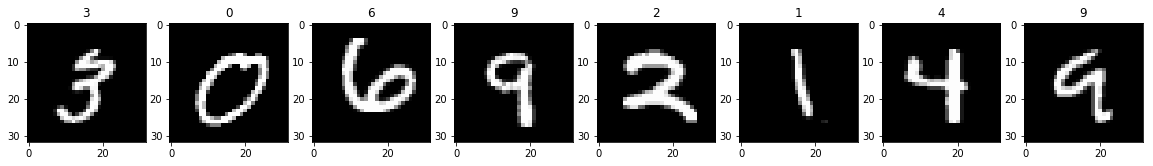

Epoch: 24, Iteration: 115401
Loss: 0.1027, Accuracy: 96.25%
Preds: [3 7 4 3 6 3 8 7]


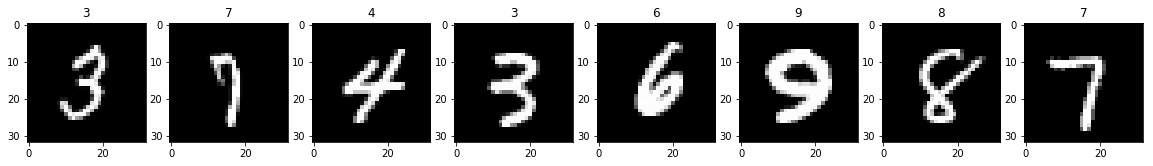

Epoch: 24, Iteration: 116401
Loss: 0.1437, Accuracy: 95.00%
Preds: [3 2 0 1 7 4 6 6]


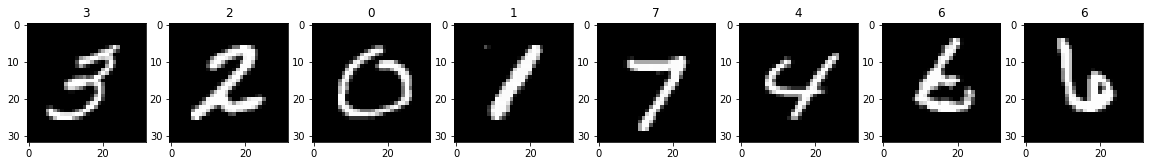

Epoch: 24, Iteration: 117401
Loss: 0.2371, Accuracy: 95.00%
Preds: [9 2 9 0 3 1 1 9]


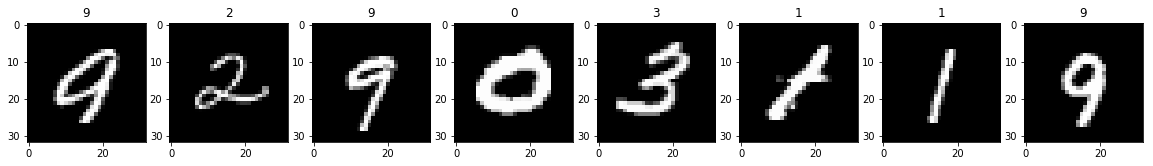

Epoch: 25, Iteration: 118126
Loss: 0.1129, Accuracy: 97.50%
Preds: [3 2 7 3 3 2 5 3]


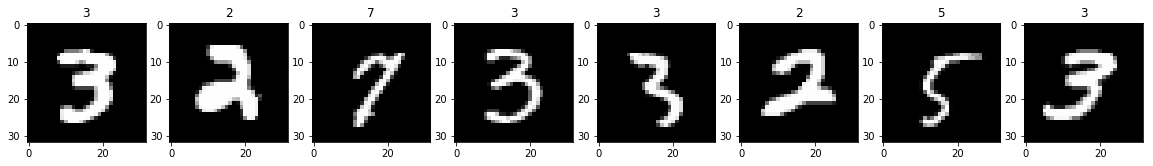

Epoch: 25, Iteration: 119126
Loss: 0.2096, Accuracy: 92.50%
Preds: [8 6 5 2 6 8 9 4]


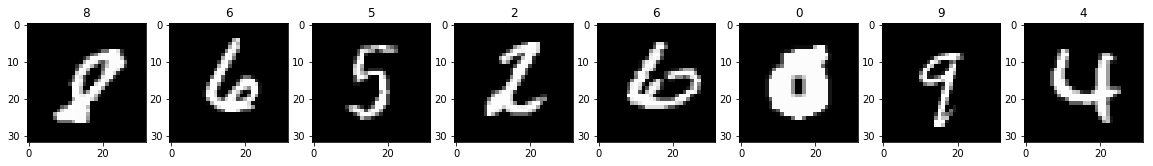

Epoch: 25, Iteration: 120126
Loss: 0.1129, Accuracy: 96.25%
Preds: [5 2 5 6 5 6 6 8]


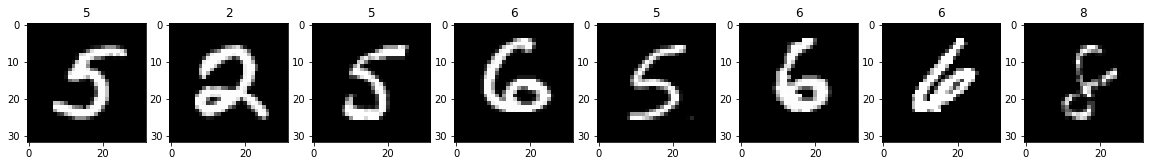

Epoch: 25, Iteration: 121126
Loss: 0.1053, Accuracy: 97.50%
Preds: [2 5 2 8 7 1 5 1]


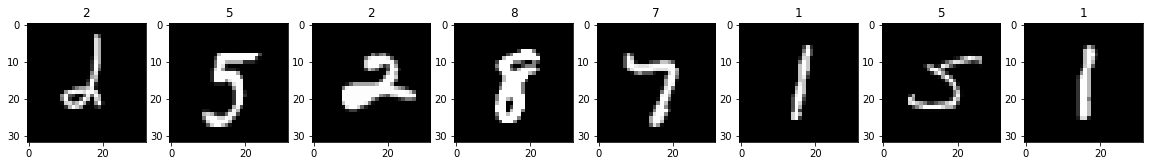

Epoch: 25, Iteration: 122126
Loss: 0.1359, Accuracy: 96.25%
Preds: [8 9 9 1 9 7 3 8]


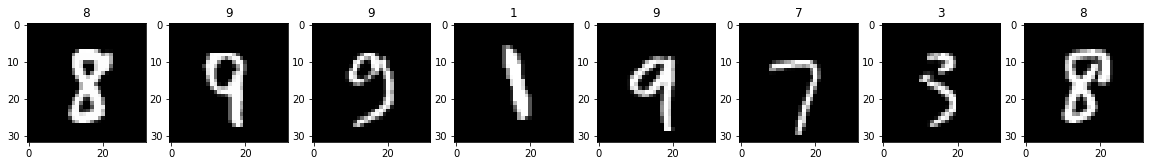

Epoch: 26, Iteration: 122851
Loss: 0.1051, Accuracy: 97.50%
Preds: [1 4 5 1 8 0 1 9]


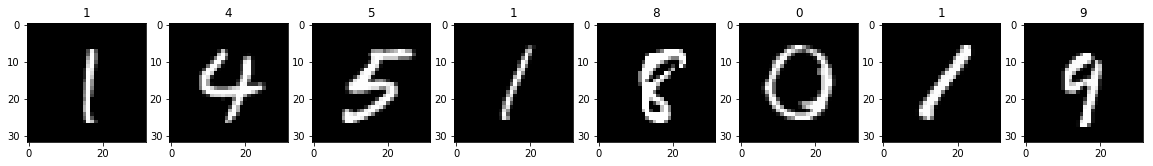

Epoch: 26, Iteration: 123851
Loss: 0.0193, Accuracy: 100.00%
Preds: [9 2 3 4 9 9 4 3]


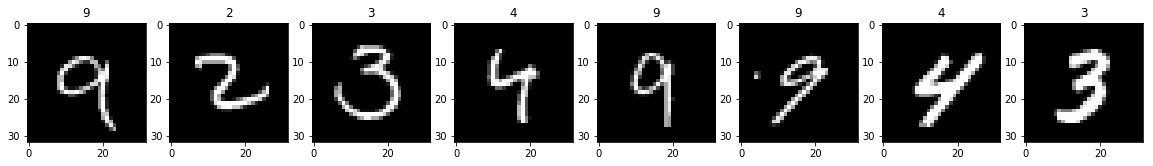

Epoch: 26, Iteration: 124851
Loss: 0.0788, Accuracy: 97.50%
Preds: [4 2 0 7 3 9 1 2]


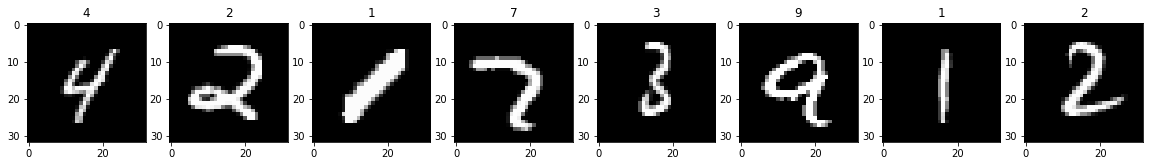

Epoch: 26, Iteration: 125851
Loss: 0.0787, Accuracy: 96.25%
Preds: [9 6 2 0 6 9 8 6]


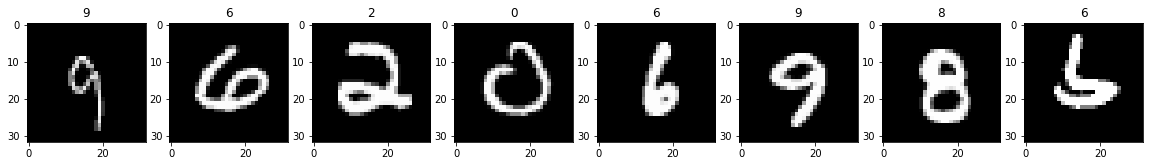

Epoch: 26, Iteration: 126851
Loss: 0.0687, Accuracy: 97.50%
Preds: [8 9 5 3 2 9 0 7]


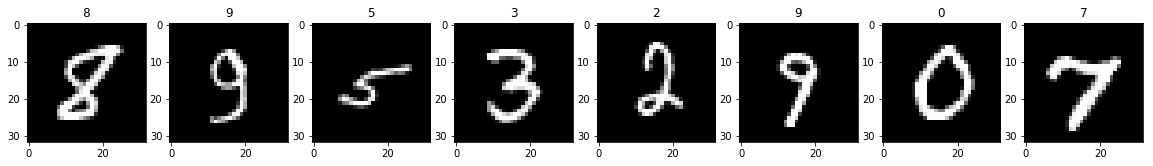

Epoch: 27, Iteration: 127576
Loss: 0.0401, Accuracy: 98.75%
Preds: [2 9 1 7 0 6 1 0]


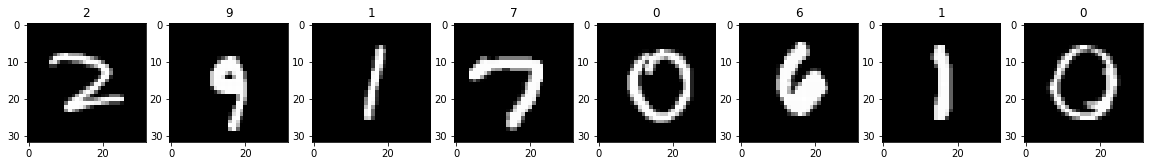

Epoch: 27, Iteration: 128576
Loss: 0.0278, Accuracy: 98.75%
Preds: [1 6 1 0 0 4 5 9]


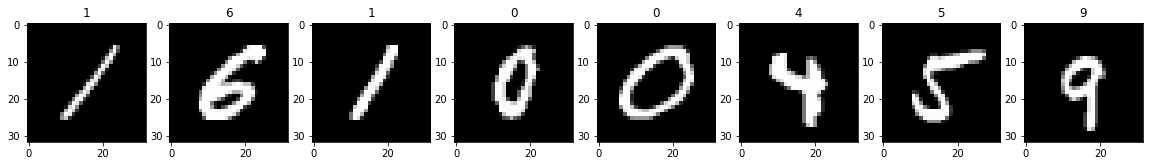

Epoch: 27, Iteration: 129576
Loss: 0.0560, Accuracy: 98.75%
Preds: [5 0 4 7 1 7 3 7]


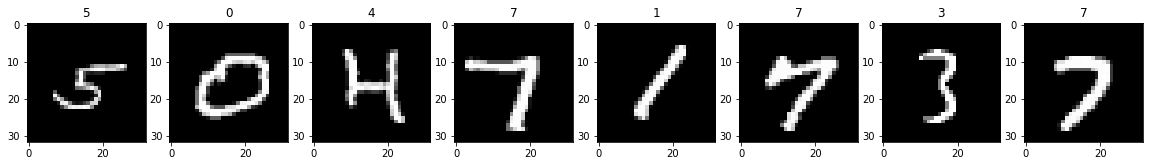

Epoch: 27, Iteration: 130576
Loss: 0.2164, Accuracy: 96.25%
Preds: [6 7 6 6 2 7 5 0]


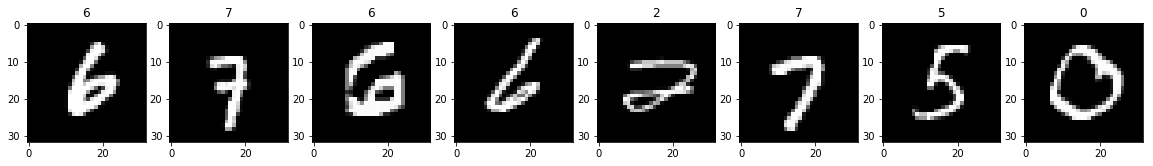

Epoch: 27, Iteration: 131576
Loss: 0.0674, Accuracy: 97.50%
Preds: [2 8 2 5 0 9 3 9]


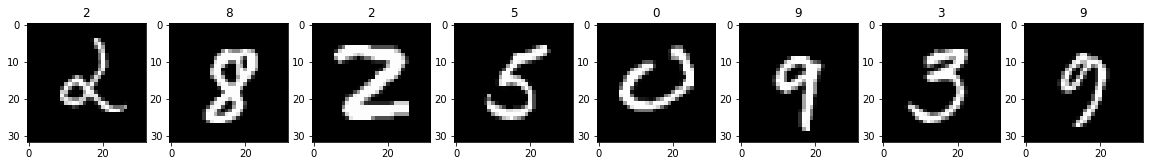

Epoch: 28, Iteration: 132301
Loss: 0.0514, Accuracy: 98.75%
Preds: [7 7 2 2 7 1 2 1]


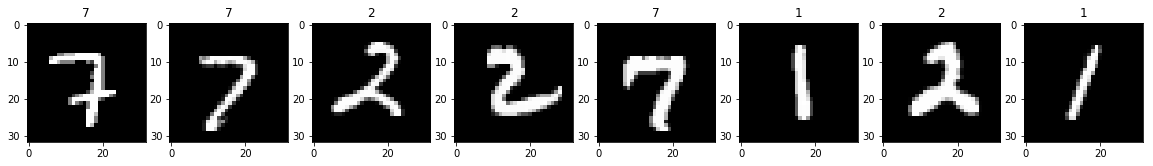

Epoch: 28, Iteration: 133301
Loss: 0.0486, Accuracy: 98.75%
Preds: [9 9 1 9 7 7 0 5]


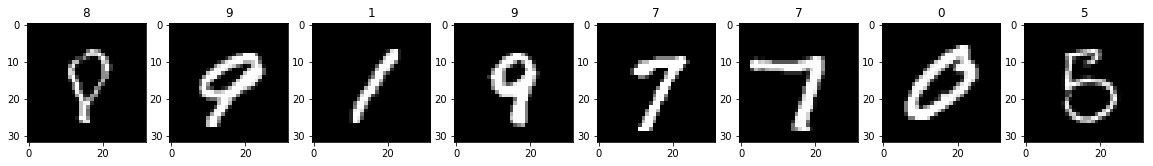

Epoch: 28, Iteration: 134301
Loss: 0.1591, Accuracy: 93.75%
Preds: [1 2 3 8 8 2 2 0]


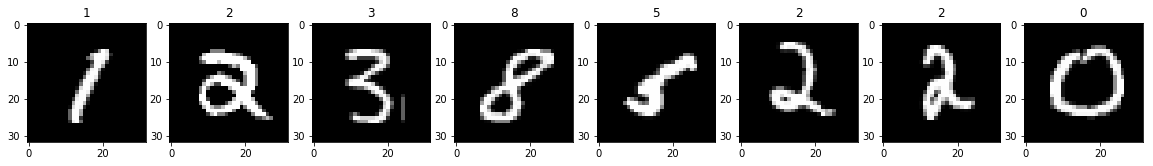

Epoch: 28, Iteration: 135301
Loss: 0.1017, Accuracy: 97.50%
Preds: [1 0 9 5 7 2 5 3]


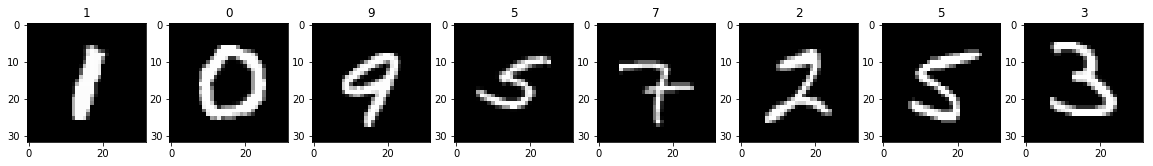

Epoch: 28, Iteration: 136301
Loss: 0.1040, Accuracy: 96.25%
Preds: [2 1 8 6 5 5 2 8]


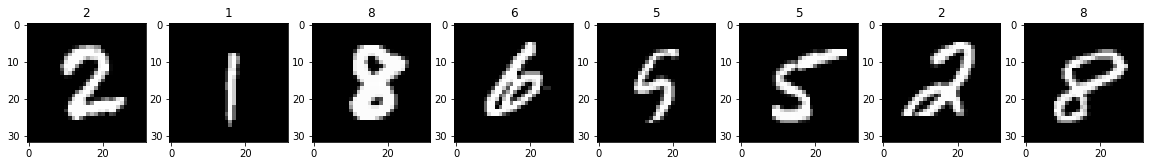

Epoch: 29, Iteration: 137026
Loss: 0.1757, Accuracy: 97.50%
Preds: [3 7 3 8 9 1 6 6]


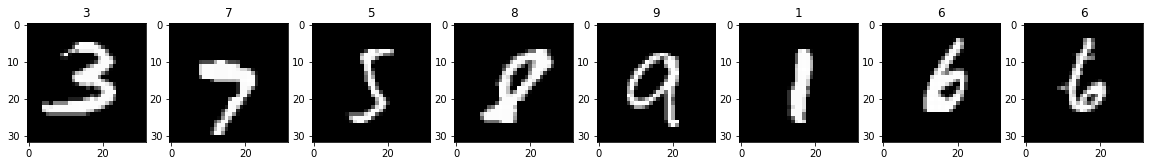

Epoch: 29, Iteration: 138026
Loss: 0.1864, Accuracy: 92.50%
Preds: [7 1 9 3 3 8 7 8]


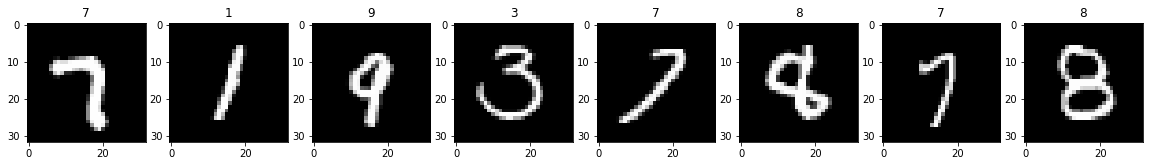

Epoch: 29, Iteration: 139026
Loss: 0.1017, Accuracy: 96.25%
Preds: [1 4 2 0 7 2 8 2]


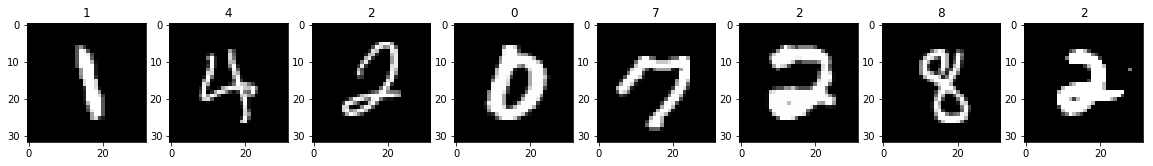

Epoch: 29, Iteration: 140026
Loss: 0.0111, Accuracy: 100.00%
Preds: [1 1 5 9 9 8 9 9]


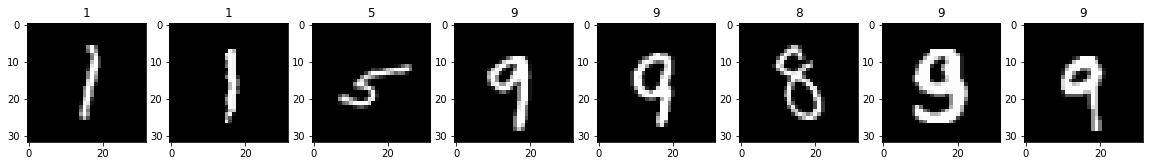

Epoch: 29, Iteration: 141026
Loss: 0.0731, Accuracy: 98.75%
Preds: [7 6 3 2 7 3 3 8]


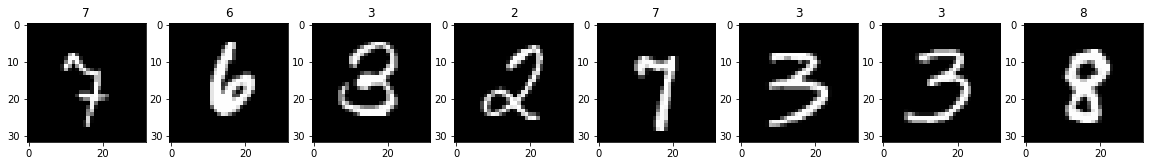

Epoch: 30, Iteration: 141751
Loss: 0.0941, Accuracy: 96.25%
Preds: [2 6 4 7 2 4 0 2]


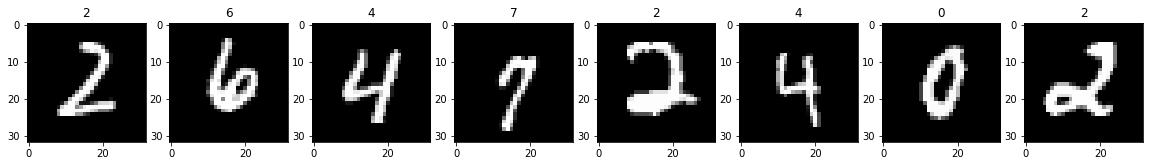

Epoch: 30, Iteration: 142751
Loss: 0.1163, Accuracy: 97.50%
Preds: [1 4 0 2 3 8 6 9]


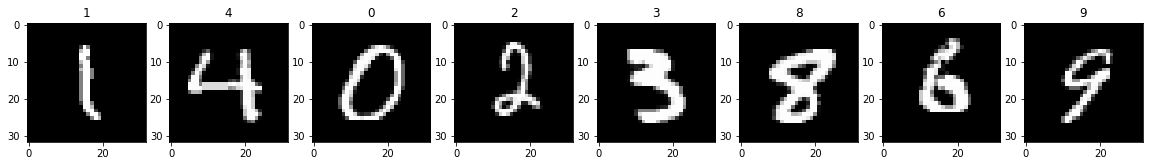

Epoch: 30, Iteration: 143751
Loss: 0.0433, Accuracy: 98.75%
Preds: [8 7 9 6 7 2 0 1]


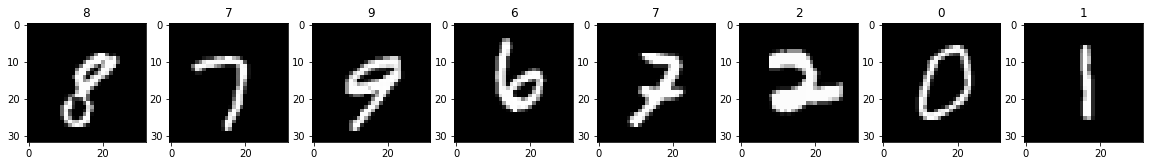

Epoch: 30, Iteration: 144751
Loss: 0.1575, Accuracy: 96.25%
Preds: [9 8 1 0 5 0 9 8]


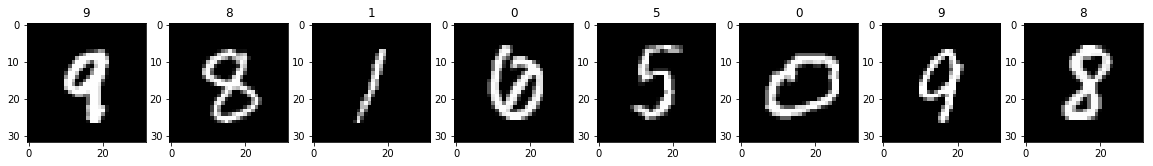

Epoch: 30, Iteration: 145751
Loss: 0.0440, Accuracy: 98.75%
Preds: [9 4 6 4 5 5 3 7]


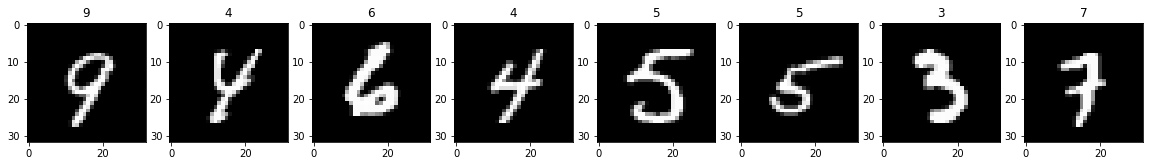

Epoch: 31, Iteration: 146476
Loss: 0.0533, Accuracy: 96.25%
Preds: [4 1 4 8 7 5 3 9]


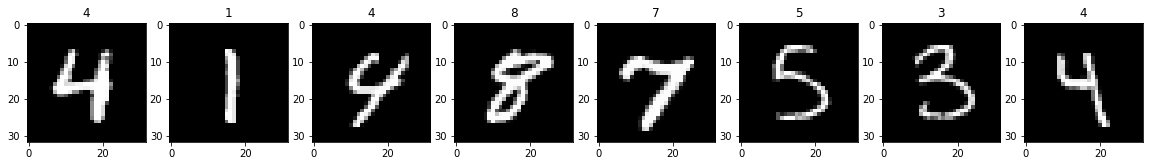

Epoch: 31, Iteration: 147476
Loss: 0.0873, Accuracy: 96.25%
Preds: [5 8 4 8 8 6 7 7]


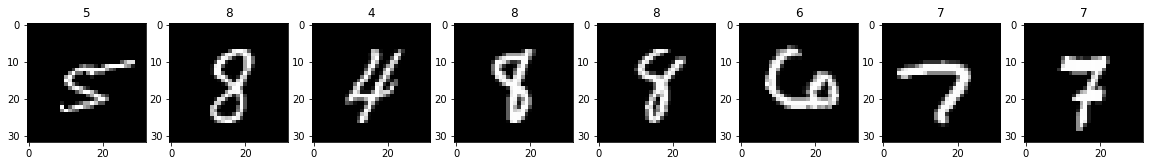

Epoch: 31, Iteration: 148476
Loss: 0.0690, Accuracy: 98.75%
Preds: [6 9 1 1 5 4 0 1]


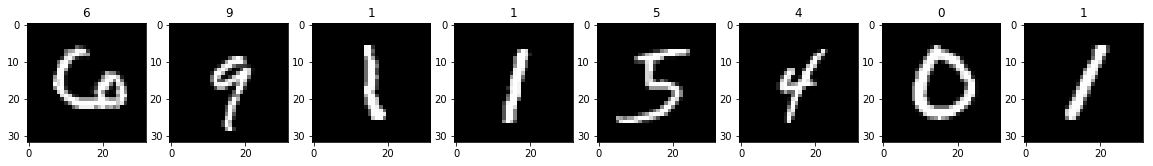

Epoch: 31, Iteration: 149476
Loss: 0.1338, Accuracy: 95.00%
Preds: [5 6 8 5 1 9 7 0]


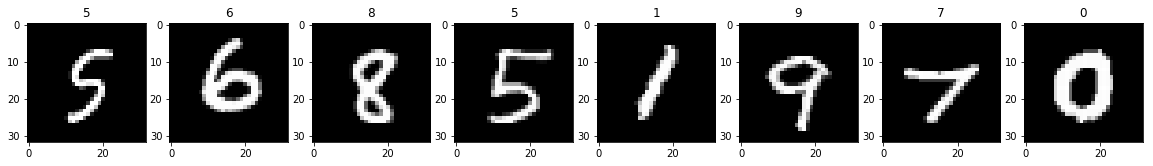

Epoch: 31, Iteration: 150476
Loss: 0.0342, Accuracy: 98.75%
Preds: [8 3 9 4 2 8 1 3]


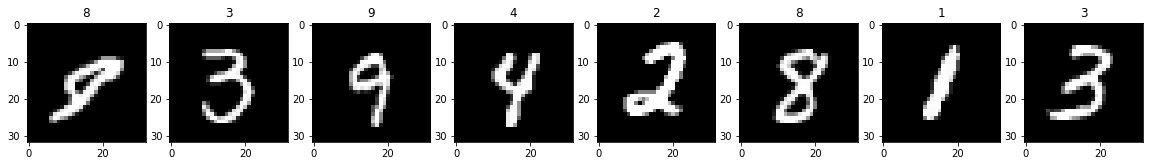

Epoch: 32, Iteration: 151201
Loss: 0.0894, Accuracy: 96.25%
Preds: [8 8 1 8 0 6 7 5]


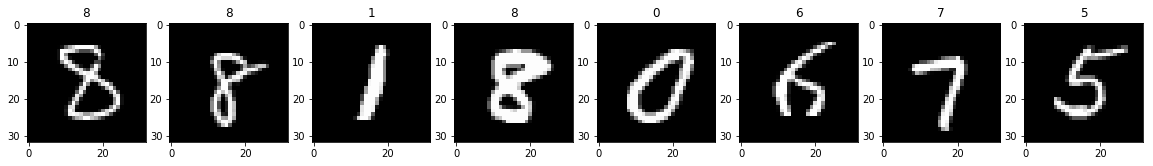

Epoch: 32, Iteration: 152201
Loss: 0.1298, Accuracy: 95.00%
Preds: [3 7 9 9 8 1 4 1]


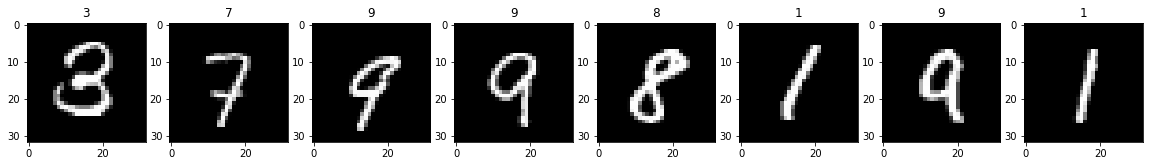

Epoch: 32, Iteration: 153201
Loss: 0.0740, Accuracy: 97.50%
Preds: [4 7 6 0 9 6 8 7]


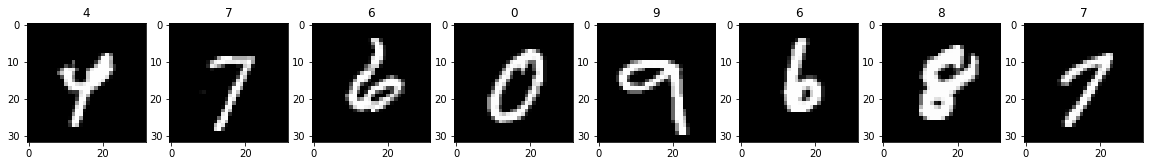

Epoch: 32, Iteration: 154201
Loss: 0.1241, Accuracy: 96.25%
Preds: [2 1 2 5 9 3 1 5]


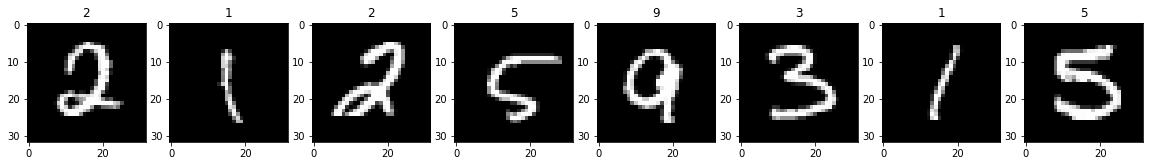

Epoch: 32, Iteration: 155201
Loss: 0.1742, Accuracy: 93.75%
Preds: [1 6 3 2 4 7 6 6]


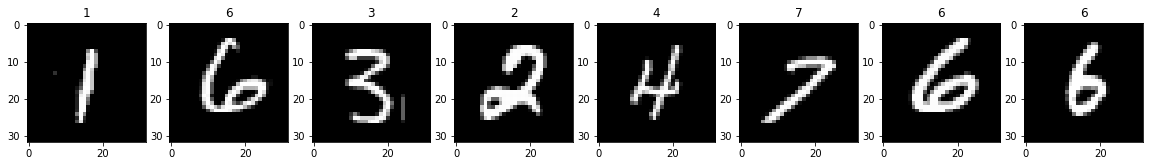

Epoch: 33, Iteration: 155926
Loss: 0.0512, Accuracy: 97.50%
Preds: [9 6 4 2 4 2 6 1]


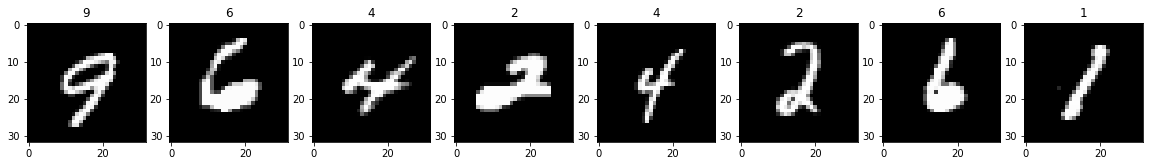

Epoch: 33, Iteration: 156926
Loss: 0.0782, Accuracy: 96.25%
Preds: [6 4 1 8 3 5 4 6]


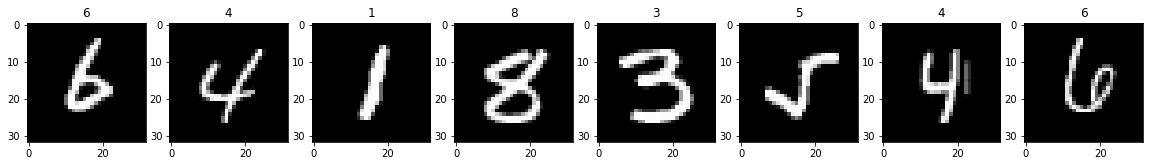

Epoch: 33, Iteration: 157926
Loss: 0.2168, Accuracy: 95.00%
Preds: [4 4 6 7 2 1 3 6]


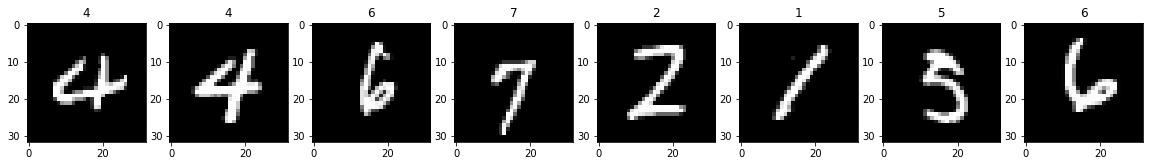

Epoch: 33, Iteration: 158926
Loss: 0.1726, Accuracy: 96.25%
Preds: [0 0 2 0 9 9 2 2]


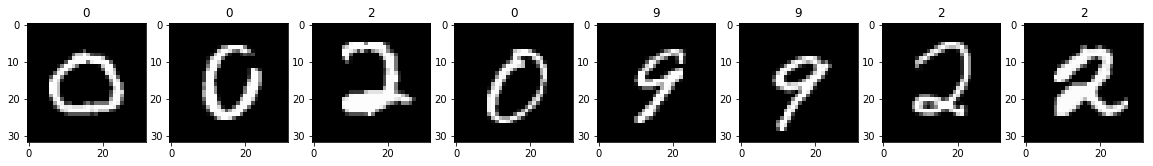

Epoch: 33, Iteration: 159926
Loss: 0.1427, Accuracy: 95.00%
Preds: [2 3 5 5 3 2 5 5]


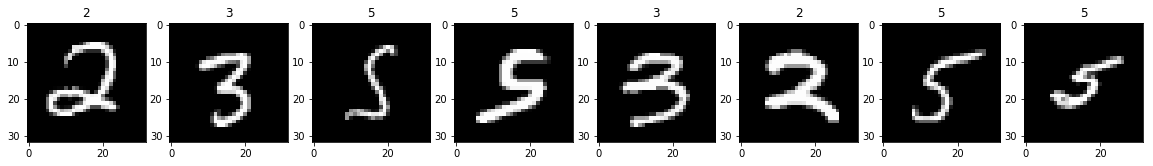

Epoch: 34, Iteration: 160651
Loss: 0.1444, Accuracy: 98.75%
Preds: [7 0 5 0 4 5 8 9]


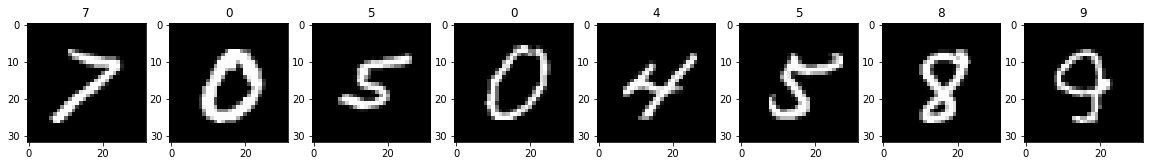

Epoch: 34, Iteration: 161651
Loss: 0.1193, Accuracy: 97.50%
Preds: [5 6 6 2 5 5 9 8]


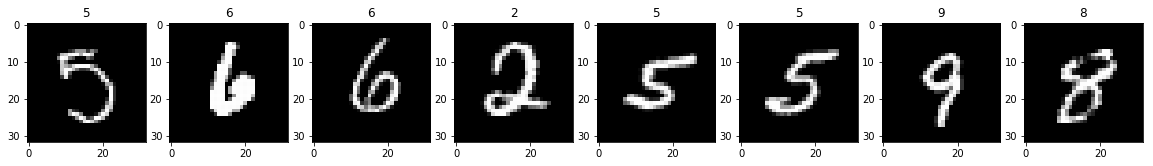

Epoch: 34, Iteration: 162651
Loss: 0.0375, Accuracy: 100.00%
Preds: [2 4 6 8 2 2 4 5]


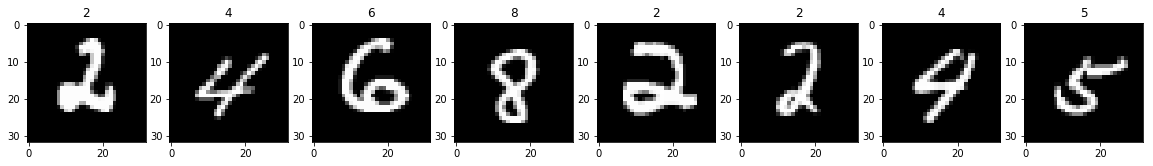

Epoch: 34, Iteration: 163651
Loss: 0.0384, Accuracy: 98.75%
Preds: [1 2 7 7 0 4 6 9]


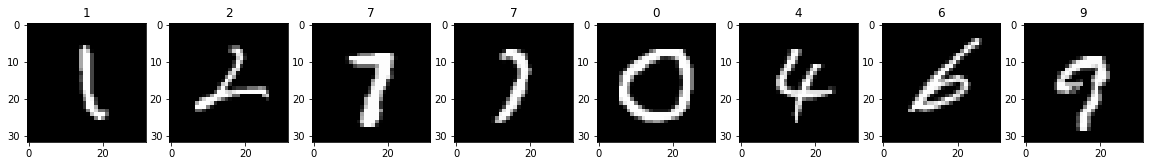

Epoch: 34, Iteration: 164651
Loss: 0.0903, Accuracy: 97.50%
Preds: [9 1 1 8 6 9 7 1]


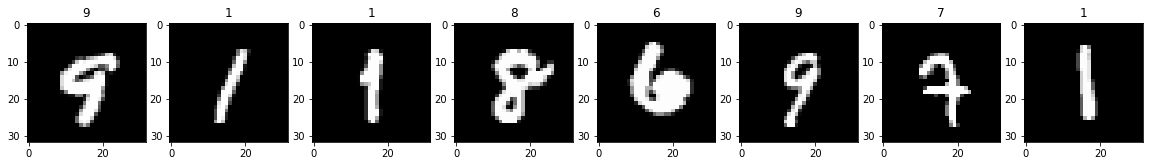

Epoch: 35, Iteration: 165376
Loss: 0.0287, Accuracy: 100.00%
Preds: [2 5 6 2 5 9 8 2]


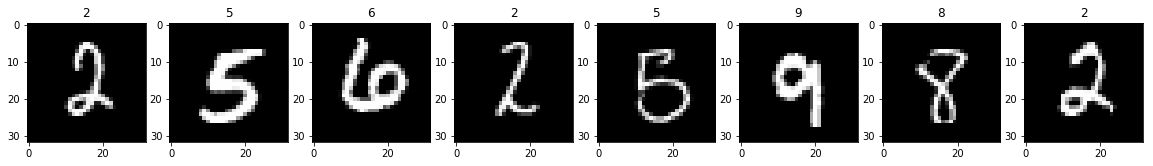

Epoch: 35, Iteration: 166376
Loss: 0.0411, Accuracy: 98.75%
Preds: [3 6 6 8 0 8 2 9]


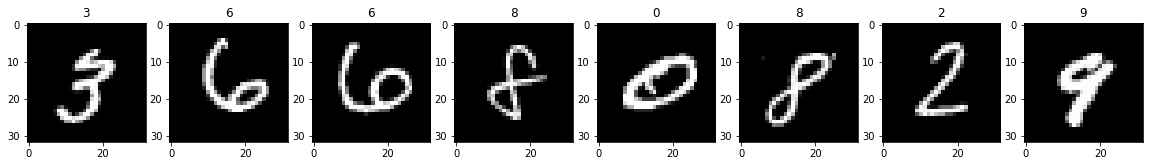

Epoch: 35, Iteration: 167376
Loss: 0.0989, Accuracy: 97.50%
Preds: [5 4 9 0 7 0 2 8]


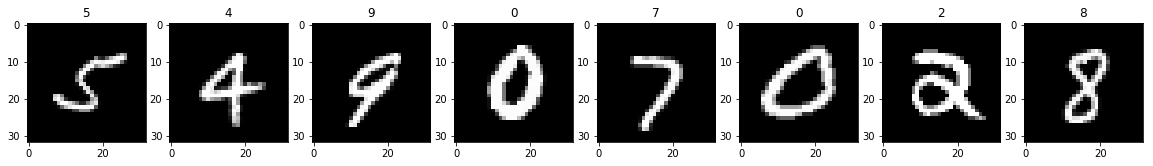

Epoch: 35, Iteration: 168376
Loss: 0.1026, Accuracy: 97.50%
Preds: [8 7 9 8 5 4 5 8]


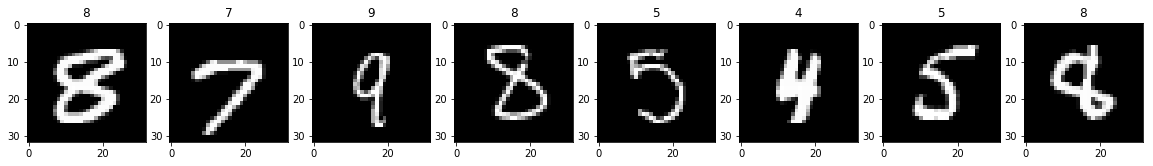

Epoch: 35, Iteration: 169376
Loss: 0.1374, Accuracy: 97.50%
Preds: [4 2 3 4 2 4 2 8]


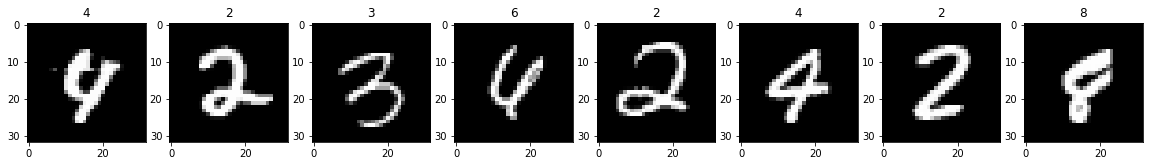

Epoch: 36, Iteration: 170101
Loss: 0.0661, Accuracy: 97.50%
Preds: [7 7 2 6 1 6 2 0]


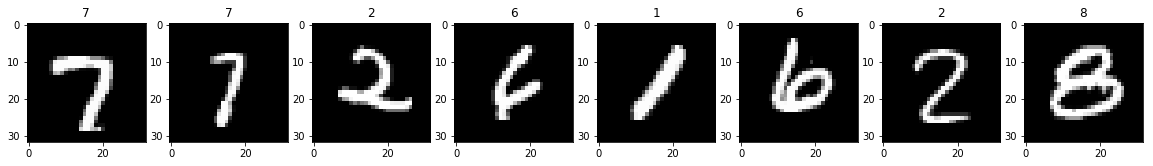

Epoch: 36, Iteration: 171101
Loss: 0.0460, Accuracy: 97.50%
Preds: [7 8 5 7 8 9 3 3]


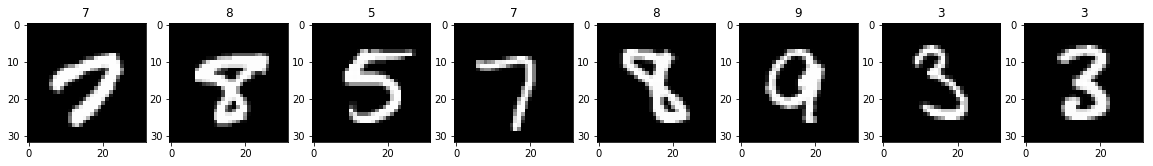

Epoch: 36, Iteration: 172101
Loss: 0.1933, Accuracy: 96.25%
Preds: [0 4 0 5 8 2 0 2]


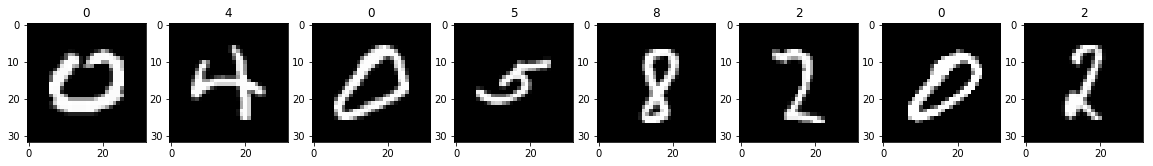

Epoch: 36, Iteration: 173101
Loss: 0.0250, Accuracy: 100.00%
Preds: [1 1 3 9 3 1 5 1]


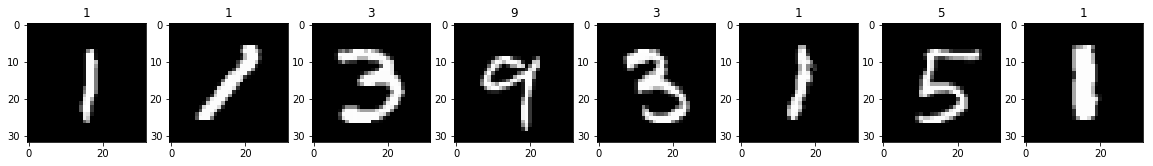

Epoch: 36, Iteration: 174101
Loss: 0.0359, Accuracy: 98.75%
Preds: [7 2 5 4 6 1 9 8]


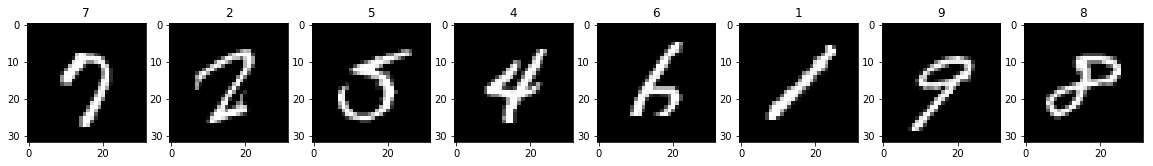

Epoch: 37, Iteration: 174826
Loss: 0.2011, Accuracy: 95.00%
Preds: [4 6 5 8 3 8 7 6]


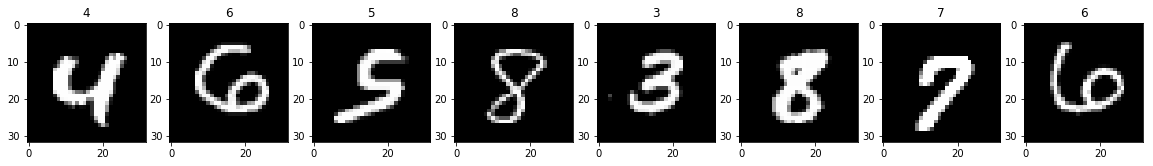

Epoch: 37, Iteration: 175826
Loss: 0.0883, Accuracy: 96.25%
Preds: [4 9 6 0 6 9 4 5]


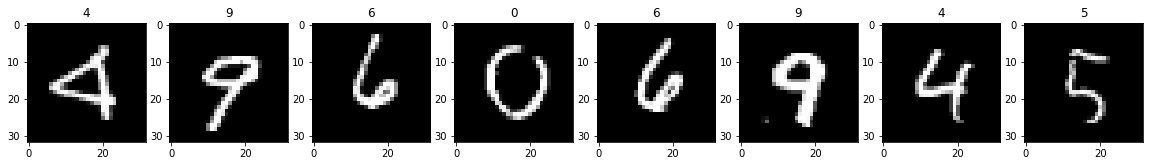

Epoch: 37, Iteration: 176826
Loss: 0.0874, Accuracy: 97.50%
Preds: [3 7 1 6 2 6 4 1]


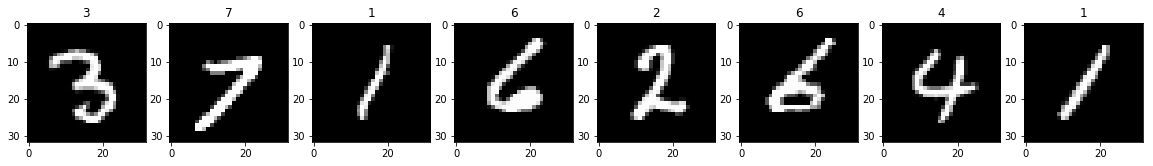

Epoch: 37, Iteration: 177826
Loss: 0.1204, Accuracy: 97.50%
Preds: [0 1 2 9 1 1 8 4]


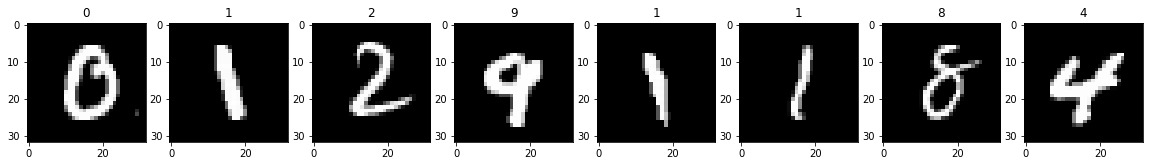

Epoch: 37, Iteration: 178826
Loss: 0.0425, Accuracy: 100.00%
Preds: [6 5 4 8 6 0 9 6]


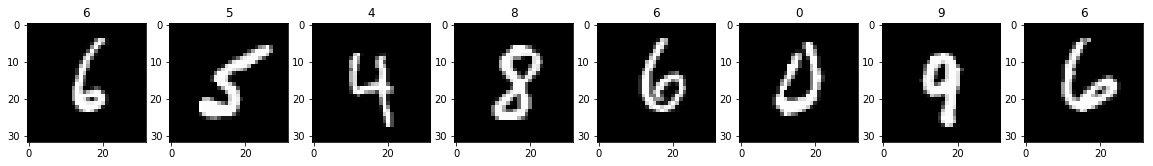

Epoch: 38, Iteration: 179551
Loss: 0.1076, Accuracy: 97.50%
Preds: [1 9 0 9 2 9 2 4]


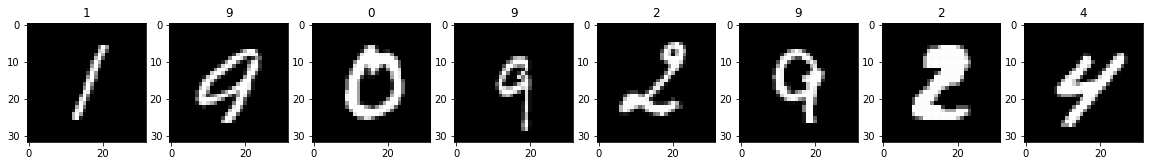

Epoch: 38, Iteration: 180551
Loss: 0.1808, Accuracy: 93.75%
Preds: [7 6 9 7 8 8 2 1]


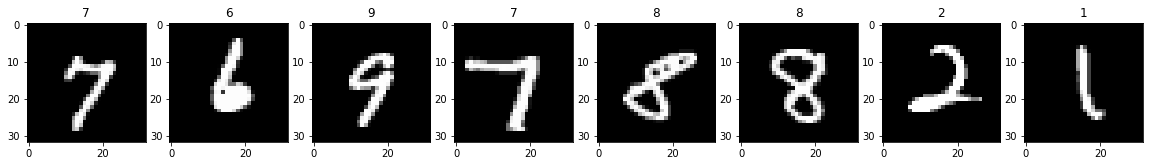

Epoch: 38, Iteration: 181551
Loss: 0.0693, Accuracy: 98.75%
Preds: [5 9 5 5 4 9 3 7]


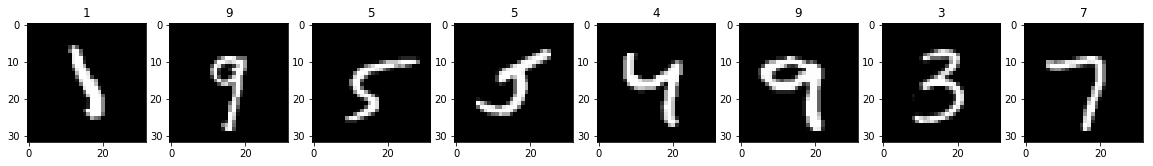

Epoch: 38, Iteration: 182551
Loss: 0.0655, Accuracy: 97.50%
Preds: [9 4 6 8 7 5 3 4]


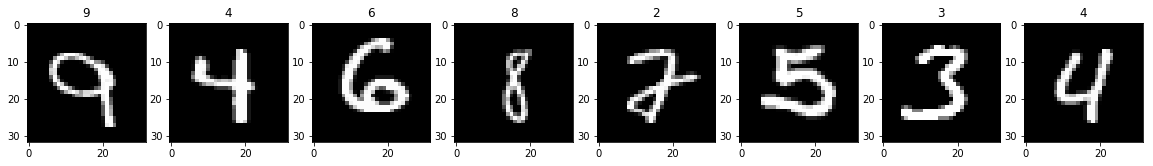

Epoch: 38, Iteration: 183551
Loss: 0.1501, Accuracy: 93.75%
Preds: [5 3 2 7 3 8 3 3]


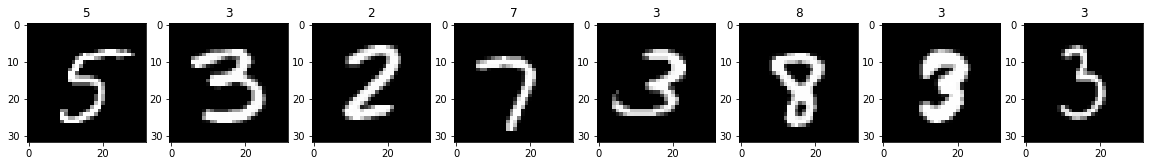

Epoch: 39, Iteration: 184276
Loss: 0.0260, Accuracy: 100.00%
Preds: [5 6 8 9 1 0 2 1]


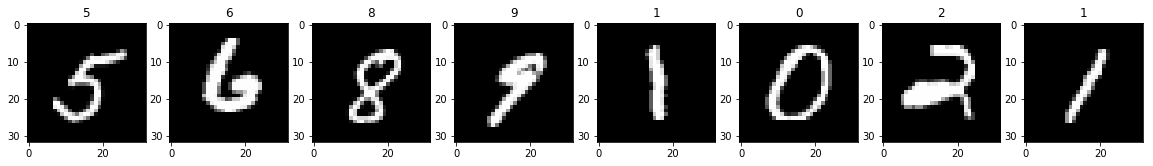

Epoch: 39, Iteration: 185276
Loss: 0.0291, Accuracy: 97.50%
Preds: [9 2 2 5 2 2 5 8]


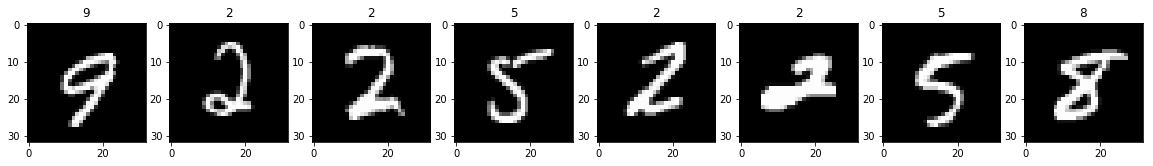

Epoch: 39, Iteration: 186276
Loss: 0.0788, Accuracy: 97.50%
Preds: [2 4 9 5 1 1 6 1]


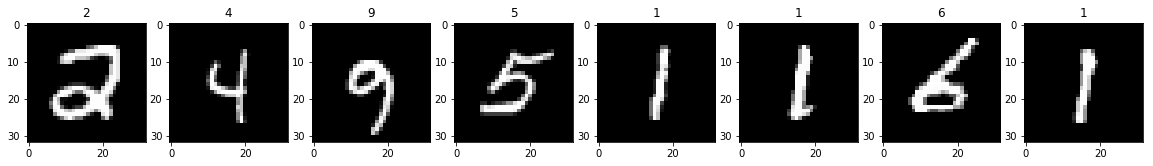

Epoch: 39, Iteration: 187276
Loss: 0.1912, Accuracy: 93.75%
Preds: [3 9 6 5 4 7 0 2]


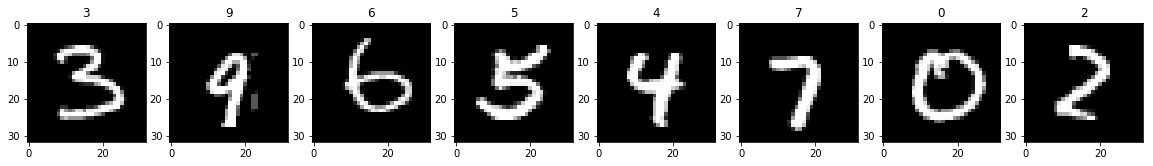

Epoch: 39, Iteration: 188276
Loss: 0.0760, Accuracy: 96.25%
Preds: [9 3 0 9 5 4 5 9]


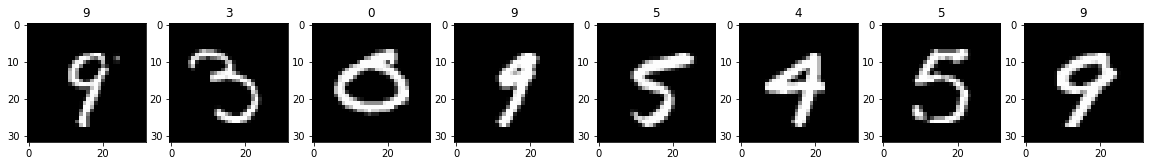

Epoch: 40, Iteration: 189001
Loss: 0.0215, Accuracy: 100.00%
Preds: [0 9 2 0 2 7 9 8]


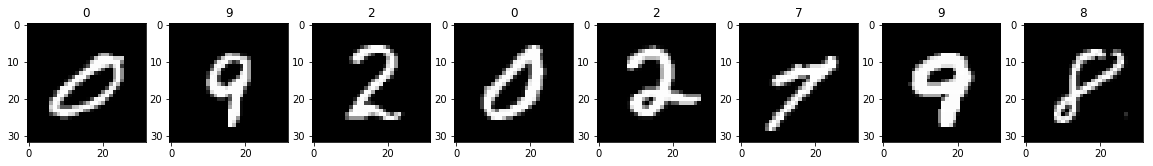

Epoch: 40, Iteration: 190001
Loss: 0.2190, Accuracy: 96.25%
Preds: [4 2 0 1 5 8 0 8]


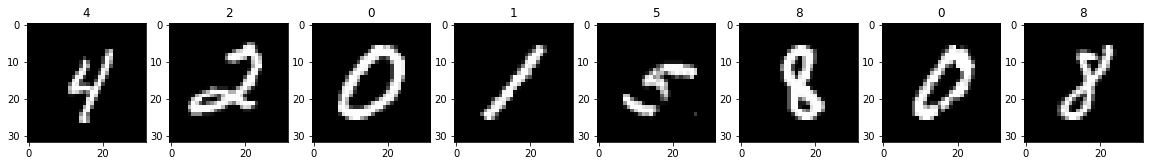

Epoch: 40, Iteration: 191001
Loss: 0.0256, Accuracy: 100.00%
Preds: [8 6 4 0 2 4 7 8]


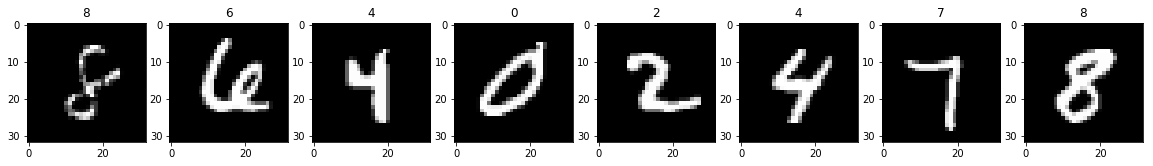

Epoch: 40, Iteration: 192001
Loss: 0.0625, Accuracy: 97.50%
Preds: [9 4 8 3 8 3 9 1]


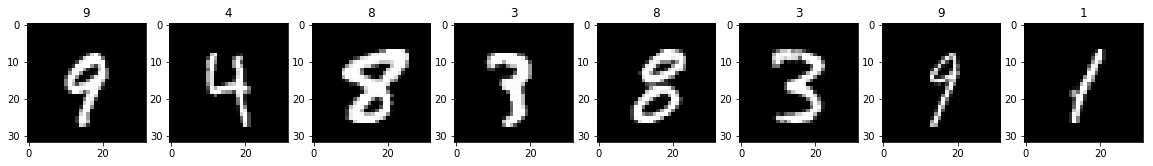

Epoch: 40, Iteration: 193001
Loss: 0.1333, Accuracy: 96.25%
Preds: [0 2 9 6 2 8 8 1]


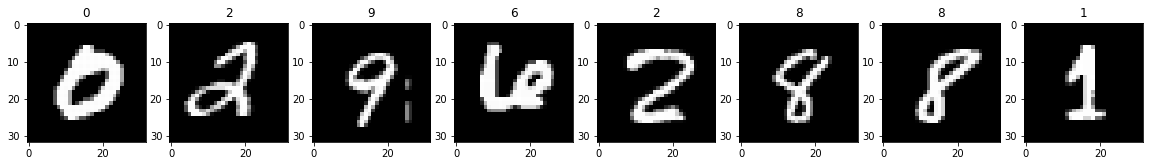

Epoch: 41, Iteration: 193726
Loss: 0.0470, Accuracy: 98.75%
Preds: [5 7 1 1 0 1 2 1]


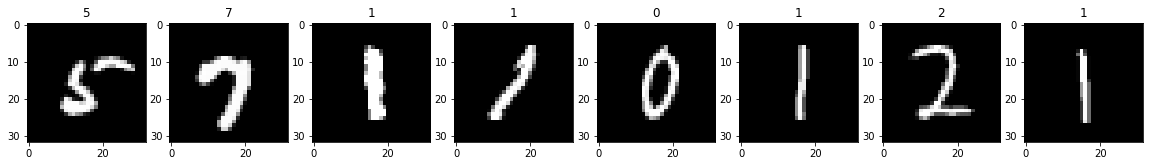

Epoch: 41, Iteration: 194726
Loss: 0.0825, Accuracy: 97.50%
Preds: [9 5 0 9 3 8 1 0]


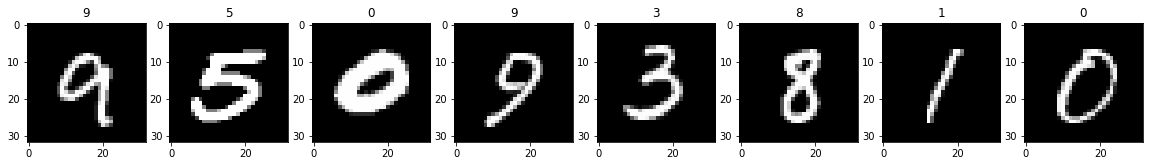

Epoch: 41, Iteration: 195726
Loss: 0.0315, Accuracy: 98.75%
Preds: [8 5 5 8 8 9 1 8]


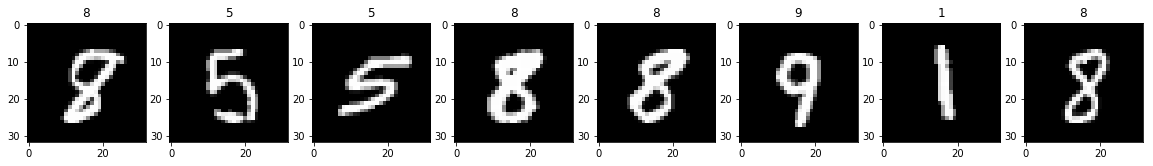

Epoch: 41, Iteration: 196726
Loss: 0.1729, Accuracy: 92.50%
Preds: [5 2 6 7 7 1 6 1]


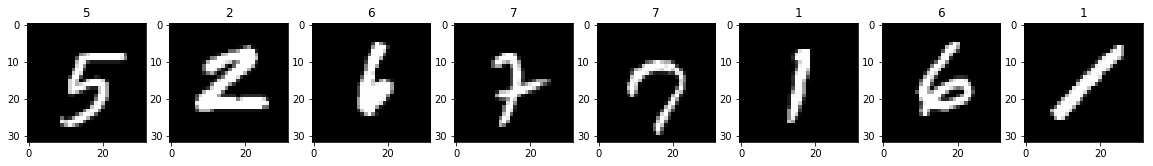

Epoch: 41, Iteration: 197726
Loss: 0.1917, Accuracy: 93.75%
Preds: [8 3 0 6 9 0 0 3]


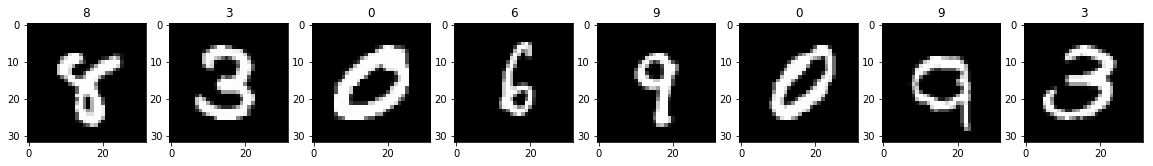

Epoch: 42, Iteration: 198451
Loss: 0.1761, Accuracy: 96.25%
Preds: [0 1 4 2 1 3 4 3]


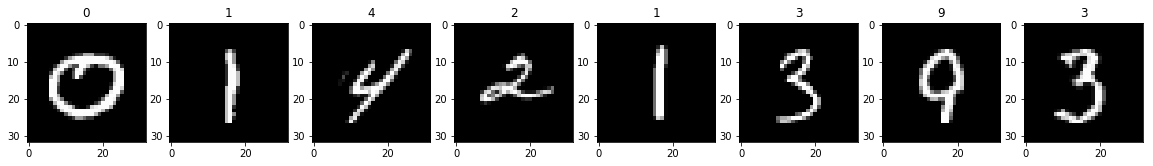

Epoch: 42, Iteration: 199451
Loss: 0.0856, Accuracy: 97.50%
Preds: [2 4 7 1 8 9 3 4]


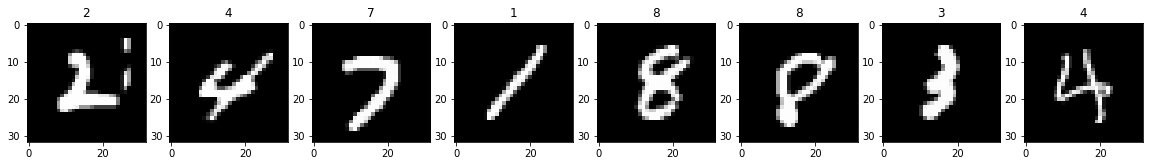

Epoch: 42, Iteration: 200451
Loss: 0.1645, Accuracy: 95.00%
Preds: [2 6 5 5 4 7 1 2]


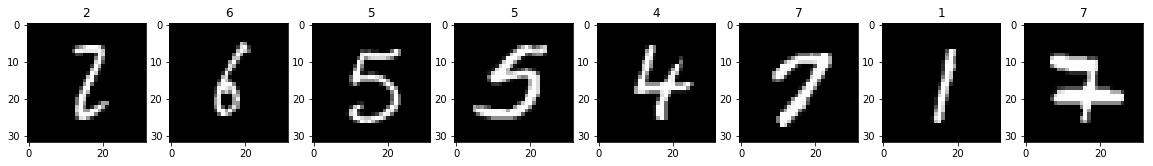

Epoch: 42, Iteration: 201451
Loss: 0.1458, Accuracy: 96.25%
Preds: [5 5 9 1 0 2 4 1]


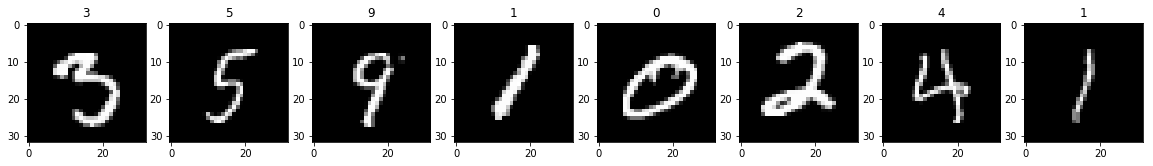

Epoch: 42, Iteration: 202451
Loss: 0.0568, Accuracy: 97.50%
Preds: [9 5 0 4 2 2 3 9]


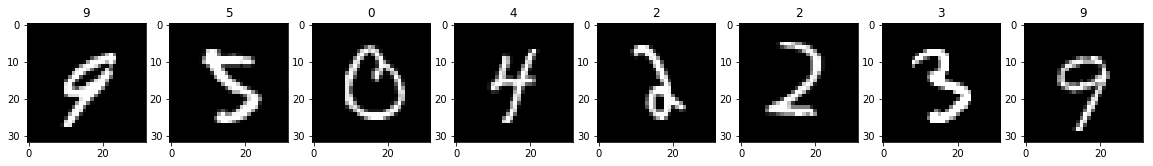

Epoch: 43, Iteration: 203176
Loss: 0.0133, Accuracy: 100.00%
Preds: [2 5 2 1 5 5 3 2]


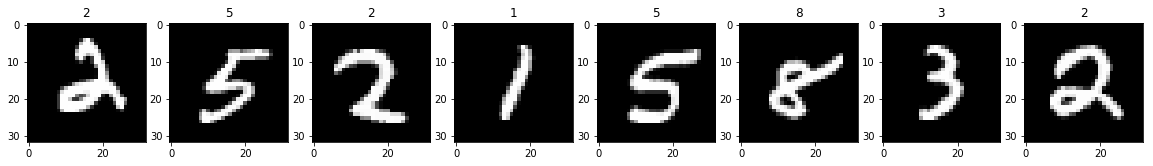

Epoch: 43, Iteration: 204176
Loss: 0.2236, Accuracy: 92.50%
Preds: [1 4 1 3 7 2 9 9]


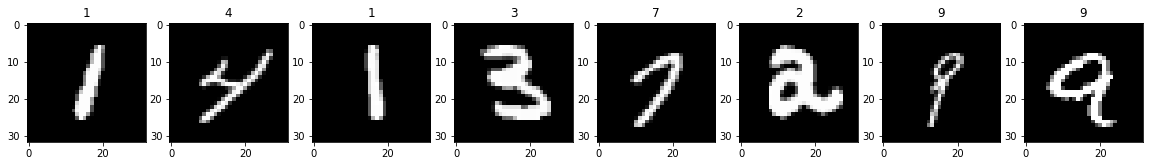

Epoch: 43, Iteration: 205176
Loss: 0.1614, Accuracy: 93.75%
Preds: [0 9 3 8 7 6 6 2]


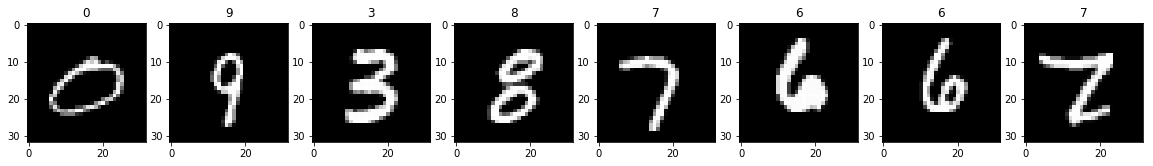

Epoch: 43, Iteration: 206176
Loss: 0.1015, Accuracy: 98.75%
Preds: [4 8 0 6 5 8 6 0]


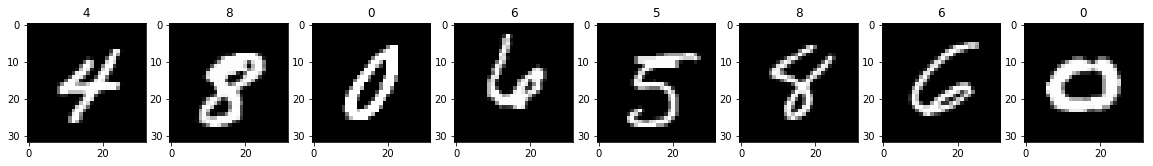

Epoch: 43, Iteration: 207176
Loss: 0.0954, Accuracy: 95.00%
Preds: [2 5 7 5 8 0 4 5]


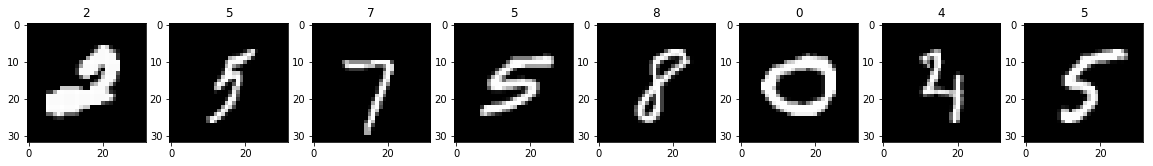

Epoch: 44, Iteration: 207901
Loss: 0.1106, Accuracy: 98.75%
Preds: [1 1 9 9 4 6 0 2]


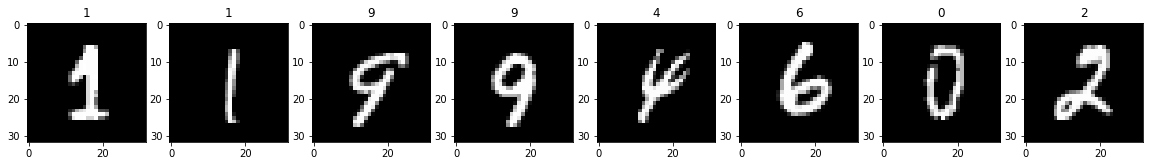

Epoch: 44, Iteration: 208901
Loss: 0.1276, Accuracy: 97.50%
Preds: [7 1 5 3 3 0 6 8]


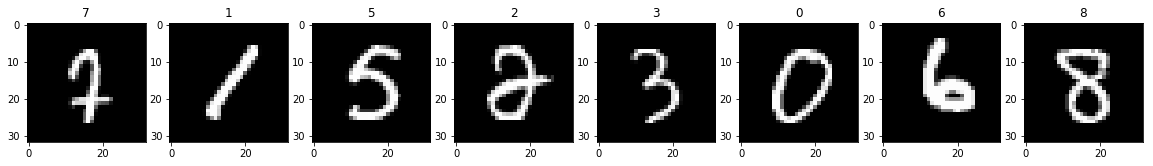

Epoch: 44, Iteration: 209901
Loss: 0.1020, Accuracy: 97.50%
Preds: [6 7 8 5 5 5 3 4]


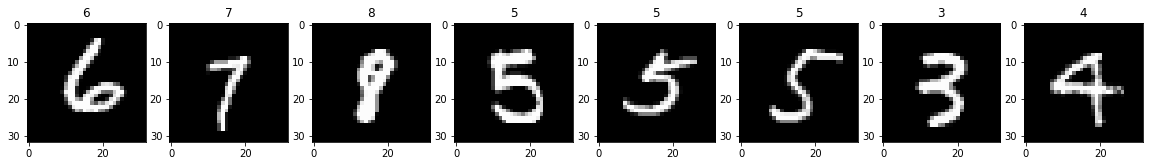

Epoch: 44, Iteration: 210901
Loss: 0.1258, Accuracy: 95.00%
Preds: [2 5 0 2 2 9 2 7]


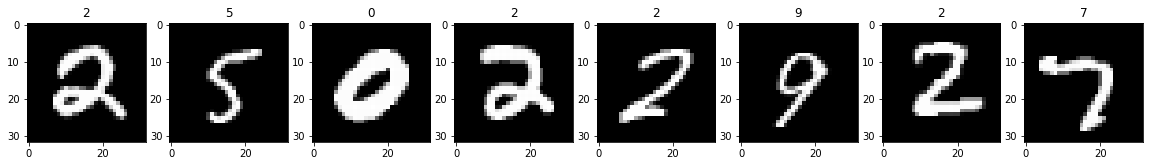

Epoch: 44, Iteration: 211901
Loss: 0.0450, Accuracy: 98.75%
Preds: [9 6 0 2 7 2 1 9]


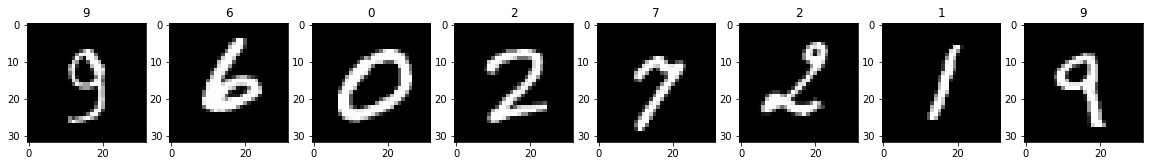

Epoch: 45, Iteration: 212626
Loss: 0.0397, Accuracy: 98.75%
Preds: [3 8 5 6 8 4 7 2]


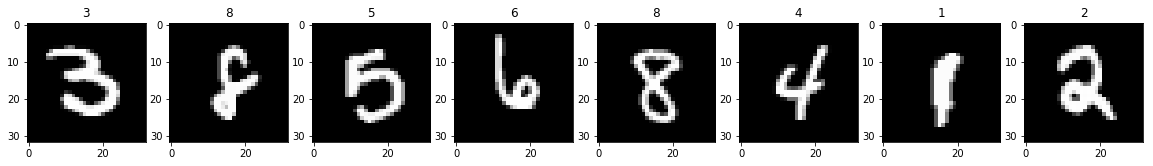

Epoch: 45, Iteration: 213626
Loss: 0.1898, Accuracy: 93.75%
Preds: [7 8 8 9 8 8 3 8]


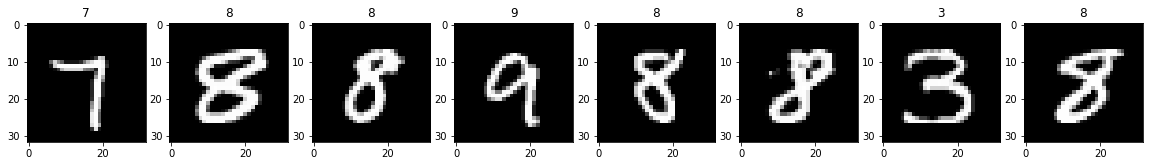

Epoch: 45, Iteration: 214626
Loss: 0.0284, Accuracy: 100.00%
Preds: [8 0 8 6 2 0 6 5]


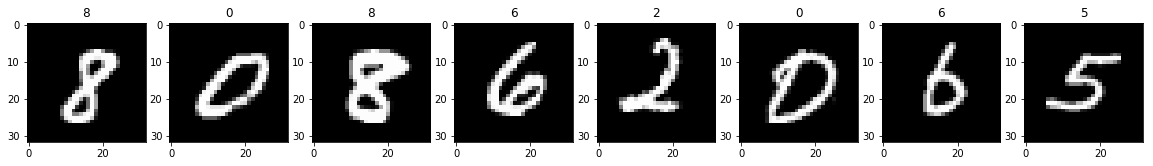

Epoch: 45, Iteration: 215626
Loss: 0.2410, Accuracy: 95.00%
Preds: [9 1 5 7 8 9 2 4]


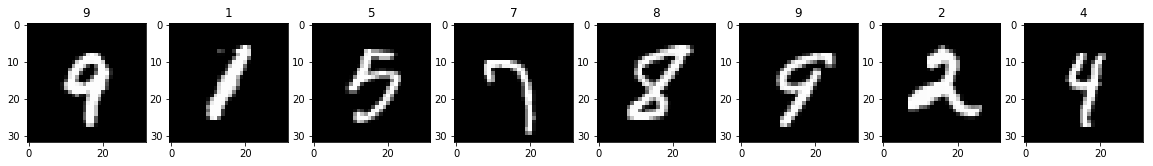

Epoch: 45, Iteration: 216626
Loss: 0.1030, Accuracy: 96.25%
Preds: [6 1 7 6 3 9 0 8]


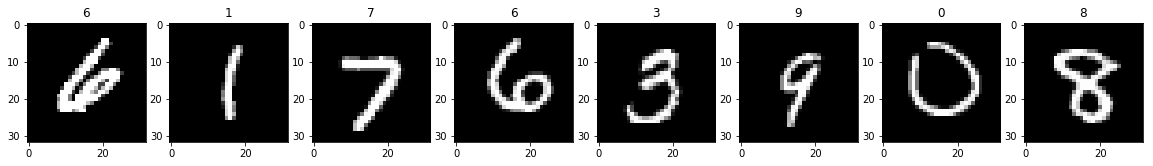

Epoch: 46, Iteration: 217351
Loss: 0.0246, Accuracy: 100.00%
Preds: [7 4 6 8 8 3 2 1]


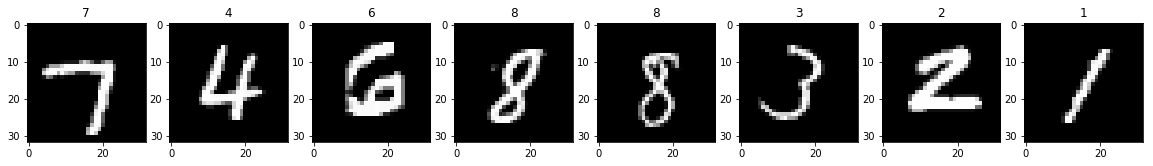

Epoch: 46, Iteration: 218351
Loss: 0.0901, Accuracy: 98.75%
Preds: [2 7 8 5 2 0 1 8]


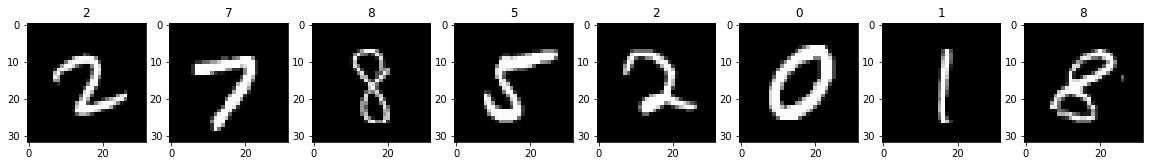

Epoch: 46, Iteration: 219351
Loss: 0.0940, Accuracy: 95.00%
Preds: [2 7 8 8 1 3 6 6]


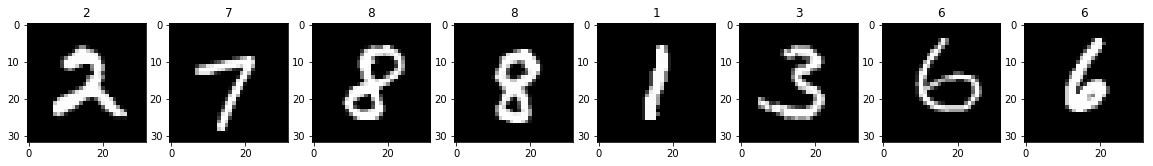

Epoch: 46, Iteration: 220351
Loss: 0.0222, Accuracy: 100.00%
Preds: [5 3 4 6 0 8 7 6]


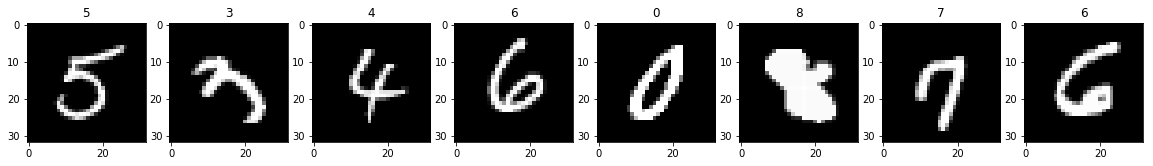

Epoch: 46, Iteration: 221351
Loss: 0.1593, Accuracy: 98.75%
Preds: [4 9 0 7 5 8 5 8]


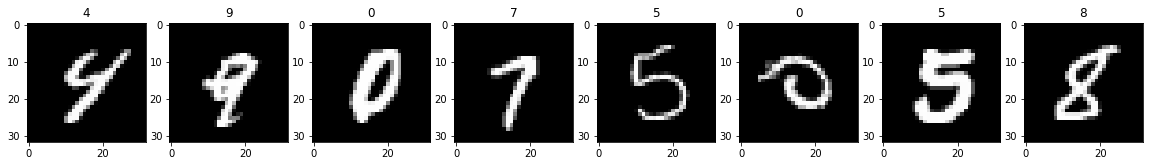

Epoch: 47, Iteration: 222076
Loss: 0.1381, Accuracy: 96.25%
Preds: [2 6 9 9 9 6 2 5]


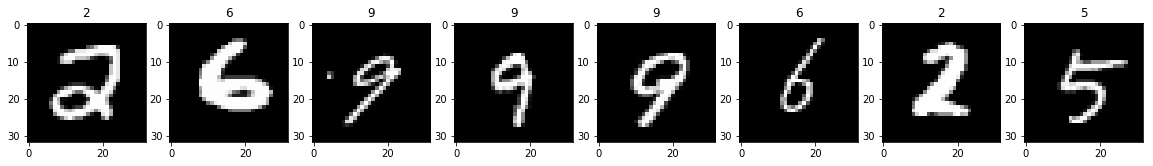

Epoch: 47, Iteration: 223076
Loss: 0.1095, Accuracy: 96.25%
Preds: [4 1 2 0 2 2 7 5]


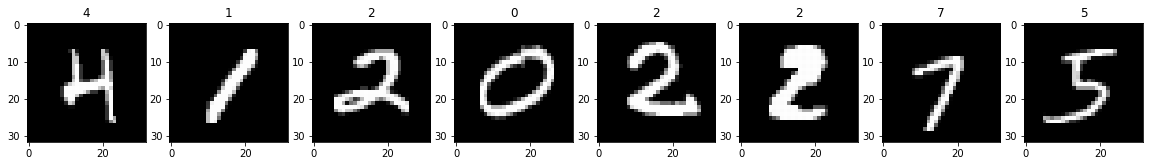

Epoch: 47, Iteration: 224076
Loss: 0.0362, Accuracy: 98.75%
Preds: [6 8 4 5 3 5 1 0]


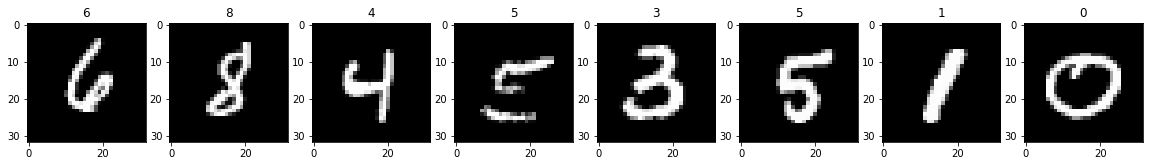

Epoch: 47, Iteration: 225076
Loss: 0.1702, Accuracy: 93.75%
Preds: [5 2 4 0 5 5 1 5]


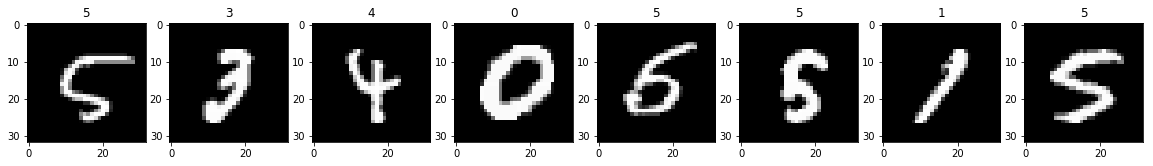

Epoch: 47, Iteration: 226076
Loss: 0.1687, Accuracy: 93.75%
Preds: [1 2 5 0 0 5 2 4]


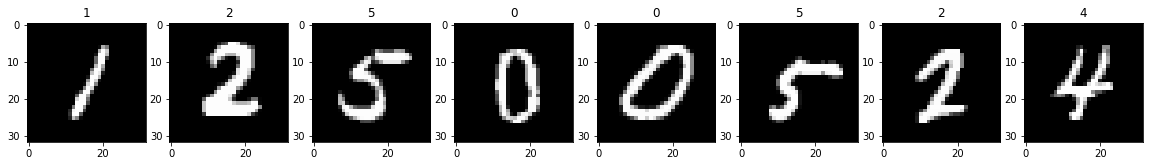

Epoch: 48, Iteration: 226801
Loss: 0.1080, Accuracy: 96.25%
Preds: [1 4 2 3 7 9 2 3]


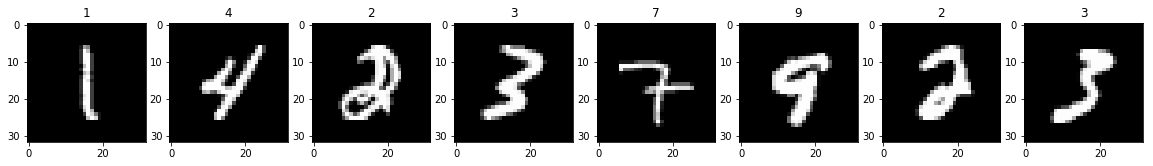

Epoch: 48, Iteration: 227801
Loss: 0.0702, Accuracy: 98.75%
Preds: [0 5 4 5 1 7 5 4]


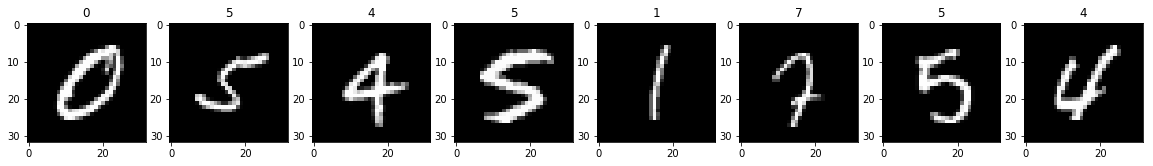

Epoch: 48, Iteration: 228801
Loss: 0.0643, Accuracy: 98.75%
Preds: [7 2 9 1 1 1 9 5]


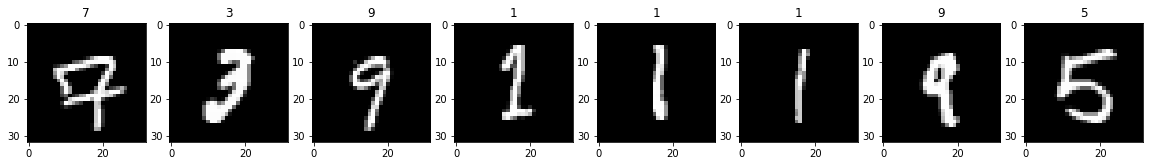

Epoch: 48, Iteration: 229801
Loss: 0.1151, Accuracy: 95.00%
Preds: [2 6 4 9 4 0 4 0]


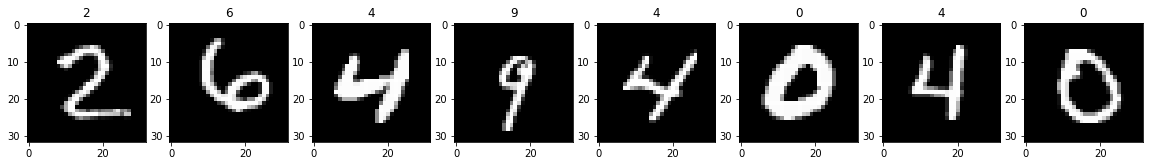

Epoch: 48, Iteration: 230801
Loss: 0.1075, Accuracy: 95.00%
Preds: [4 5 3 2 6 2 9 6]


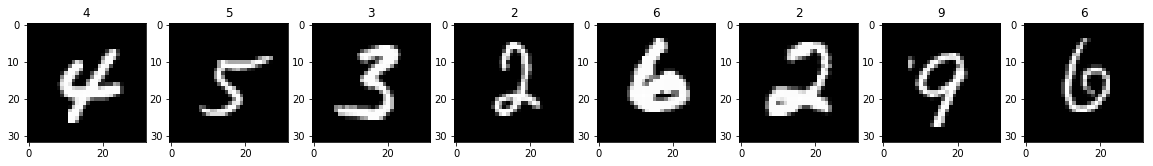

Epoch: 49, Iteration: 231526
Loss: 0.1184, Accuracy: 95.00%
Preds: [0 4 4 2 6 7 9 8]


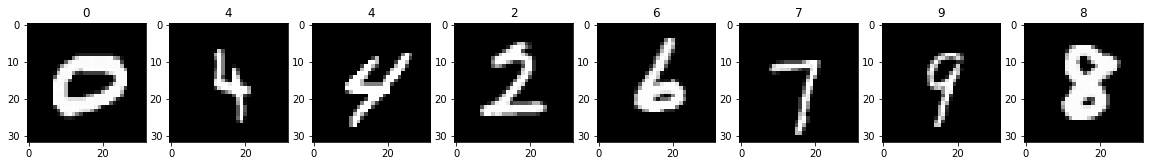

Epoch: 49, Iteration: 232526
Loss: 0.0798, Accuracy: 97.50%
Preds: [9 6 5 9 8 0 3 8]


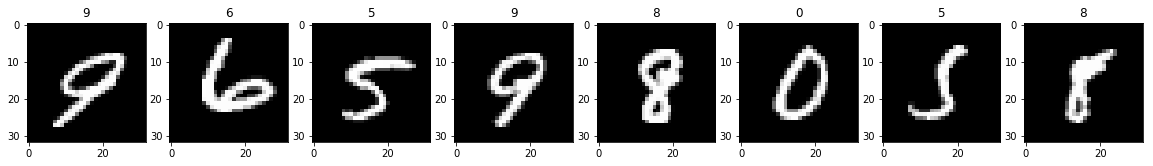

Epoch: 49, Iteration: 233526
Loss: 0.1213, Accuracy: 97.50%
Preds: [8 9 9 1 1 8 1 6]


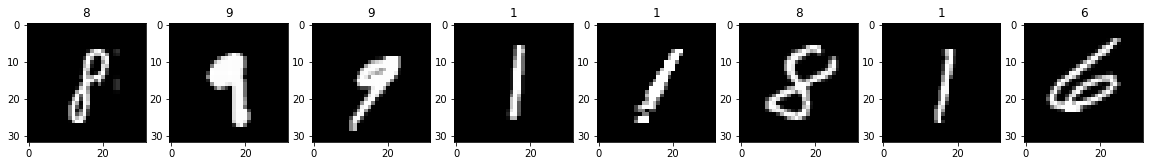

Epoch: 49, Iteration: 234526
Loss: 0.0888, Accuracy: 97.50%
Preds: [5 3 8 4 2 8 2 1]


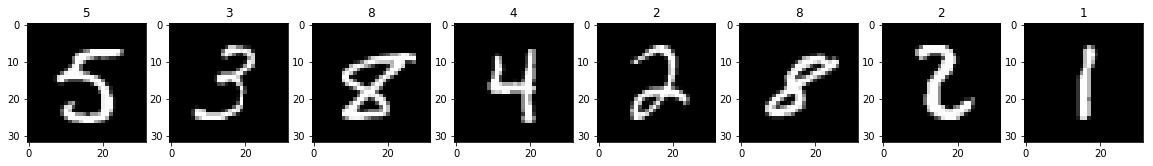

Epoch: 49, Iteration: 235526
Loss: 0.2580, Accuracy: 90.00%
Preds: [9 5 4 8 1 4 7 7]


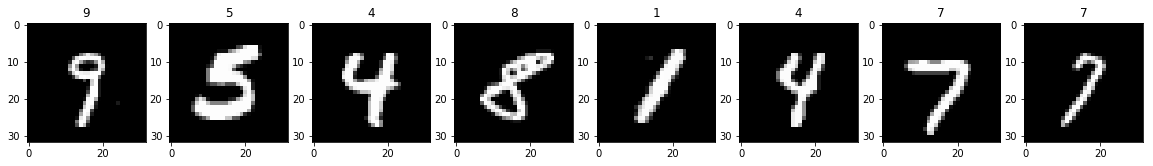

Epoch: 50, Iteration: 236251
Loss: 0.1404, Accuracy: 96.25%
Preds: [0 6 4 4 9 0 5 3]


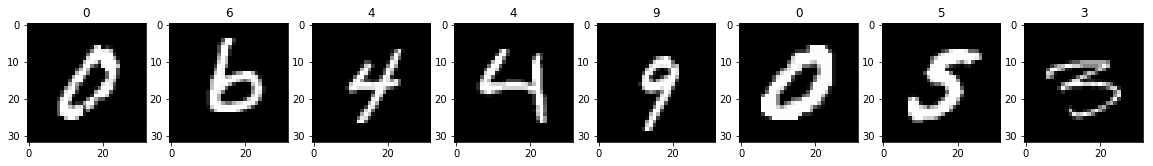

Epoch: 50, Iteration: 237251
Loss: 0.0488, Accuracy: 97.50%
Preds: [5 5 8 6 6 5 3 7]


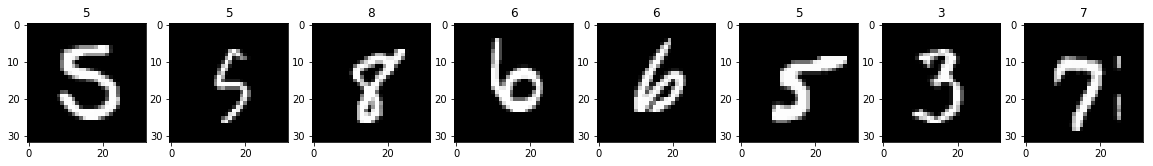

Epoch: 50, Iteration: 238251
Loss: 0.0934, Accuracy: 96.25%
Preds: [6 4 7 6 7 3 4 6]


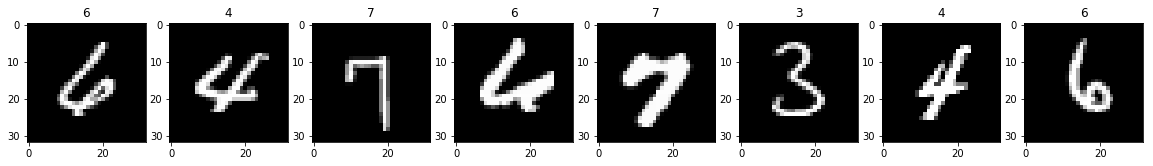

Epoch: 50, Iteration: 239251
Loss: 0.0363, Accuracy: 98.75%
Preds: [6 5 1 0 9 6 2 5]


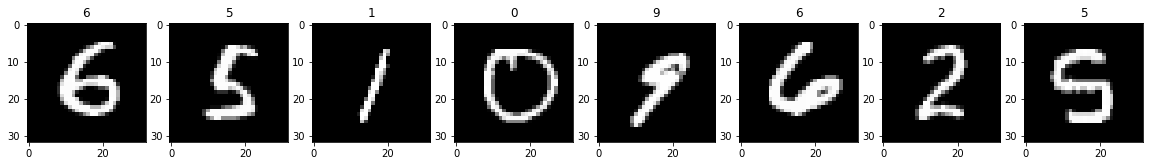

Epoch: 50, Iteration: 240251
Loss: 0.0573, Accuracy: 97.50%
Preds: [8 7 7 4 8 1 5 3]


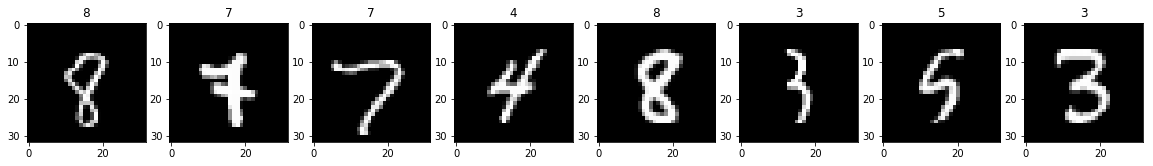

Epoch: 51, Iteration: 240976
Loss: 0.1250, Accuracy: 92.50%
Preds: [2 1 0 0 8 3 8 3]


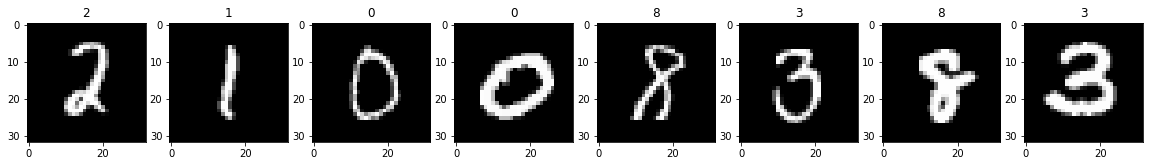

Epoch: 51, Iteration: 241976
Loss: 0.0286, Accuracy: 100.00%
Preds: [1 0 3 3 7 5 1 6]


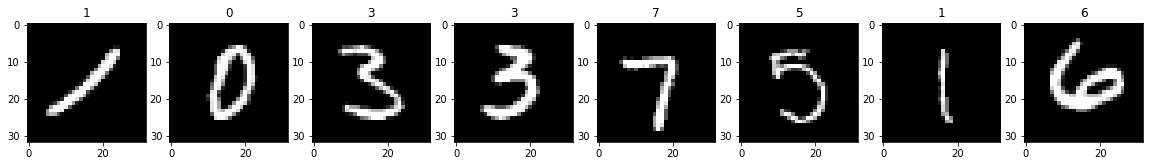

Epoch: 51, Iteration: 242976
Loss: 0.1017, Accuracy: 96.25%
Preds: [9 9 1 5 3 3 8 2]


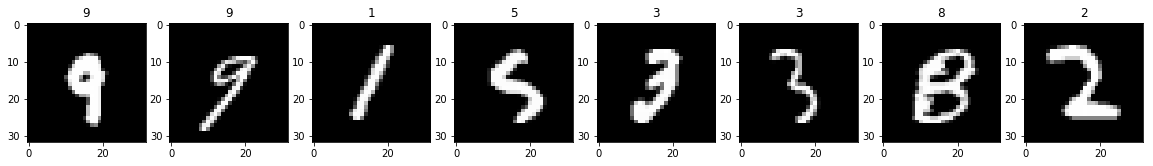

Epoch: 51, Iteration: 243976
Loss: 0.1604, Accuracy: 95.00%
Preds: [9 1 9 2 9 3 9 8]


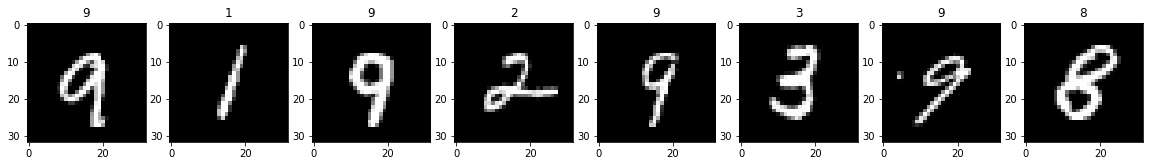

Epoch: 51, Iteration: 244976
Loss: 0.0804, Accuracy: 98.75%
Preds: [6 5 1 4 9 7 3 3]


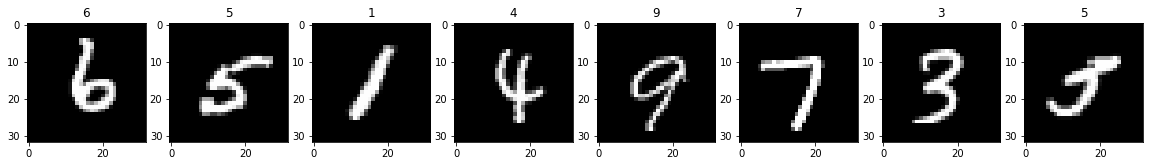

Epoch: 52, Iteration: 245701
Loss: 0.0535, Accuracy: 98.75%
Preds: [6 9 9 5 9 4 6 7]


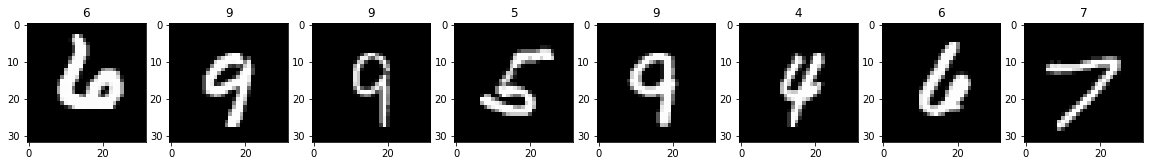

Epoch: 52, Iteration: 246701
Loss: 0.0191, Accuracy: 100.00%
Preds: [4 9 0 3 3 7 9 2]


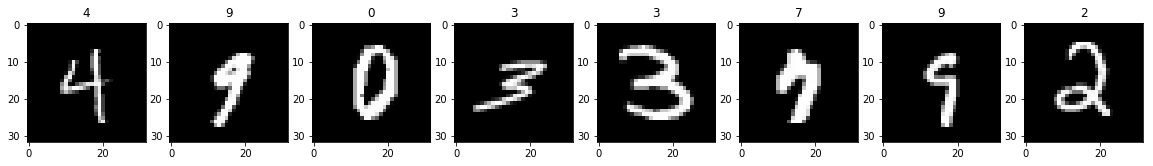

Epoch: 52, Iteration: 247701
Loss: 0.0757, Accuracy: 98.75%
Preds: [8 1 5 6 8 7 7 8]


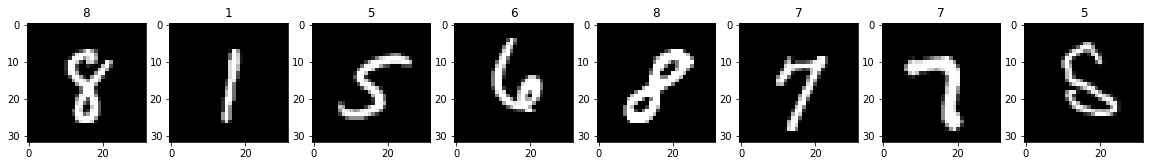

Epoch: 52, Iteration: 248701
Loss: 0.0452, Accuracy: 98.75%
Preds: [5 9 8 5 1 8 0 1]


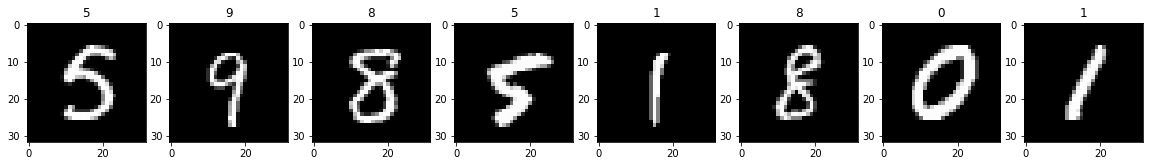

Epoch: 52, Iteration: 249701
Loss: 0.0847, Accuracy: 98.75%
Preds: [7 1 1 3 2 0 2 2]


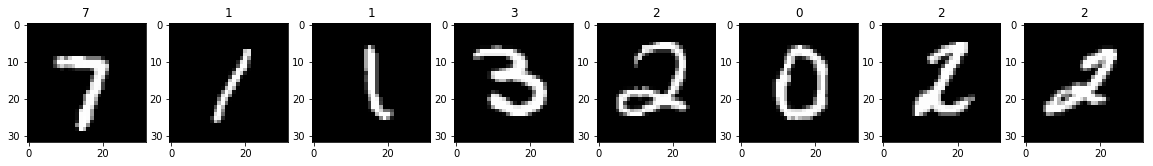

Epoch: 53, Iteration: 250426
Loss: 0.1380, Accuracy: 97.50%
Preds: [3 7 7 1 2 1 4 3]


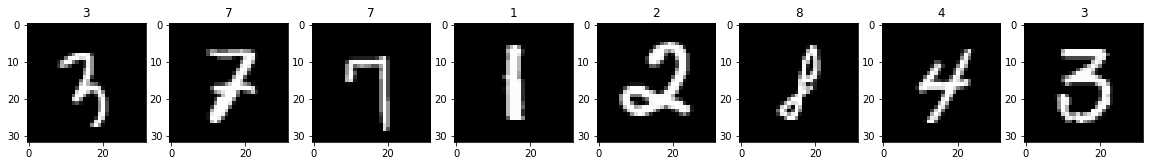

Epoch: 53, Iteration: 251426
Loss: 0.1568, Accuracy: 95.00%
Preds: [1 2 8 8 6 1 9 8]


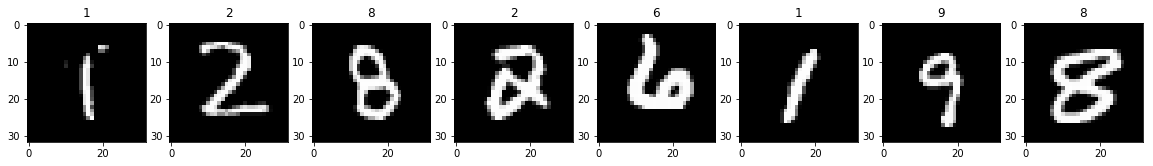

Epoch: 53, Iteration: 252426
Loss: 0.1300, Accuracy: 96.25%
Preds: [7 4 6 2 7 1 1 8]


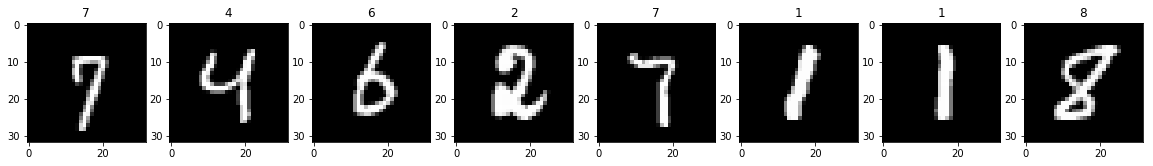

Epoch: 53, Iteration: 253426
Loss: 0.0976, Accuracy: 96.25%
Preds: [9 6 9 8 7 1 9 1]


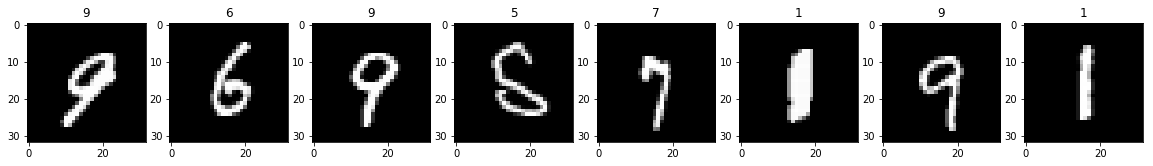

Epoch: 53, Iteration: 254426
Loss: 0.1588, Accuracy: 95.00%
Preds: [1 7 3 3 8 9 4 7]


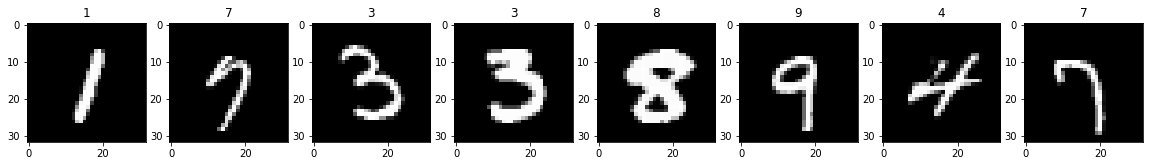

Epoch: 54, Iteration: 255151
Loss: 0.0260, Accuracy: 98.75%
Preds: [7 9 9 1 7 8 3 3]


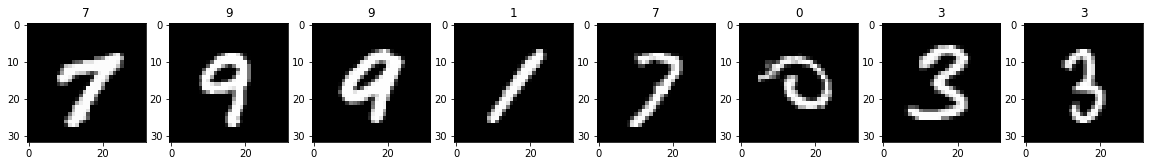

Epoch: 54, Iteration: 256151
Loss: 0.1280, Accuracy: 95.00%
Preds: [0 6 6 5 0 1 3 9]


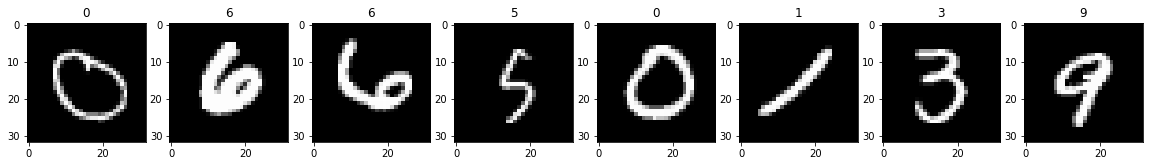

Epoch: 54, Iteration: 257151
Loss: 0.0640, Accuracy: 97.50%
Preds: [3 1 7 9 3 3 3 7]


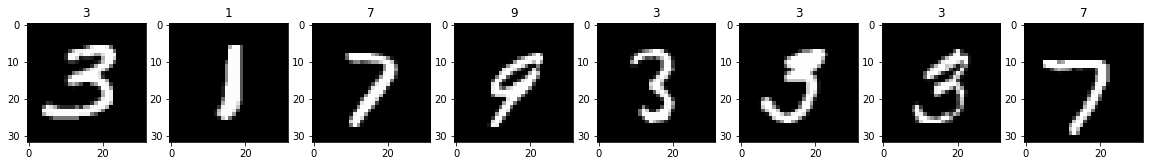

Epoch: 54, Iteration: 258151
Loss: 0.1384, Accuracy: 95.00%
Preds: [7 5 9 4 0 5 4 3]


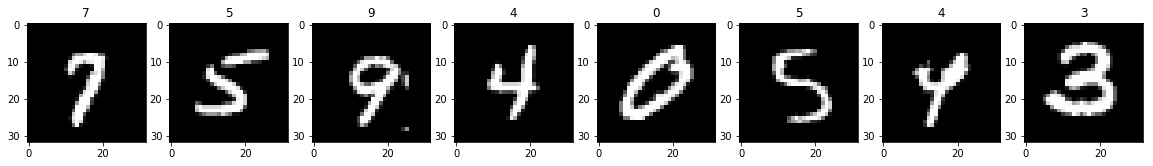

Epoch: 54, Iteration: 259151
Loss: 0.1733, Accuracy: 91.25%
Preds: [7 3 6 6 8 4 0 4]


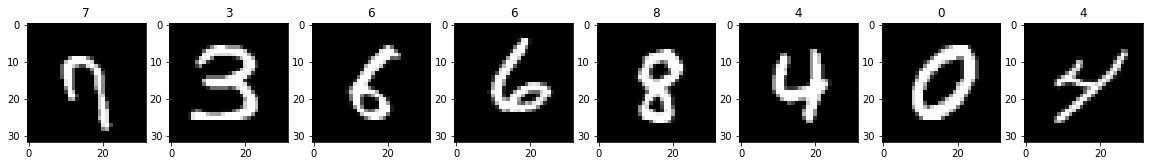

Epoch: 55, Iteration: 259876
Loss: 0.1303, Accuracy: 97.50%
Preds: [9 2 7 8 2 5 2 0]


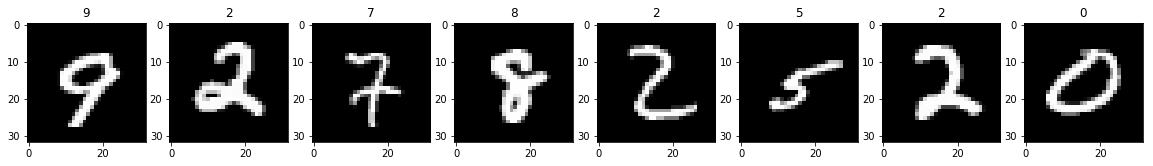

Epoch: 55, Iteration: 260876
Loss: 0.0463, Accuracy: 100.00%
Preds: [1 7 6 9 1 7 6 0]


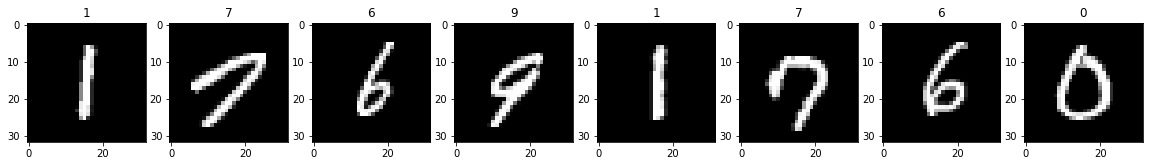

Epoch: 55, Iteration: 261876
Loss: 0.0158, Accuracy: 100.00%
Preds: [3 4 3 3 2 5 4 4]


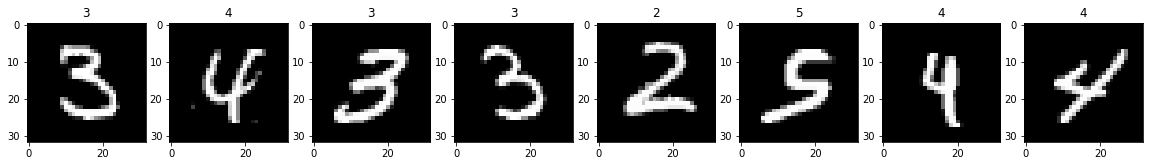

Epoch: 55, Iteration: 262876
Loss: 0.0548, Accuracy: 98.75%
Preds: [8 4 9 8 8 2 6 0]


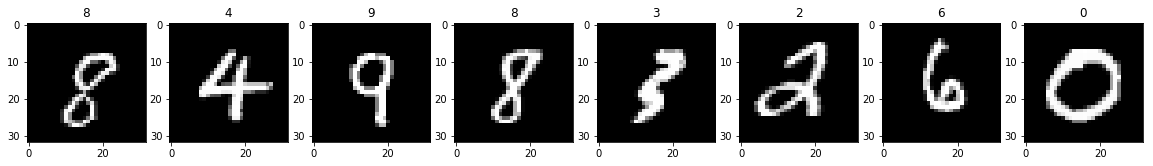

Epoch: 55, Iteration: 263876
Loss: 0.0584, Accuracy: 98.75%
Preds: [3 2 6 1 6 4 3 5]


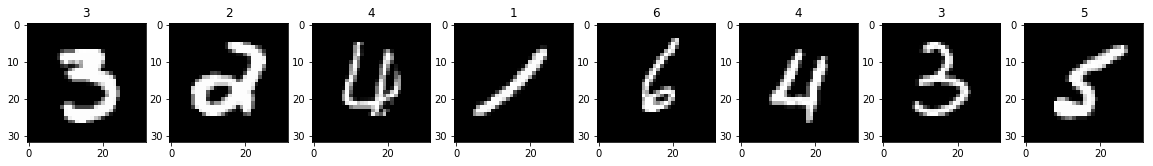

Epoch: 56, Iteration: 264601
Loss: 0.1090, Accuracy: 96.25%
Preds: [9 8 0 1 8 9 8 7]


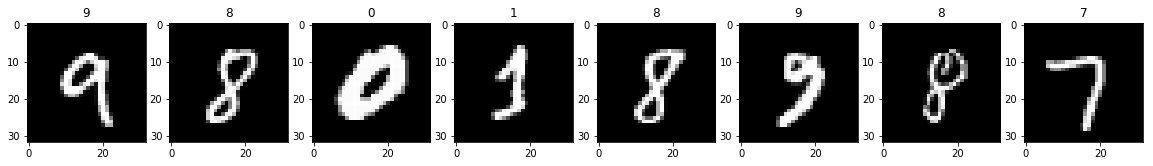

Epoch: 56, Iteration: 265601
Loss: 0.0353, Accuracy: 100.00%
Preds: [9 9 7 7 3 5 9 7]


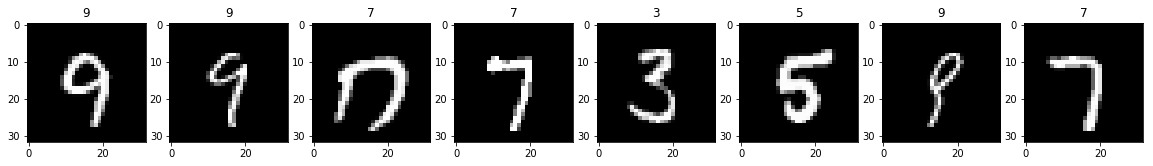

Epoch: 56, Iteration: 266601
Loss: 0.0599, Accuracy: 97.50%
Preds: [6 2 0 2 3 1 0 9]


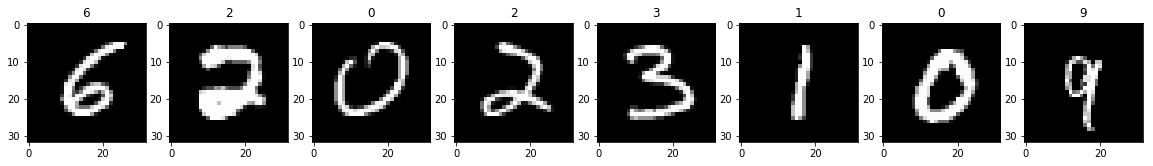

Epoch: 56, Iteration: 267601
Loss: 0.0552, Accuracy: 97.50%
Preds: [5 1 8 6 3 6 1 7]


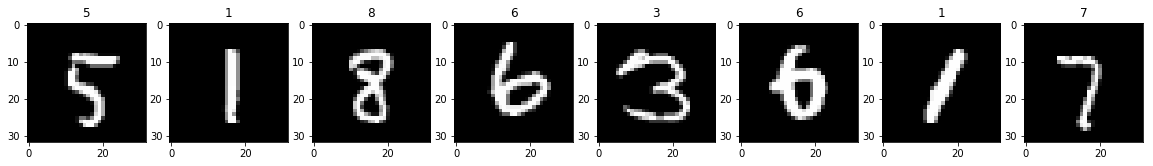

Epoch: 56, Iteration: 268601
Loss: 0.0496, Accuracy: 97.50%
Preds: [8 8 1 1 0 1 9 3]


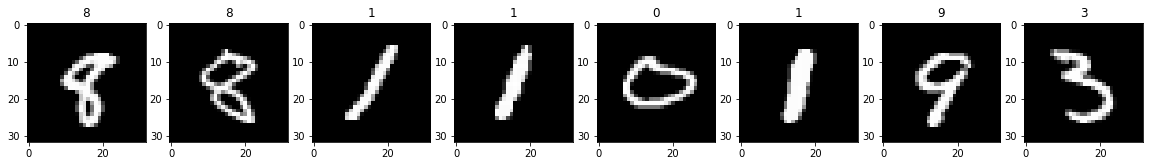

Epoch: 57, Iteration: 269326
Loss: 0.0569, Accuracy: 97.50%
Preds: [8 0 5 1 2 2 3 1]


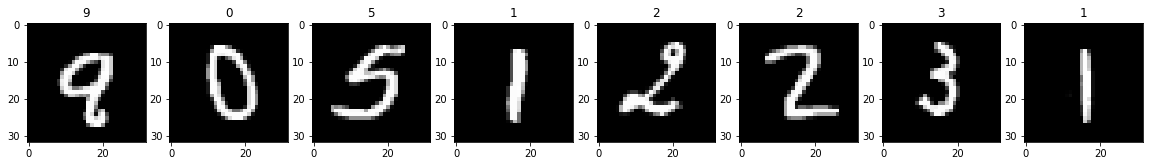

Epoch: 57, Iteration: 270326
Loss: 0.1438, Accuracy: 96.25%
Preds: [3 7 9 8 7 7 3 2]


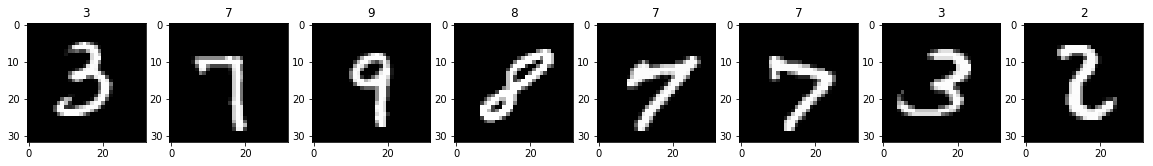

Epoch: 57, Iteration: 271326
Loss: 0.1147, Accuracy: 96.25%
Preds: [3 8 4 1 4 3 4 6]


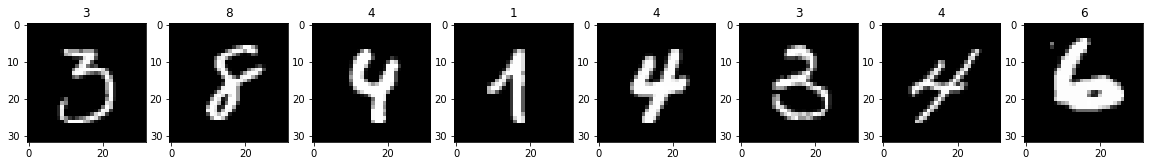

Epoch: 57, Iteration: 272326
Loss: 0.1964, Accuracy: 95.00%
Preds: [9 2 3 4 9 3 9 0]


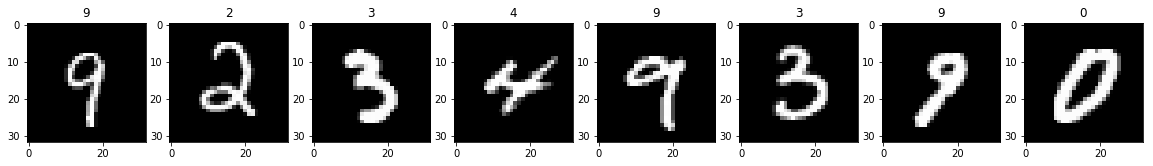

Epoch: 57, Iteration: 273326
Loss: 0.1444, Accuracy: 96.25%
Preds: [6 4 1 5 5 7 9 9]


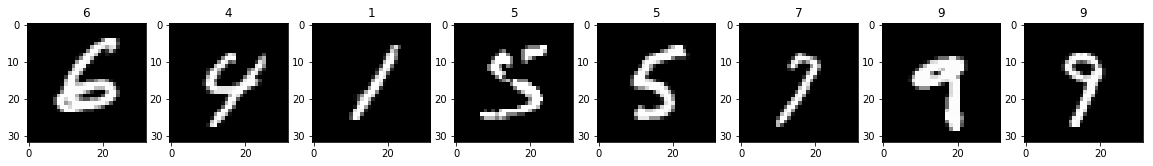

Epoch: 58, Iteration: 274051
Loss: 0.0543, Accuracy: 97.50%
Preds: [2 6 5 2 9 9 4 6]


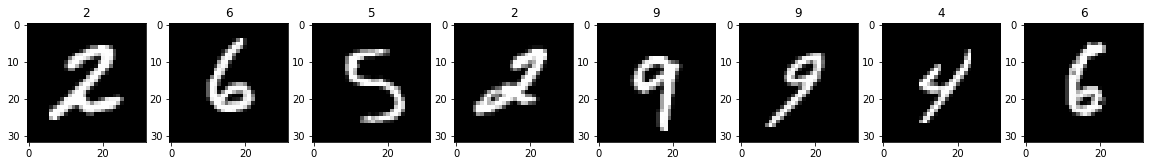

Epoch: 58, Iteration: 275051
Loss: 0.0700, Accuracy: 97.50%
Preds: [2 1 6 4 9 9 3 0]


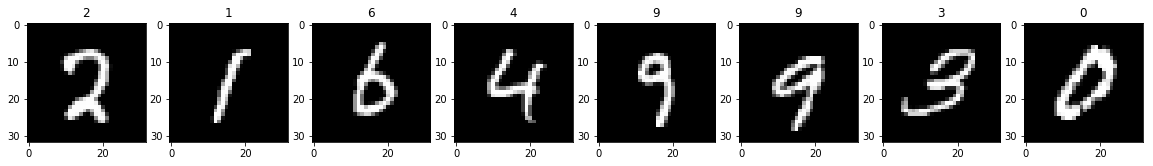

Epoch: 58, Iteration: 276051
Loss: 0.0873, Accuracy: 95.00%
Preds: [7 4 7 1 8 2 4 4]


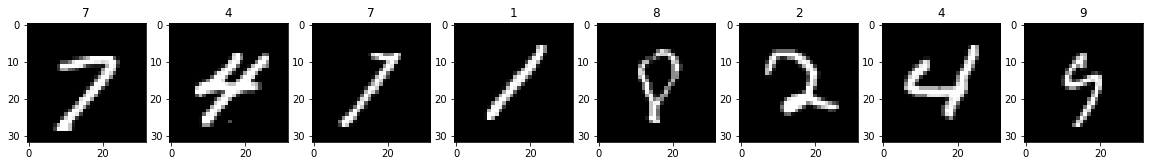

Epoch: 58, Iteration: 277051
Loss: 0.0474, Accuracy: 97.50%
Preds: [2 8 3 6 0 4 4 9]


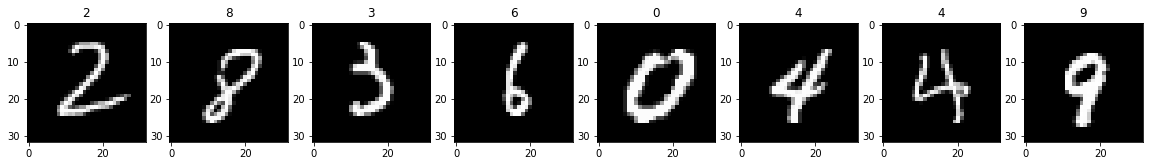

Epoch: 58, Iteration: 278051
Loss: 0.1038, Accuracy: 96.25%
Preds: [1 4 6 4 6 0 0 4]


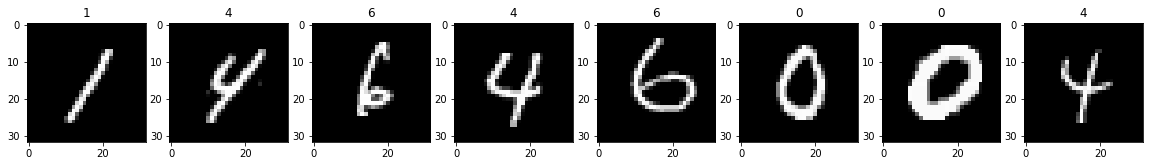

Epoch: 59, Iteration: 278776
Loss: 0.0137, Accuracy: 100.00%
Preds: [5 8 5 6 3 9 4 9]


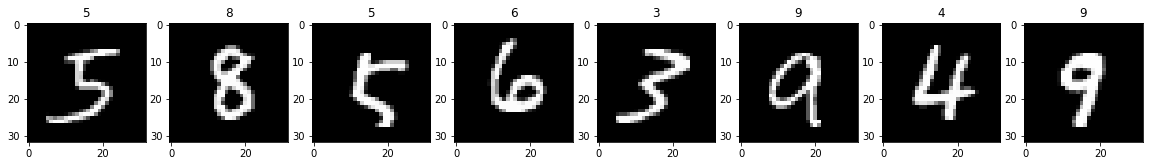

Epoch: 59, Iteration: 279776
Loss: 0.0253, Accuracy: 98.75%
Preds: [0 8 5 6 4 0 0 3]


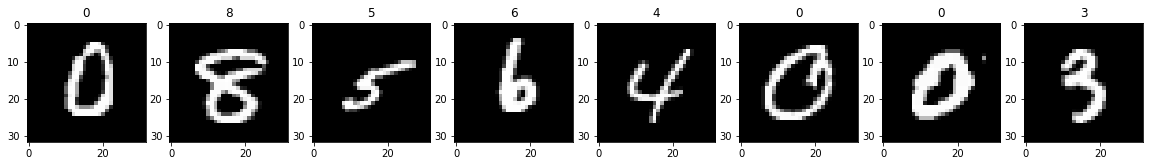

Epoch: 59, Iteration: 280776
Loss: 0.0804, Accuracy: 98.75%
Preds: [3 2 1 2 6 5 8 5]


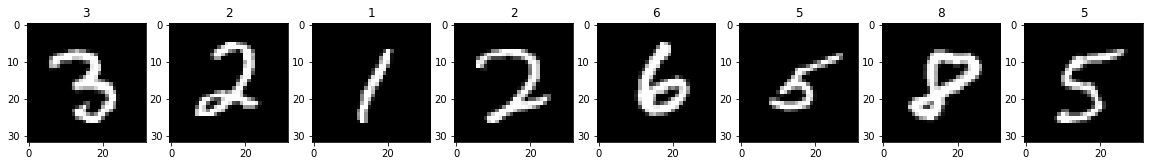

Epoch: 59, Iteration: 281776
Loss: 0.1404, Accuracy: 97.50%
Preds: [4 1 9 5 0 7 4 1]


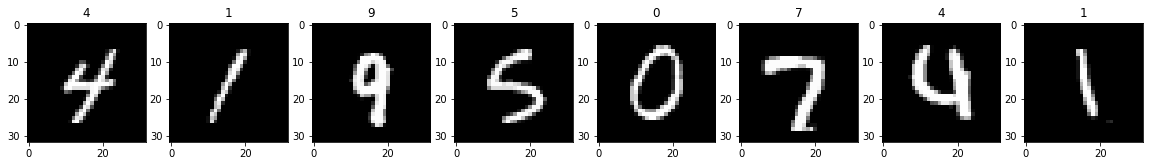

Epoch: 59, Iteration: 282776
Loss: 0.0720, Accuracy: 97.50%
Preds: [9 2 7 0 3 5 0 8]


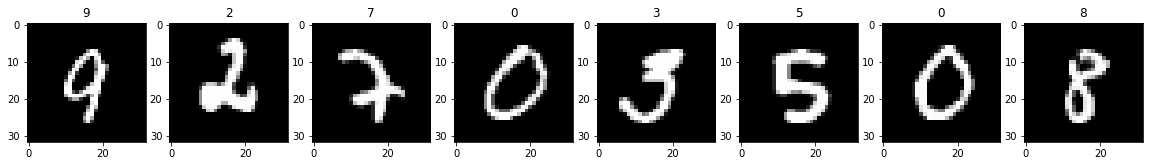

Epoch: 60, Iteration: 283501
Loss: 0.0909, Accuracy: 97.50%
Preds: [3 4 2 5 0 0 1 9]


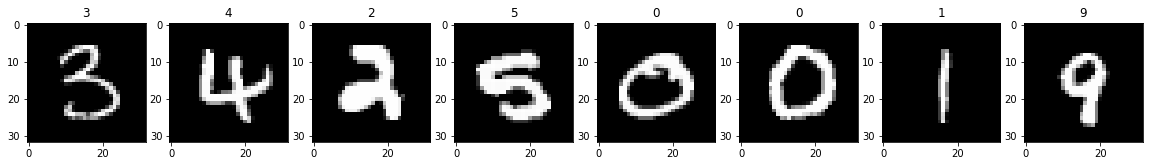

Epoch: 60, Iteration: 284501
Loss: 0.0590, Accuracy: 97.50%
Preds: [7 8 9 2 8 8 8 2]


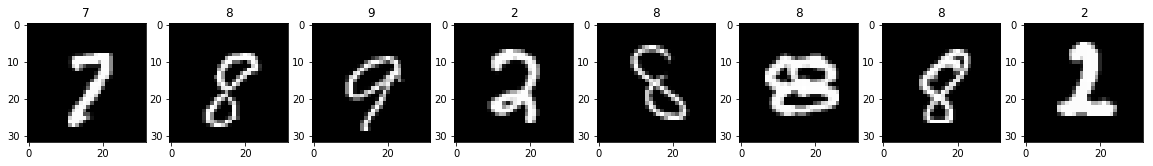

Epoch: 60, Iteration: 285501
Loss: 0.0354, Accuracy: 100.00%
Preds: [6 6 5 7 2 6 2 6]


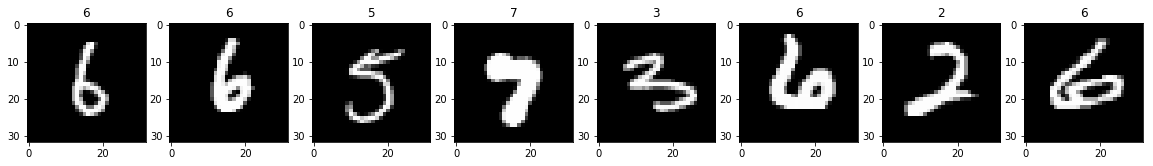

Epoch: 60, Iteration: 286501
Loss: 0.1329, Accuracy: 95.00%
Preds: [6 3 0 0 8 9 8 2]


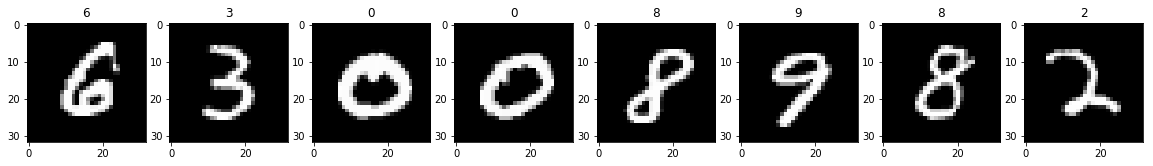

Epoch: 60, Iteration: 287501
Loss: 0.1108, Accuracy: 95.00%
Preds: [2 9 7 6 8 4 1 5]


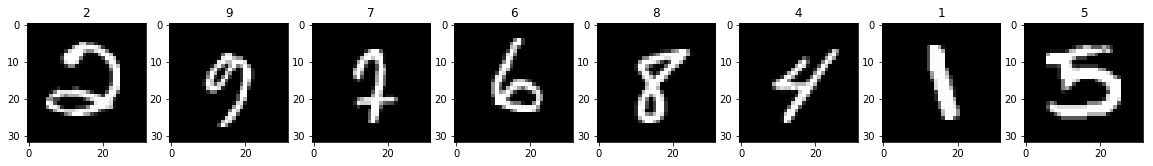

Epoch: 61, Iteration: 288226
Loss: 0.1194, Accuracy: 95.00%
Preds: [5 0 3 8 4 7 7 6]


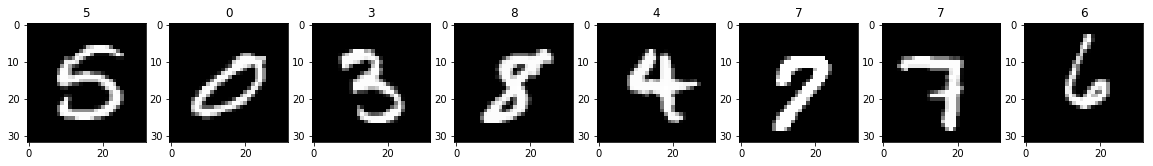

Epoch: 61, Iteration: 289226
Loss: 0.0971, Accuracy: 97.50%
Preds: [4 8 2 0 9 7 0 2]


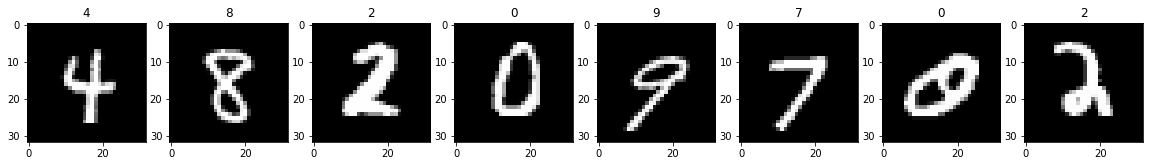

Epoch: 61, Iteration: 290226
Loss: 0.0369, Accuracy: 98.75%
Preds: [6 4 8 3 9 8 3 0]


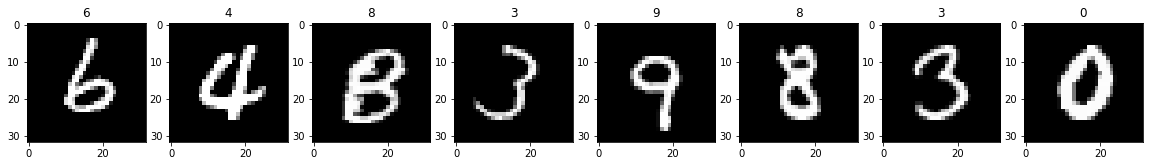

Epoch: 61, Iteration: 291226
Loss: 0.0948, Accuracy: 96.25%
Preds: [9 2 4 5 2 3 9 1]


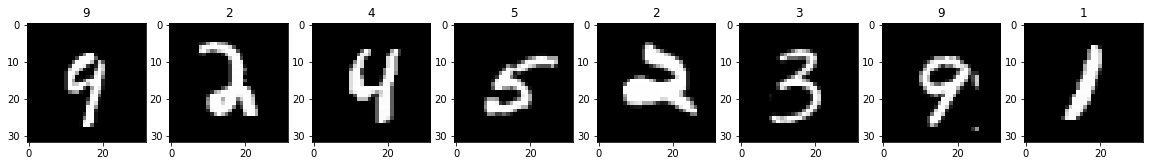

Epoch: 61, Iteration: 292226
Loss: 0.0877, Accuracy: 97.50%
Preds: [4 1 1 9 0 9 6 0]


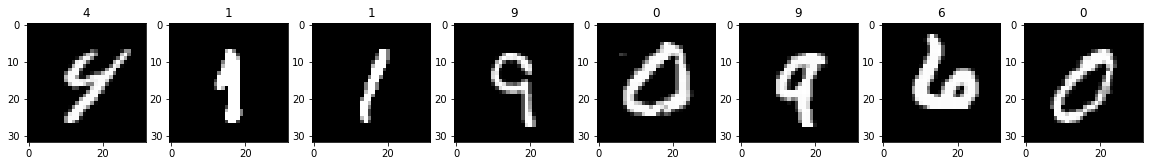

Epoch: 62, Iteration: 292951
Loss: 0.1192, Accuracy: 96.25%
Preds: [7 2 1 4 2 5 8 3]


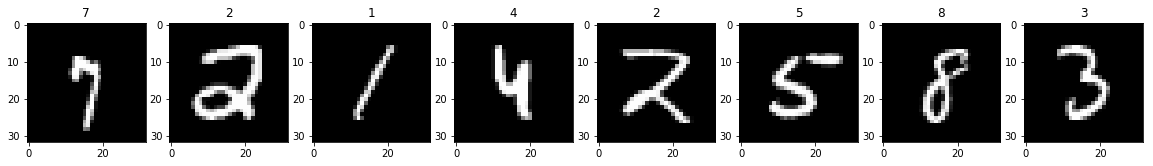

Epoch: 62, Iteration: 293951
Loss: 0.1992, Accuracy: 95.00%
Preds: [1 9 9 2 6 5 2 8]


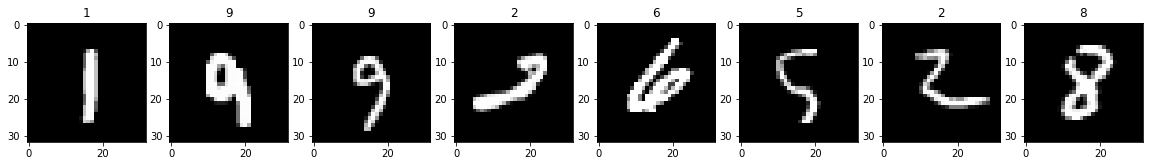

Epoch: 62, Iteration: 294951
Loss: 0.0253, Accuracy: 100.00%
Preds: [3 5 0 7 5 2 3 4]


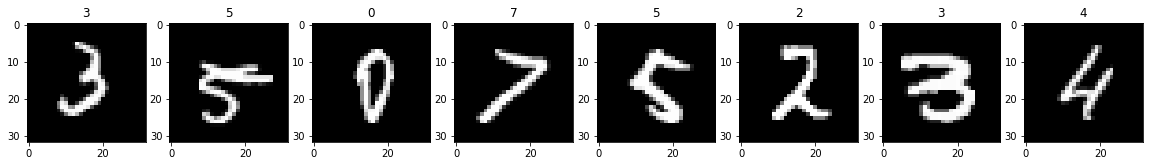

Epoch: 62, Iteration: 295951
Loss: 0.0425, Accuracy: 98.75%
Preds: [2 7 0 5 0 5 8 8]


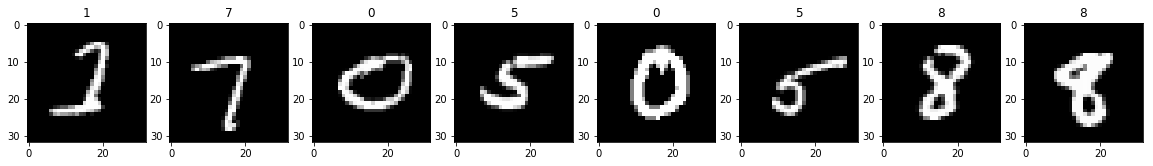

Epoch: 62, Iteration: 296951
Loss: 0.0626, Accuracy: 96.25%
Preds: [4 9 4 0 4 7 5 2]


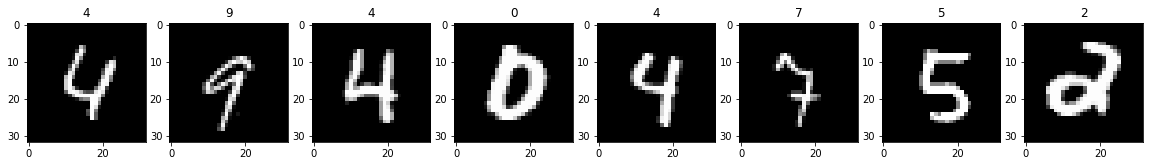

Epoch: 63, Iteration: 297676
Loss: 0.0210, Accuracy: 100.00%
Preds: [8 7 6 8 7 4 3 2]


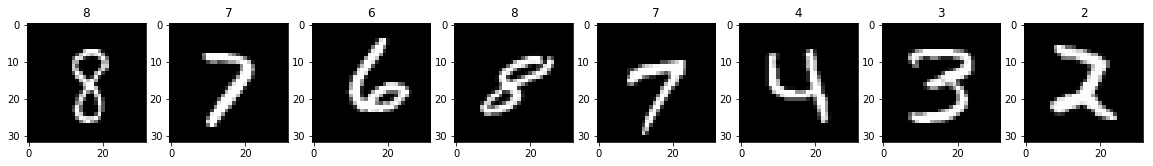

Epoch: 63, Iteration: 298676
Loss: 0.2177, Accuracy: 92.50%
Preds: [7 7 5 9 2 0 3 1]


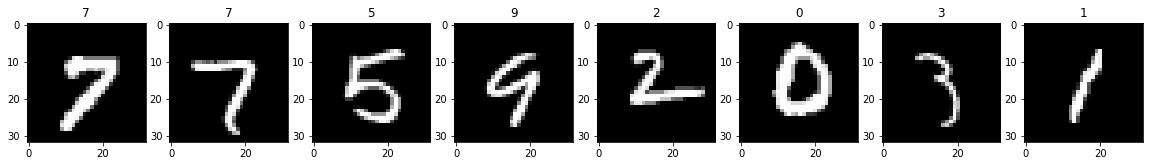

Epoch: 63, Iteration: 299676
Loss: 0.0910, Accuracy: 97.50%
Preds: [6 7 5 7 9 0 7 5]


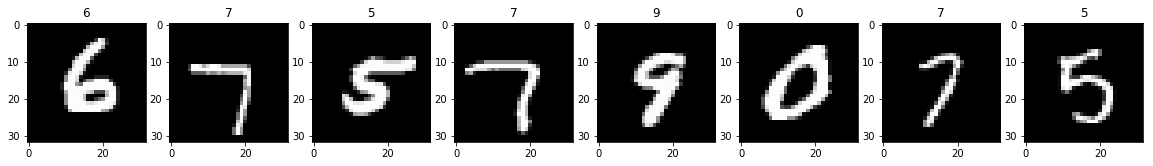

Epoch: 63, Iteration: 300676
Loss: 0.0566, Accuracy: 97.50%
Preds: [5 2 0 4 3 5 2 2]


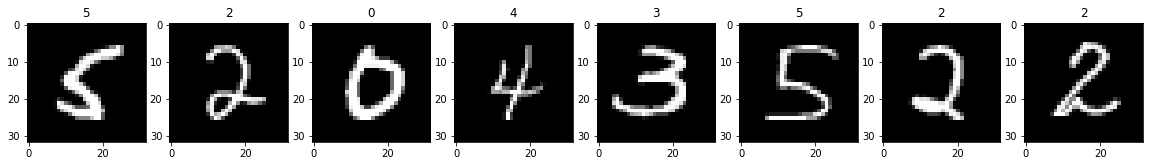

Epoch: 63, Iteration: 301676
Loss: 0.0218, Accuracy: 100.00%
Preds: [6 7 0 5 3 6 2 8]


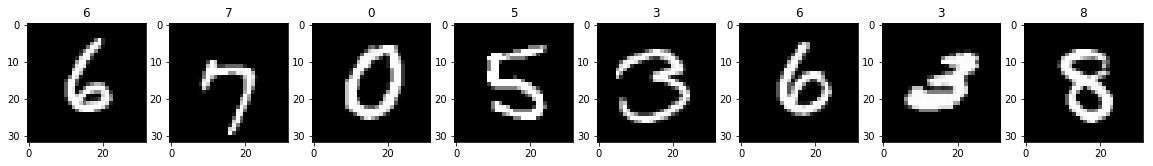

Epoch: 64, Iteration: 302401
Loss: 0.1132, Accuracy: 96.25%
Preds: [7 9 8 5 8 3 0 0]


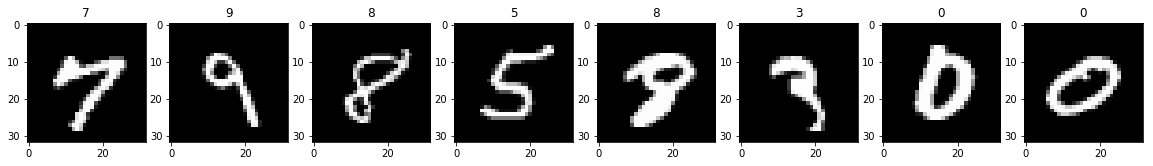

Epoch: 64, Iteration: 303401
Loss: 0.0813, Accuracy: 96.25%
Preds: [2 9 8 9 5 3 0 0]


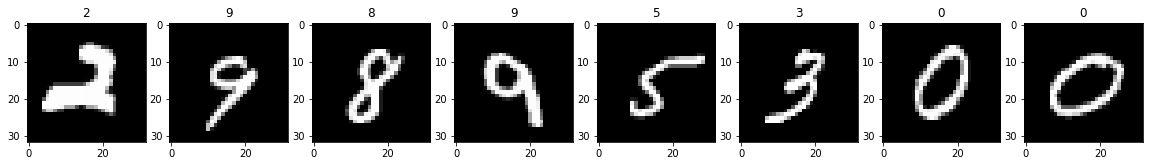

Epoch: 64, Iteration: 304401
Loss: 0.1038, Accuracy: 96.25%
Preds: [3 0 8 7 8 1 1 3]


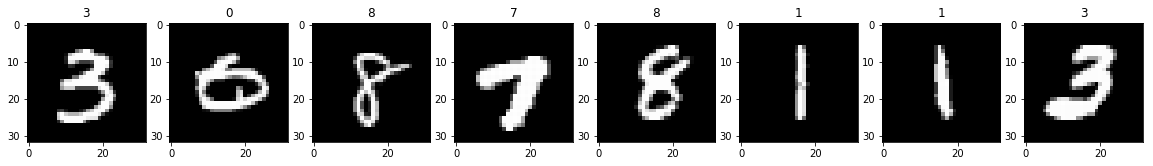

Epoch: 64, Iteration: 305401
Loss: 0.1068, Accuracy: 96.25%
Preds: [1 3 4 4 4 6 4 5]


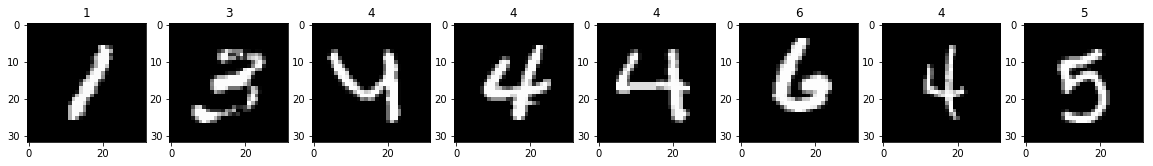

Epoch: 64, Iteration: 306401
Loss: 0.0744, Accuracy: 95.00%
Preds: [0 2 1 2 2 9 7 2]


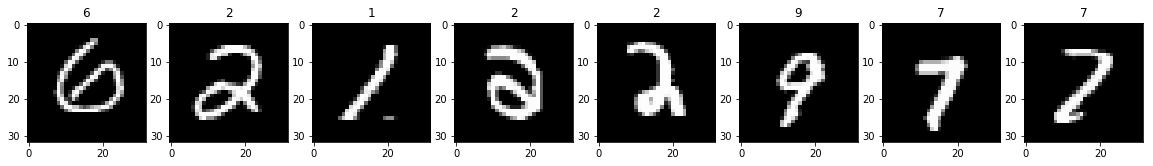

Epoch: 65, Iteration: 307126
Loss: 0.1627, Accuracy: 93.75%
Preds: [4 4 6 8 1 2 5 4]


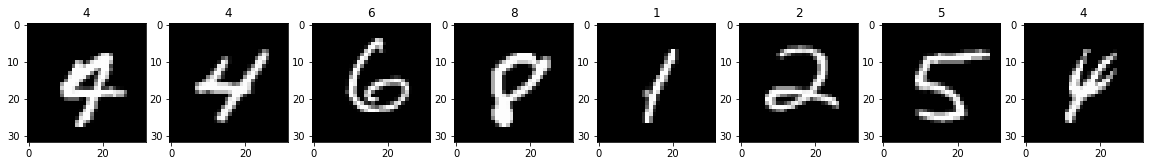

Epoch: 65, Iteration: 308126
Loss: 0.0717, Accuracy: 96.25%
Preds: [9 8 7 1 6 1 3 8]


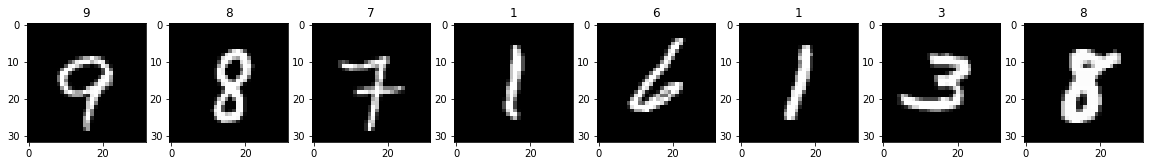

Epoch: 65, Iteration: 309126
Loss: 0.0267, Accuracy: 98.75%
Preds: [7 3 1 1 9 3 0 0]


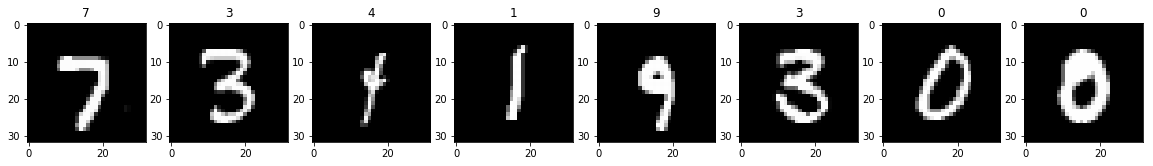

Epoch: 65, Iteration: 310126
Loss: 0.0842, Accuracy: 96.25%
Preds: [2 0 2 4 3 8 4 4]


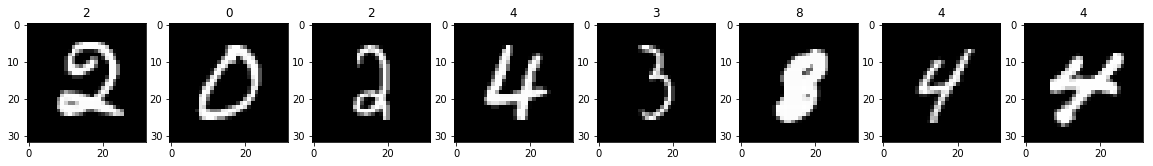

Epoch: 65, Iteration: 311126
Loss: 0.0731, Accuracy: 97.50%
Preds: [5 0 0 6 0 7 2 1]


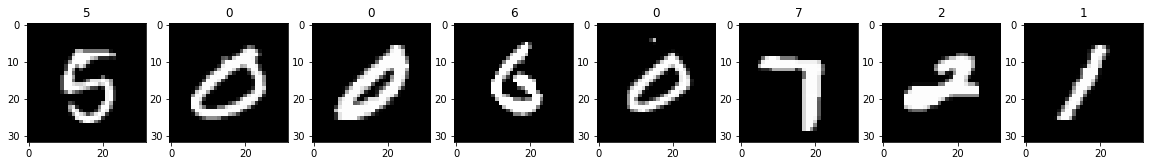

Epoch: 66, Iteration: 311851
Loss: 0.2883, Accuracy: 91.25%
Preds: [7 1 9 8 0 8 5 1]


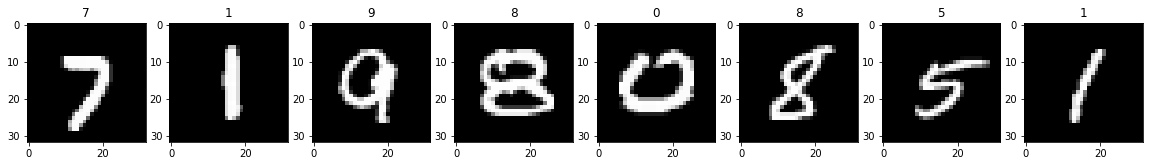

Epoch: 66, Iteration: 312851
Loss: 0.0946, Accuracy: 96.25%
Preds: [8 1 1 8 1 0 3 5]


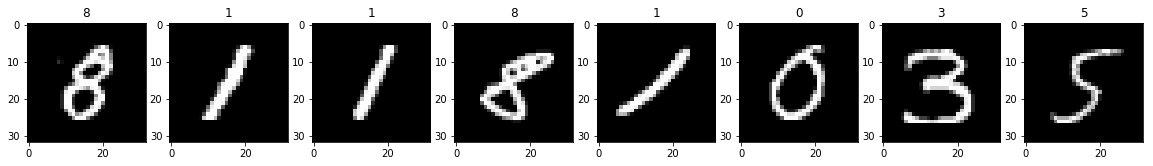

Epoch: 66, Iteration: 313851
Loss: 0.2117, Accuracy: 95.00%
Preds: [6 9 9 7 6 5 3 9]


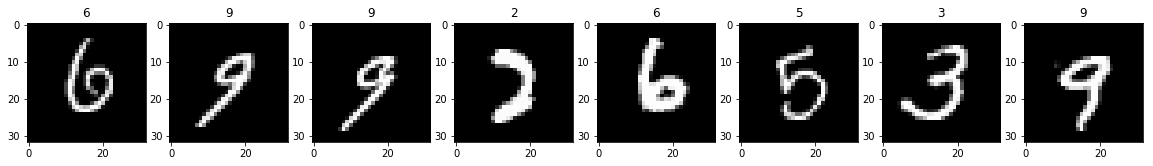

Epoch: 66, Iteration: 314851
Loss: 0.0588, Accuracy: 97.50%
Preds: [3 0 3 1 5 8 7 9]


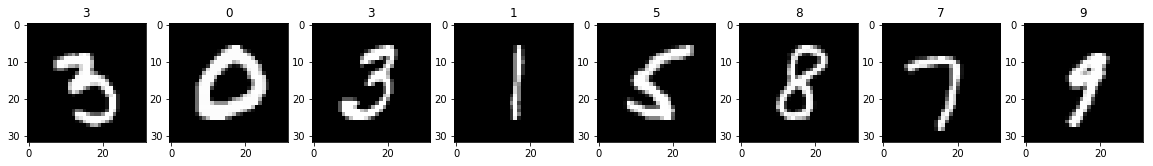

Epoch: 66, Iteration: 315851
Loss: 0.0256, Accuracy: 98.75%
Preds: [1 1 4 5 9 7 7 7]


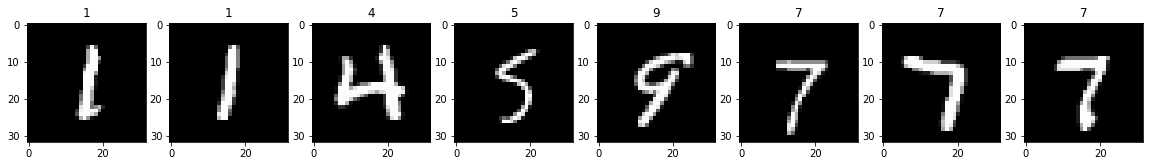

Epoch: 67, Iteration: 316576
Loss: 0.0030, Accuracy: 100.00%
Preds: [7 6 8 6 2 3 0 3]


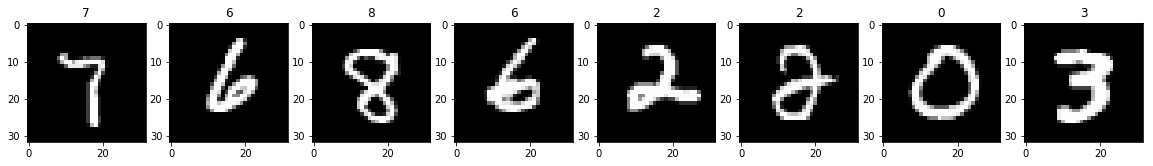

Epoch: 67, Iteration: 317576
Loss: 0.1377, Accuracy: 96.25%
Preds: [2 7 1 5 3 5 8 4]


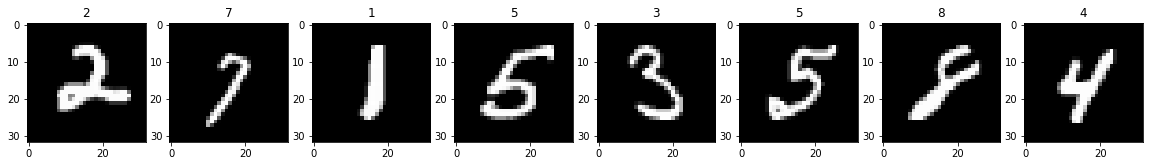

Epoch: 67, Iteration: 318576
Loss: 0.0301, Accuracy: 98.75%
Preds: [0 3 8 8 3 0 5 5]


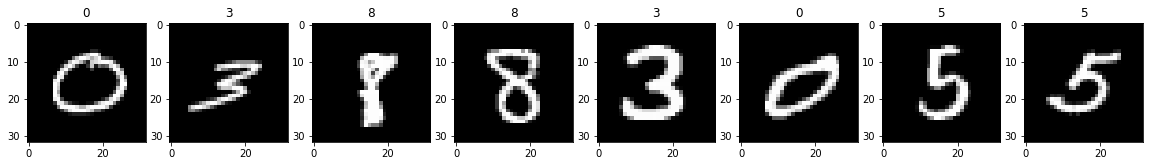

Epoch: 67, Iteration: 319576
Loss: 0.2132, Accuracy: 92.50%
Preds: [4 5 5 2 6 5 9 0]


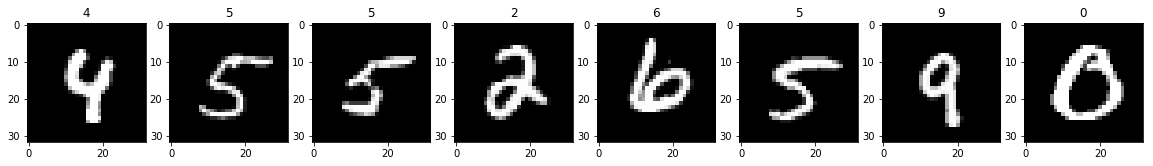

Epoch: 67, Iteration: 320576
Loss: 0.0226, Accuracy: 100.00%
Preds: [2 0 2 0 3 7 7 3]


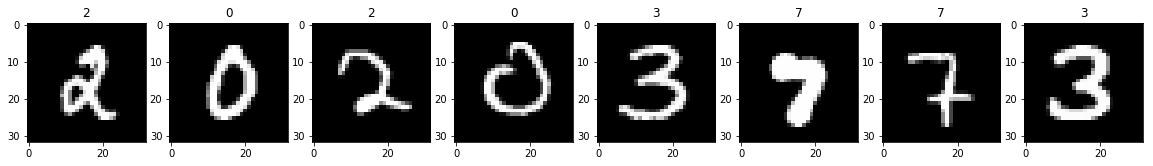

Epoch: 68, Iteration: 321301
Loss: 0.0234, Accuracy: 100.00%
Preds: [9 9 5 6 6 0 9 7]


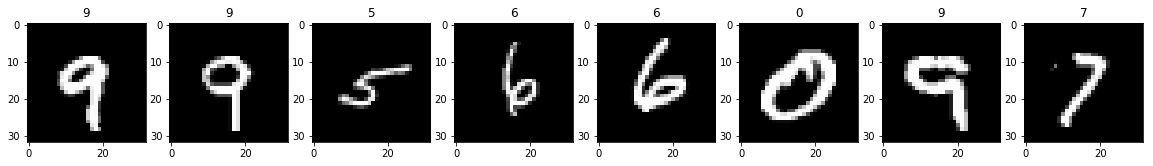

Epoch: 68, Iteration: 322301
Loss: 0.0318, Accuracy: 98.75%
Preds: [0 7 2 7 7 9 3 2]


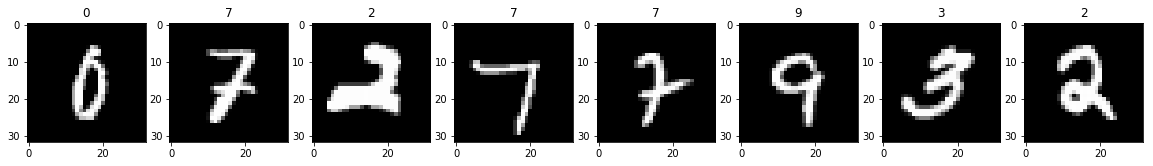

Epoch: 68, Iteration: 323301
Loss: 0.0792, Accuracy: 95.00%
Preds: [1 6 0 8 2 5 1 7]


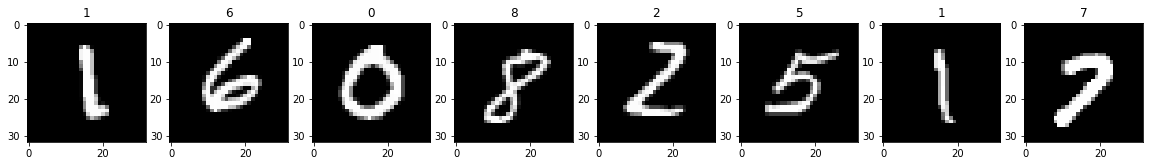

Epoch: 68, Iteration: 324301
Loss: 0.0474, Accuracy: 97.50%
Preds: [1 4 9 2 0 5 5 6]


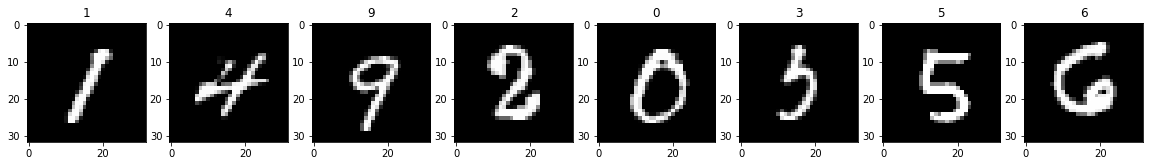

Epoch: 68, Iteration: 325301
Loss: 0.1718, Accuracy: 93.75%
Preds: [0 9 0 3 1 0 9 7]


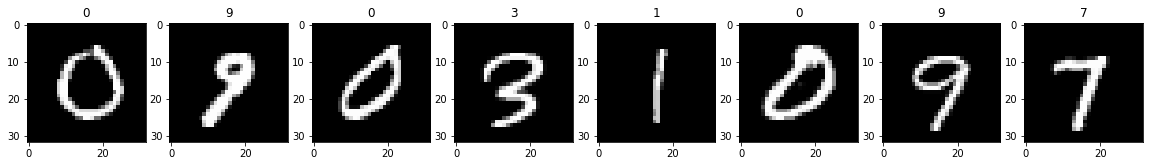

Epoch: 69, Iteration: 326026
Loss: 0.0300, Accuracy: 98.75%
Preds: [8 3 1 6 7 2 9 3]


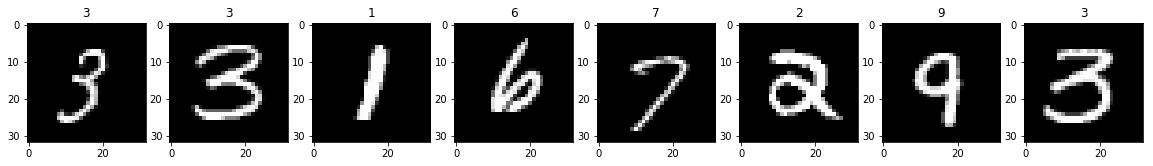

Epoch: 69, Iteration: 327026
Loss: 0.0665, Accuracy: 96.25%
Preds: [1 7 2 1 0 4 9 9]


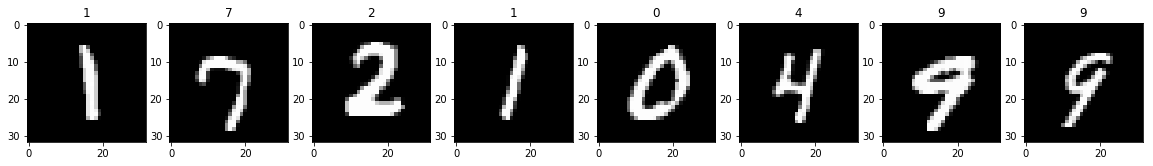

Epoch: 69, Iteration: 328026
Loss: 0.1217, Accuracy: 97.50%
Preds: [5 3 9 5 1 5 6 9]


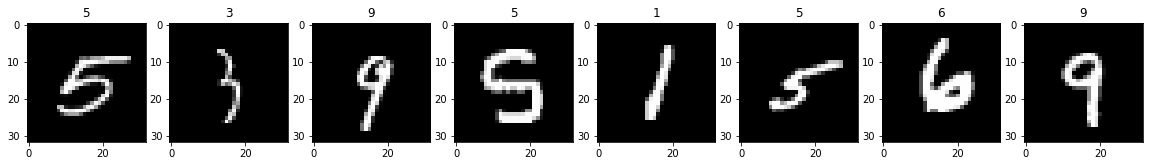

Epoch: 69, Iteration: 329026
Loss: 0.1240, Accuracy: 95.00%
Preds: [2 3 5 0 0 9 6 2]


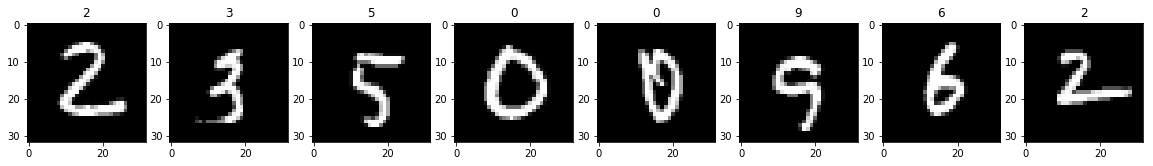

Epoch: 69, Iteration: 330026
Loss: 0.1097, Accuracy: 96.25%
Preds: [4 7 0 6 2 4 2 8]


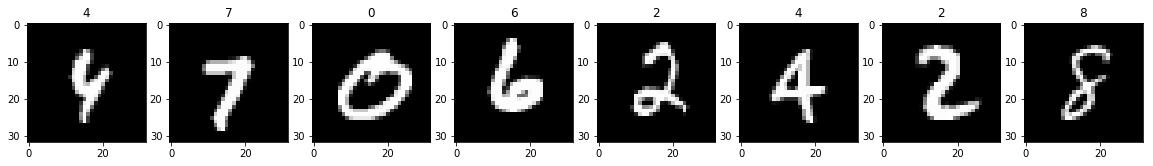

Epoch: 70, Iteration: 330751
Loss: 0.1648, Accuracy: 95.00%
Preds: [8 8 8 7 4 5 9 7]


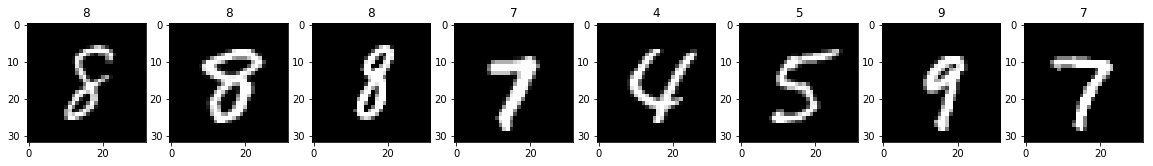

Epoch: 70, Iteration: 331751
Loss: 0.0068, Accuracy: 100.00%
Preds: [8 8 1 4 0 2 9 5]


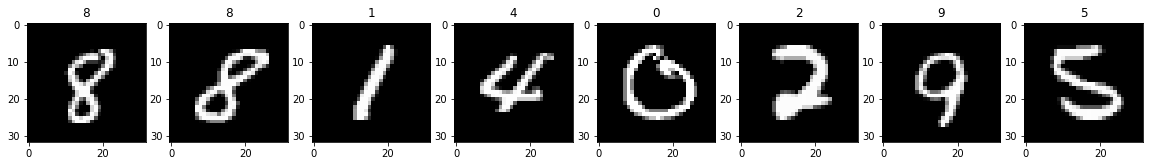

Epoch: 70, Iteration: 332751
Loss: 0.0201, Accuracy: 98.75%
Preds: [5 0 9 9 9 1 6 1]


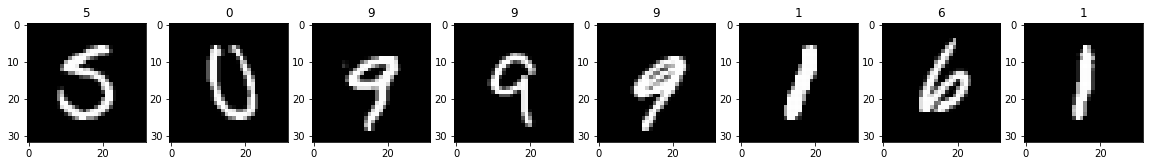

Epoch: 70, Iteration: 333751
Loss: 0.0541, Accuracy: 98.75%
Preds: [1 6 8 8 9 6 0 6]


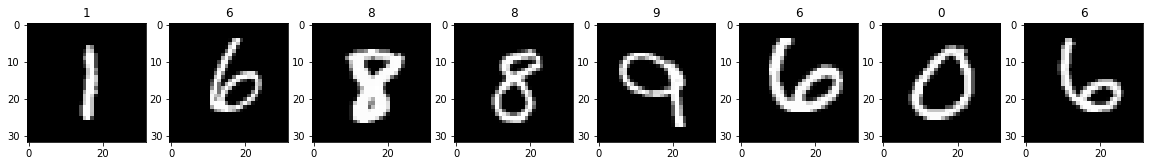

Epoch: 70, Iteration: 334751
Loss: 0.0903, Accuracy: 96.25%
Preds: [0 9 3 9 1 4 5 0]


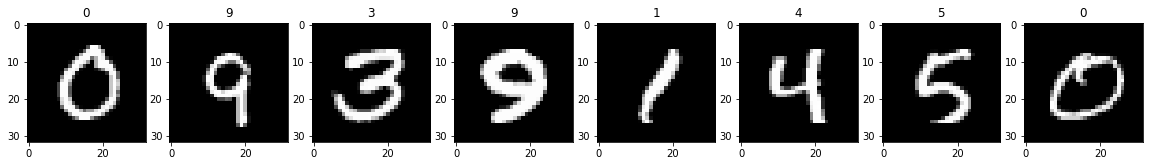

Epoch: 71, Iteration: 335476
Loss: 0.0311, Accuracy: 98.75%
Preds: [8 9 3 1 3 0 3 0]


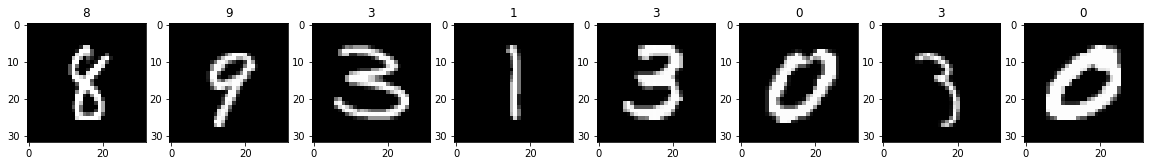

Epoch: 71, Iteration: 336476
Loss: 0.0938, Accuracy: 96.25%
Preds: [3 9 7 5 3 5 1 2]


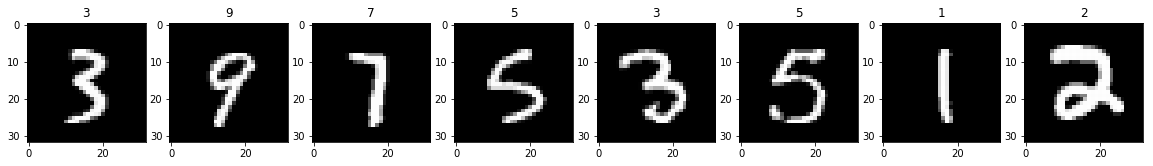

Epoch: 71, Iteration: 337476
Loss: 0.1156, Accuracy: 96.25%
Preds: [6 5 7 3 6 1 4 5]


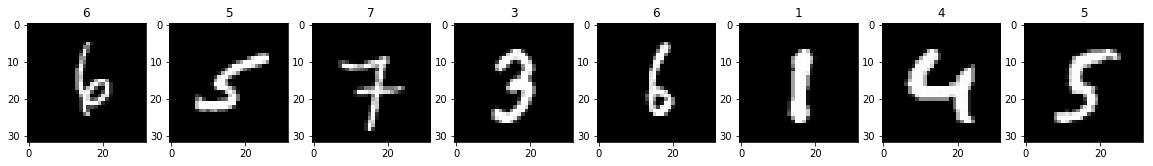

Epoch: 71, Iteration: 338476
Loss: 0.0665, Accuracy: 98.75%
Preds: [0 8 6 5 0 8 6 3]


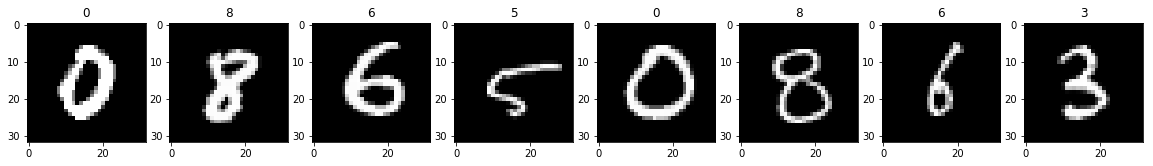

Epoch: 71, Iteration: 339476
Loss: 0.0375, Accuracy: 98.75%
Preds: [1 8 4 1 7 5 9 9]


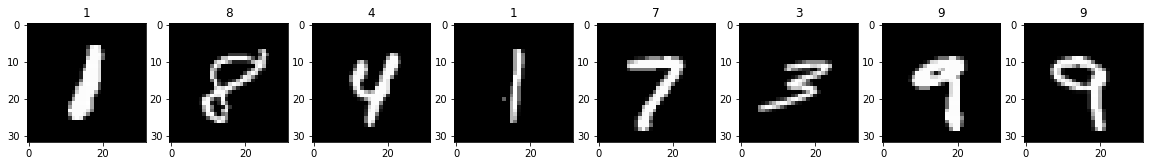

Epoch: 72, Iteration: 340201
Loss: 0.0554, Accuracy: 96.25%
Preds: [7 1 2 8 9 2 0 0]


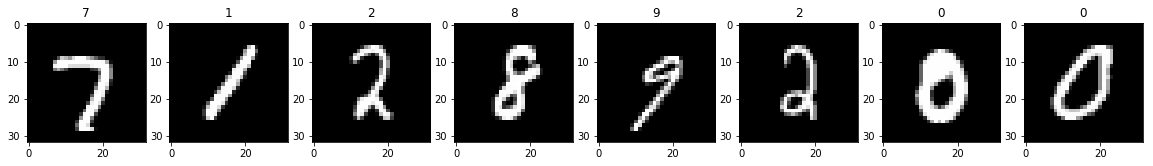

Epoch: 72, Iteration: 341201
Loss: 0.0311, Accuracy: 100.00%
Preds: [7 0 9 7 0 9 6 3]


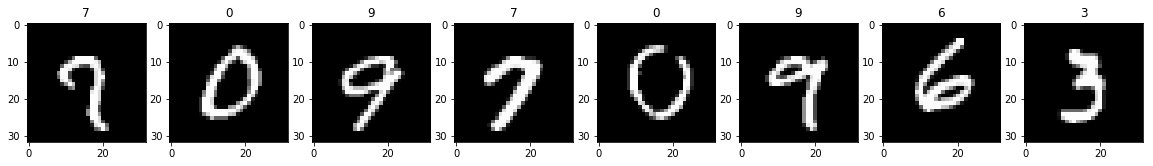

Epoch: 72, Iteration: 342201
Loss: 0.0968, Accuracy: 95.00%
Preds: [0 6 3 2 7 1 0 3]


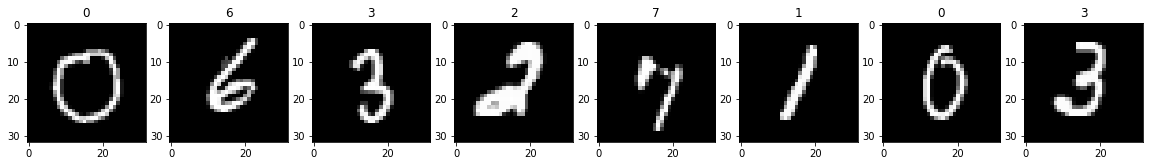

Epoch: 72, Iteration: 343201
Loss: 0.0105, Accuracy: 100.00%
Preds: [5 5 5 0 0 9 9 5]


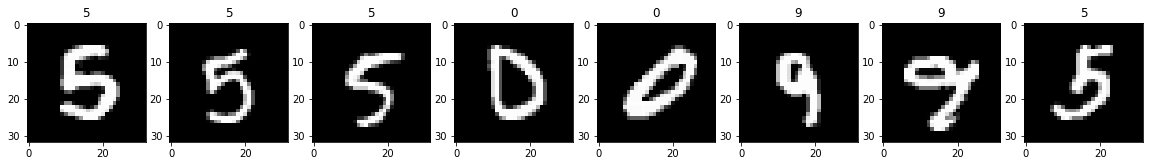

Epoch: 72, Iteration: 344201
Loss: 0.0695, Accuracy: 97.50%
Preds: [1 4 3 5 0 5 2 1]


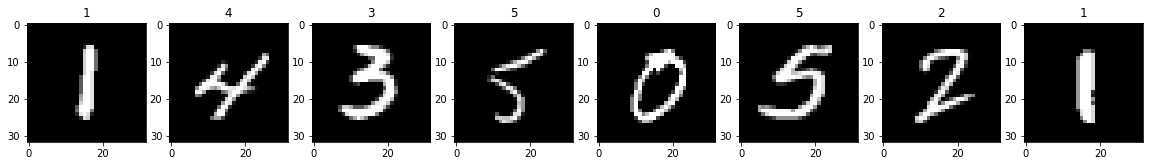

Epoch: 73, Iteration: 344926
Loss: 0.0516, Accuracy: 96.25%
Preds: [8 4 3 5 8 5 1 4]


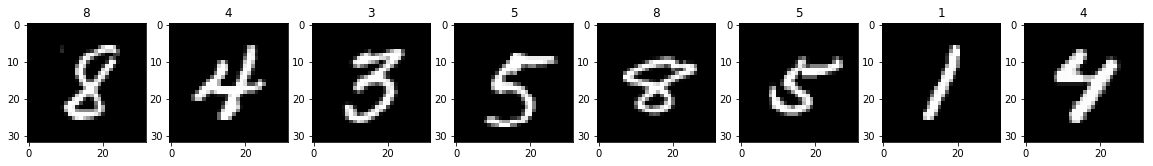

Epoch: 73, Iteration: 345926
Loss: 0.0547, Accuracy: 97.50%
Preds: [4 8 1 0 3 1 4 7]


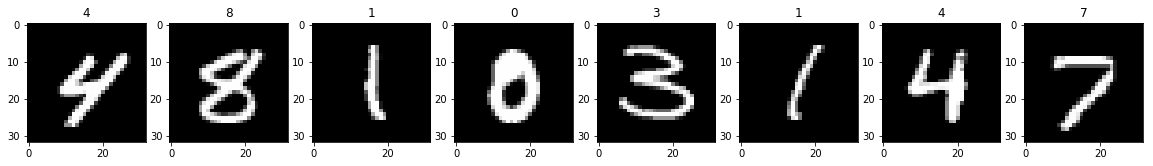

Epoch: 73, Iteration: 346926
Loss: 0.0458, Accuracy: 98.75%
Preds: [2 8 3 8 1 3 2 7]


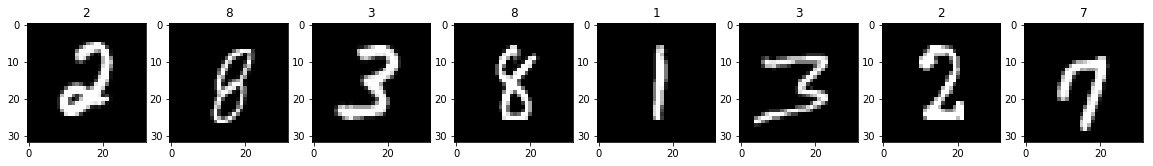

Epoch: 73, Iteration: 347926
Loss: 0.0316, Accuracy: 98.75%
Preds: [2 0 0 0 5 8 0 8]


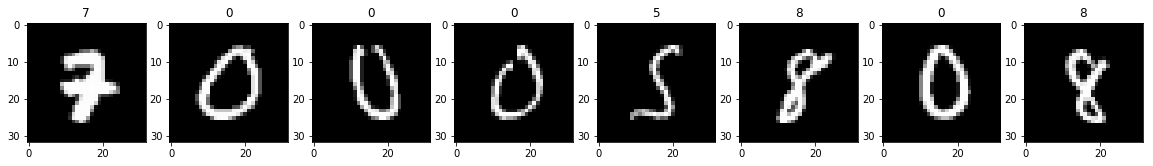

Epoch: 73, Iteration: 348926
Loss: 0.0526, Accuracy: 98.75%
Preds: [7 6 3 1 3 2 1 0]


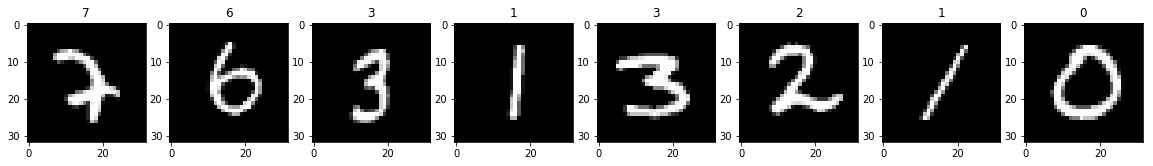

Epoch: 74, Iteration: 349651
Loss: 0.1245, Accuracy: 96.25%
Preds: [1 6 4 8 4 3 3 1]


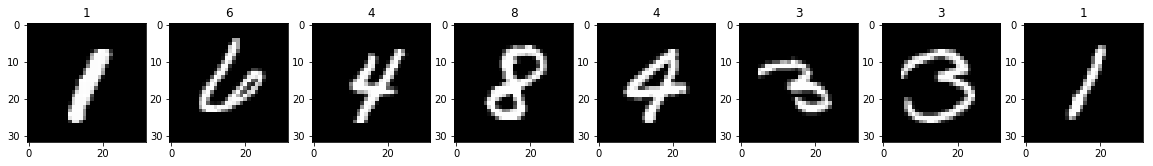

Epoch: 74, Iteration: 350651
Loss: 0.0343, Accuracy: 98.75%
Preds: [4 1 9 6 8 5 1 6]


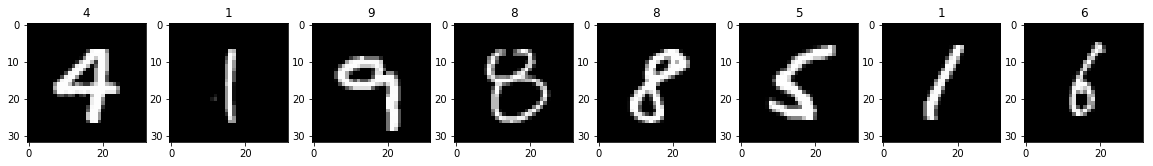

Epoch: 74, Iteration: 351651
Loss: 0.0628, Accuracy: 98.75%
Preds: [4 6 0 3 9 4 8 7]


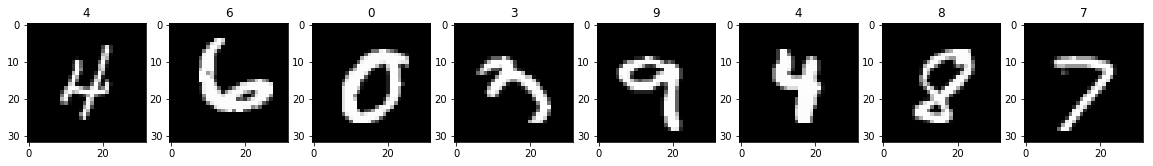

Epoch: 74, Iteration: 352651
Loss: 0.1170, Accuracy: 97.50%
Preds: [8 8 7 4 8 3 6 9]


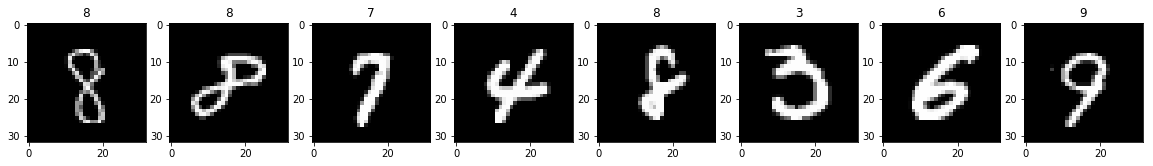

Epoch: 74, Iteration: 353651
Loss: 0.0937, Accuracy: 96.25%
Preds: [4 3 6 3 7 7 7 7]


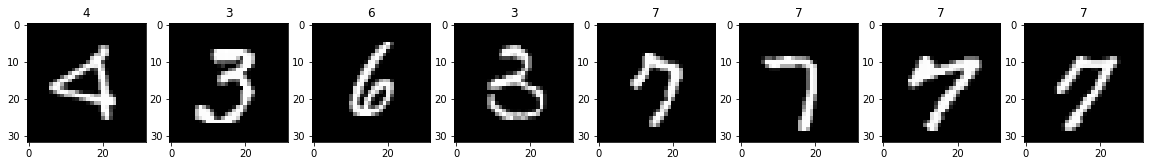

Epoch: 75, Iteration: 354376
Loss: 0.2153, Accuracy: 93.75%
Preds: [3 0 6 3 2 0 0 9]


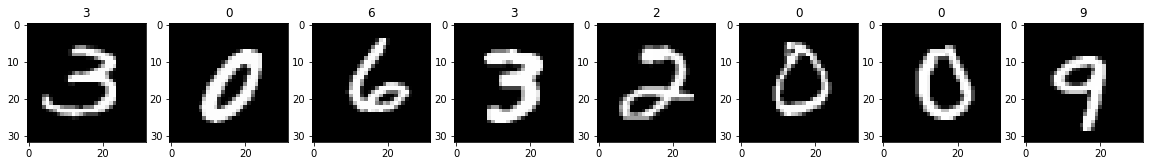

Epoch: 75, Iteration: 355376
Loss: 0.1375, Accuracy: 96.25%
Preds: [9 5 7 8 2 4 6 6]


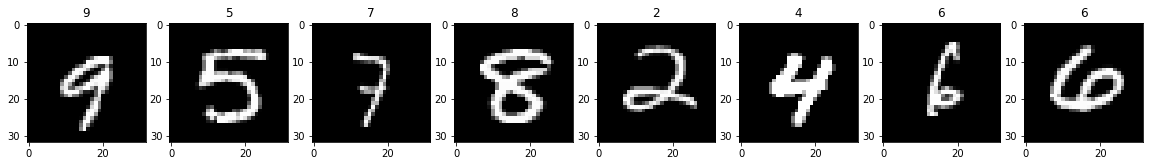

Epoch: 75, Iteration: 356376
Loss: 0.0318, Accuracy: 98.75%
Preds: [1 7 8 5 1 6 7 2]


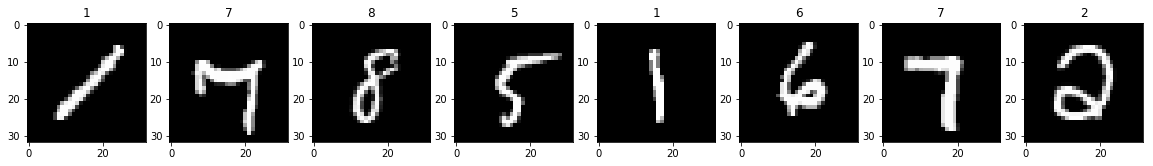

Epoch: 75, Iteration: 357376
Loss: 0.0964, Accuracy: 96.25%
Preds: [0 7 1 5 7 3 2 2]


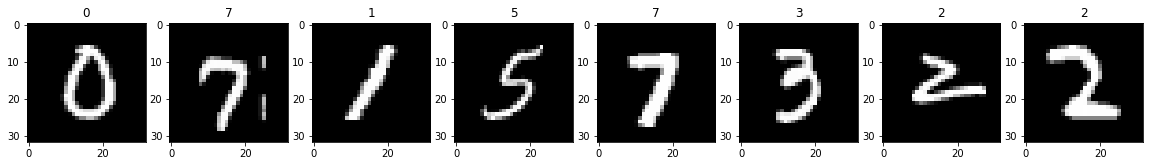

Epoch: 75, Iteration: 358376
Loss: 0.1375, Accuracy: 96.25%
Preds: [2 9 5 4 6 8 4 7]


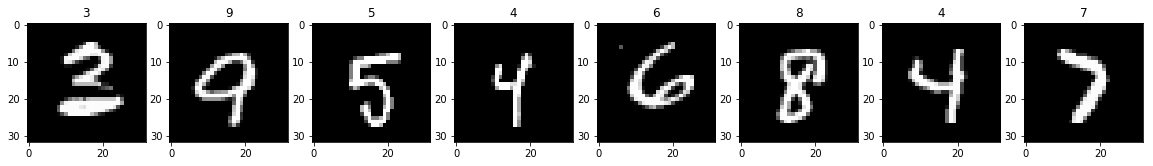

Epoch: 76, Iteration: 359101
Loss: 0.0361, Accuracy: 97.50%
Preds: [0 3 6 9 1 7 4 6]


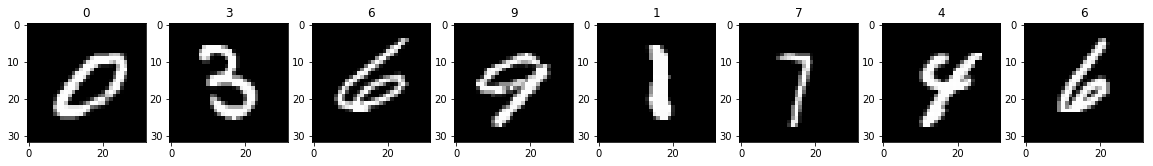

Epoch: 76, Iteration: 360101
Loss: 0.1010, Accuracy: 97.50%
Preds: [2 9 7 8 4 0 4 1]


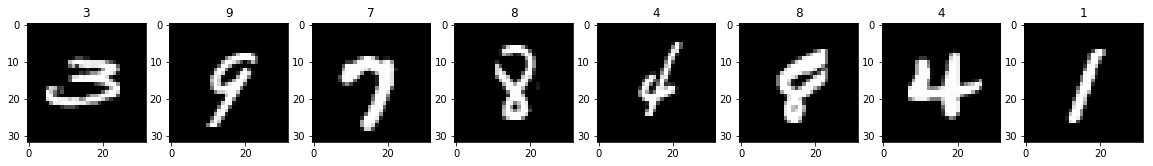

Epoch: 76, Iteration: 361101
Loss: 0.2367, Accuracy: 92.50%
Preds: [1 5 6 9 8 6 3 6]


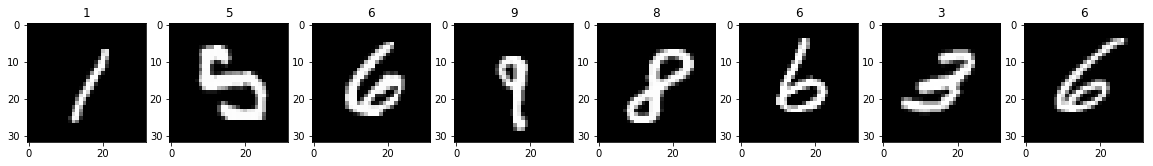

Epoch: 76, Iteration: 362101
Loss: 0.0619, Accuracy: 98.75%
Preds: [9 8 8 9 0 9 1 3]


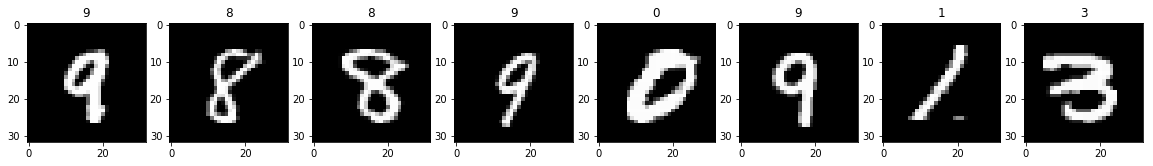

Epoch: 76, Iteration: 363101
Loss: 0.0387, Accuracy: 97.50%
Preds: [9 6 1 3 6 8 3 7]


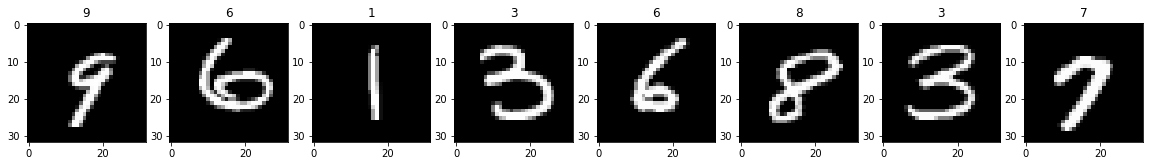

Epoch: 77, Iteration: 363826
Loss: 0.0339, Accuracy: 98.75%
Preds: [1 8 7 2 2 2 1 2]


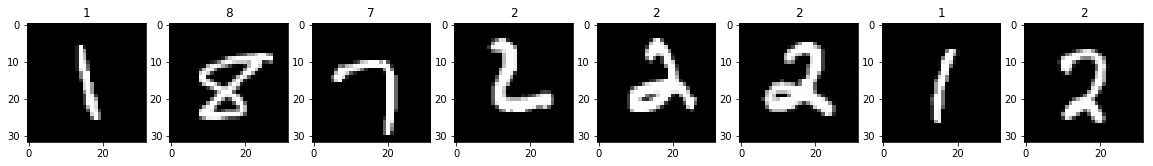

Epoch: 77, Iteration: 364826
Loss: 0.0470, Accuracy: 100.00%
Preds: [3 9 6 7 0 4 7 5]


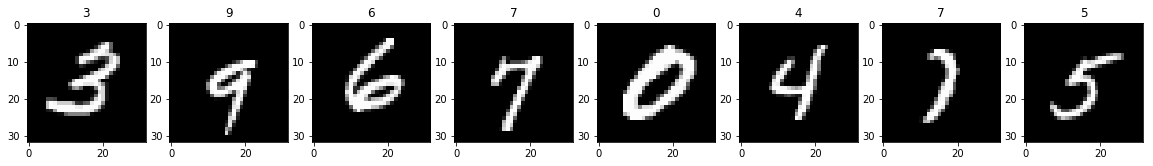

Epoch: 77, Iteration: 365826
Loss: 0.2039, Accuracy: 96.25%
Preds: [6 7 6 7 3 9 4 4]


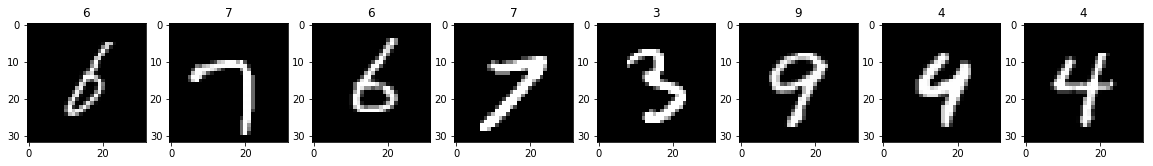

Epoch: 77, Iteration: 366826
Loss: 0.1068, Accuracy: 98.75%
Preds: [4 7 2 3 2 1 8 2]


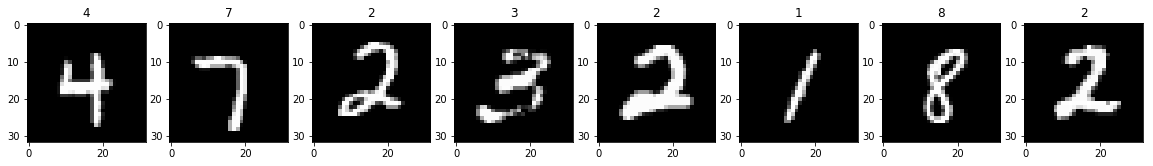

Epoch: 77, Iteration: 367826
Loss: 0.1629, Accuracy: 96.25%
Preds: [5 2 5 7 6 3 9 4]


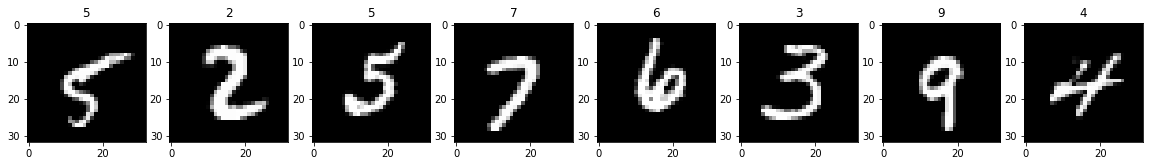

Epoch: 78, Iteration: 368551
Loss: 0.1530, Accuracy: 93.75%
Preds: [5 1 2 8 3 2 3 7]


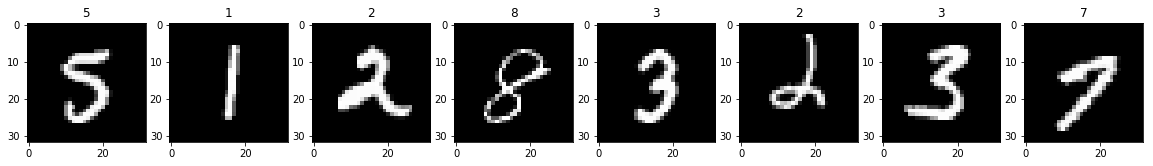

Epoch: 78, Iteration: 369551
Loss: 0.0694, Accuracy: 98.75%
Preds: [7 3 4 7 6 0 8 0]


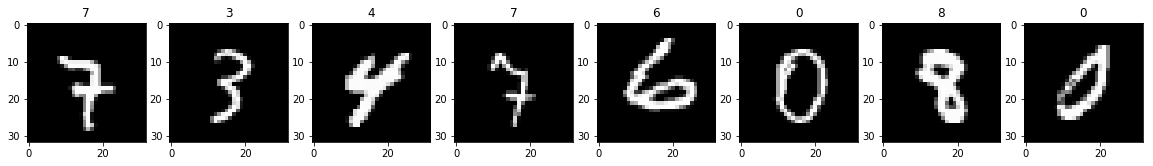

Epoch: 78, Iteration: 370551
Loss: 0.0416, Accuracy: 100.00%
Preds: [9 9 3 9 0 7 9 1]


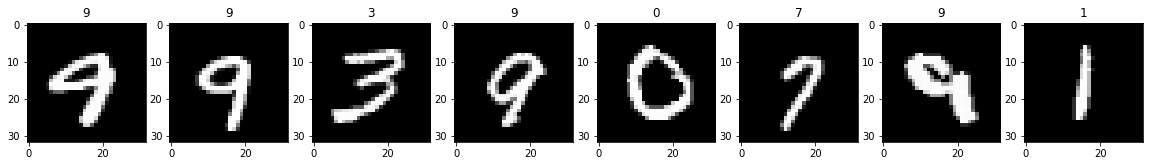

Epoch: 78, Iteration: 371551
Loss: 0.0927, Accuracy: 98.75%
Preds: [4 3 3 6 4 1 8 0]


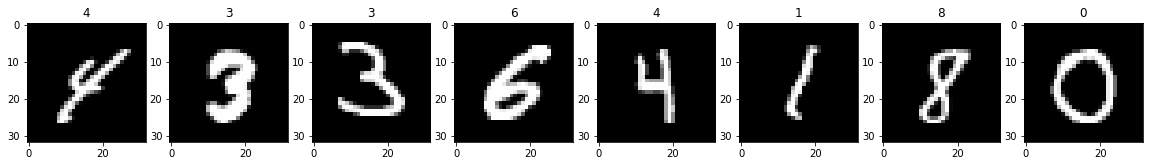

Epoch: 78, Iteration: 372551
Loss: 0.1485, Accuracy: 96.25%
Preds: [3 2 3 6 4 0 4 9]


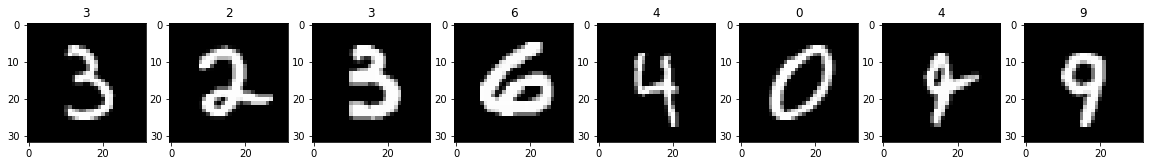

Epoch: 79, Iteration: 373276
Loss: 0.0502, Accuracy: 97.50%
Preds: [8 0 5 0 3 8 1 2]


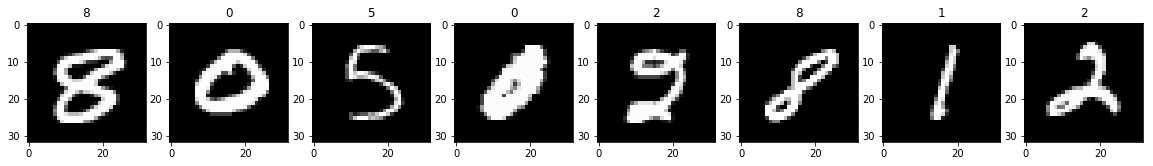

Epoch: 79, Iteration: 374276
Loss: 0.2465, Accuracy: 96.25%
Preds: [2 9 8 8 0 6 9 7]


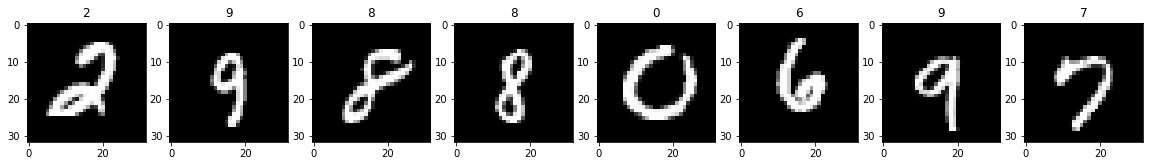

Epoch: 79, Iteration: 375276
Loss: 0.0137, Accuracy: 100.00%
Preds: [7 6 6 5 4 8 1 1]


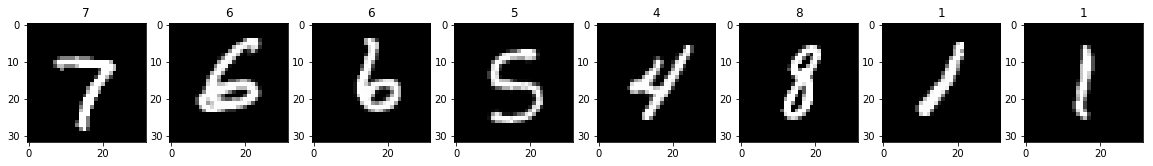

Epoch: 79, Iteration: 376276
Loss: 0.0226, Accuracy: 98.75%
Preds: [0 7 9 2 9 4 8 9]


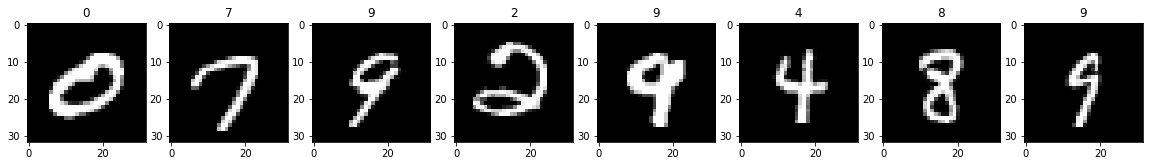

Epoch: 79, Iteration: 377276
Loss: 0.0401, Accuracy: 97.50%
Preds: [4 8 1 4 6 1 5 7]


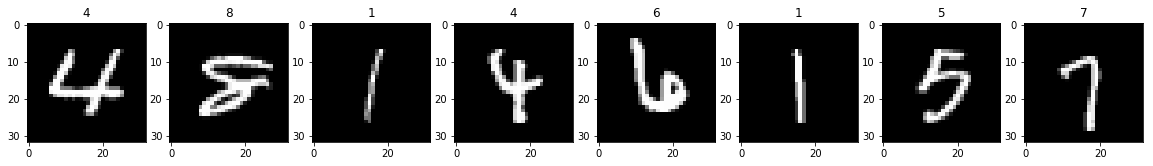

Epoch: 80, Iteration: 378001
Loss: 0.0727, Accuracy: 96.25%
Preds: [5 9 4 3 4 2 6 2]


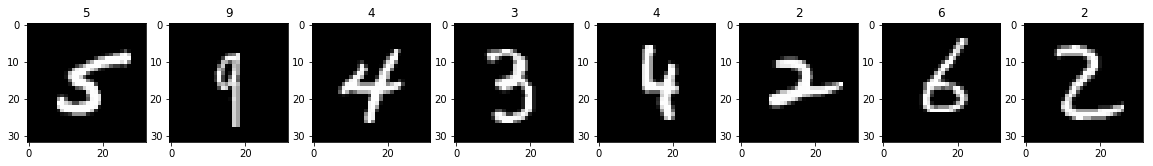

Epoch: 80, Iteration: 379001
Loss: 0.0894, Accuracy: 96.25%
Preds: [5 8 2 1 8 0 9 3]


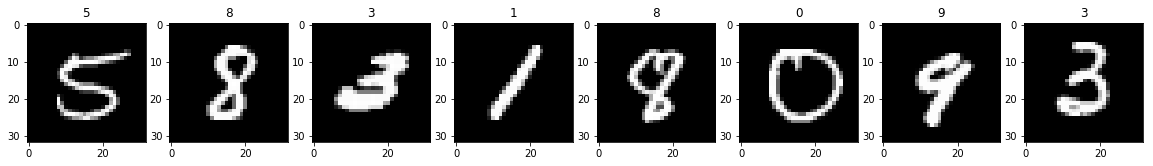

Epoch: 80, Iteration: 380001
Loss: 0.1001, Accuracy: 97.50%
Preds: [2 3 8 0 6 0 1 7]


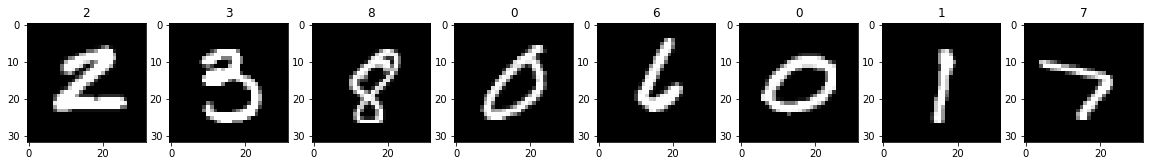

Epoch: 80, Iteration: 381001
Loss: 0.0577, Accuracy: 97.50%
Preds: [9 3 2 4 7 7 3 2]


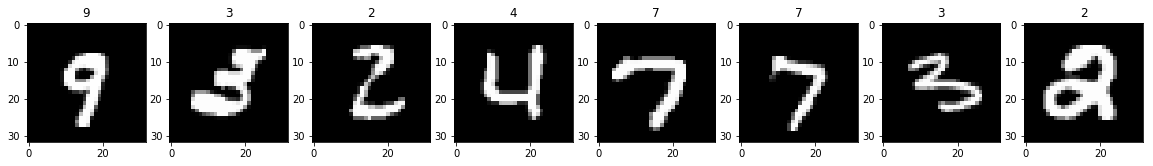

Epoch: 80, Iteration: 382001
Loss: 0.0226, Accuracy: 100.00%
Preds: [9 1 6 8 1 2 9 3]


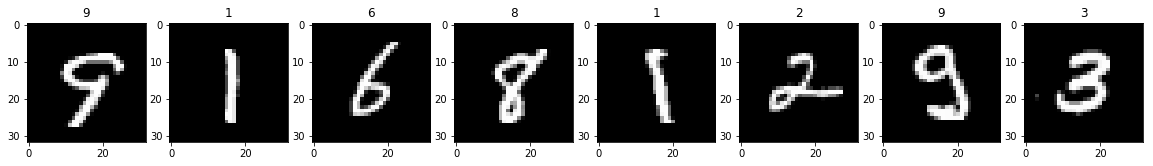

Epoch: 81, Iteration: 382726
Loss: 0.0464, Accuracy: 97.50%
Preds: [5 7 2 7 8 0 4 9]


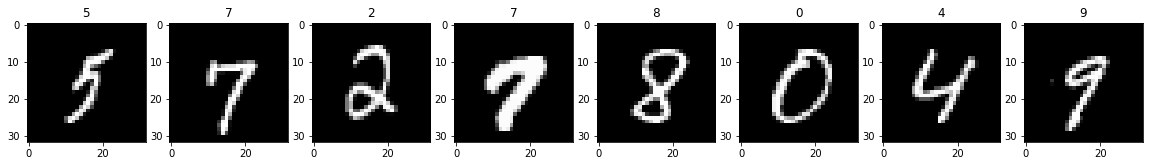

Epoch: 81, Iteration: 383726
Loss: 0.1672, Accuracy: 92.50%
Preds: [3 2 0 5 7 6 0 0]


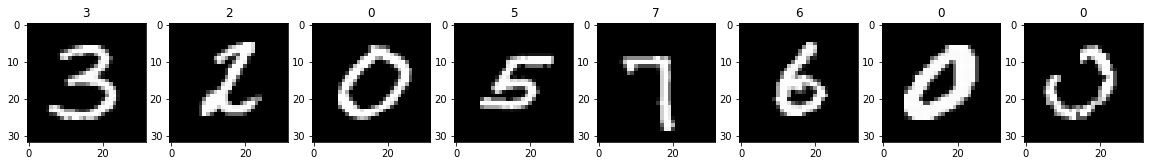

Epoch: 81, Iteration: 384726
Loss: 0.1151, Accuracy: 97.50%
Preds: [1 9 9 0 0 9 3 0]


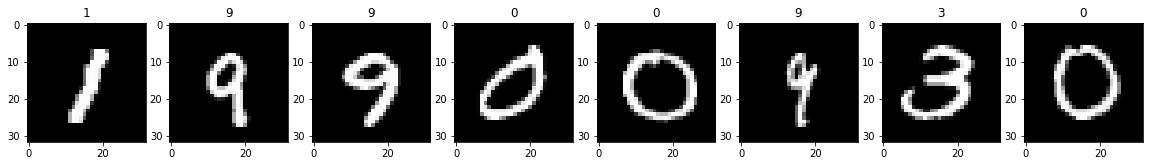

Epoch: 81, Iteration: 385726
Loss: 0.0247, Accuracy: 98.75%
Preds: [5 9 8 1 5 8 0 6]


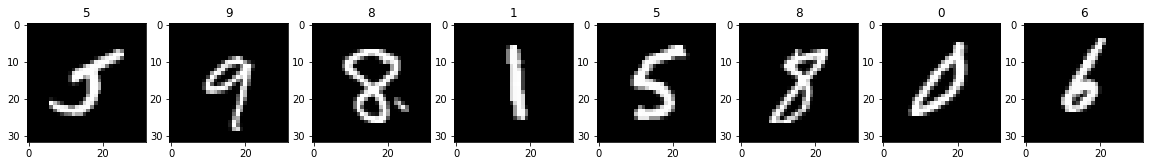

Epoch: 81, Iteration: 386726
Loss: 0.1173, Accuracy: 96.25%
Preds: [2 0 3 7 7 9 9 4]


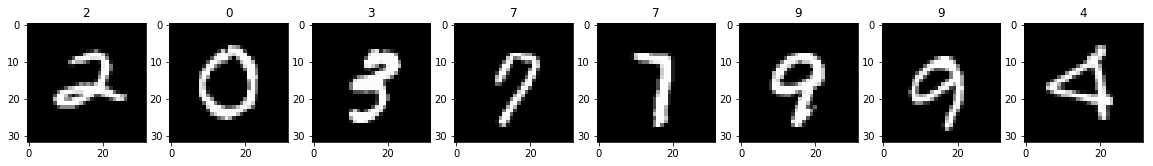

Epoch: 82, Iteration: 387451
Loss: 0.0085, Accuracy: 100.00%
Preds: [1 8 3 9 3 3 7 7]


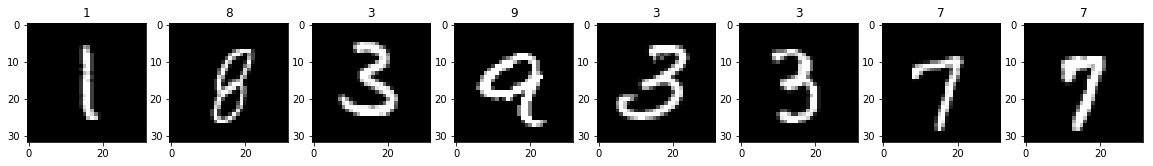

Epoch: 82, Iteration: 388451
Loss: 0.0901, Accuracy: 95.00%
Preds: [6 8 8 0 9 5 1 7]


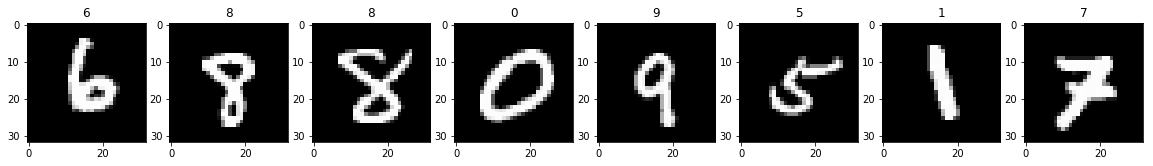

Epoch: 82, Iteration: 389451
Loss: 0.0226, Accuracy: 98.75%
Preds: [1 9 9 2 8 1 3 1]


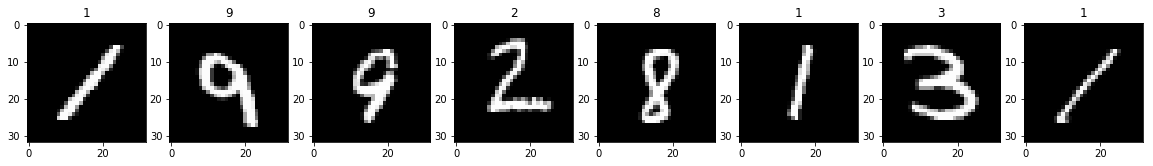

Epoch: 82, Iteration: 390451
Loss: 0.0890, Accuracy: 97.50%
Preds: [8 3 0 4 0 0 9 8]


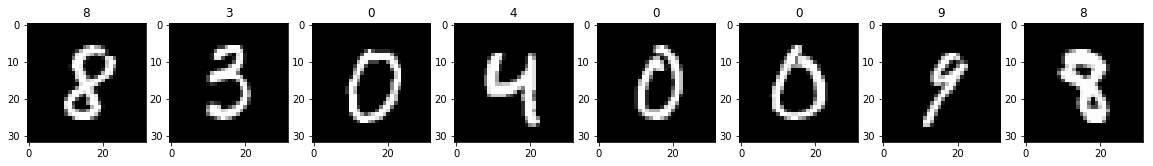

Epoch: 82, Iteration: 391451
Loss: 0.1449, Accuracy: 96.25%
Preds: [4 4 0 2 1 0 8 3]


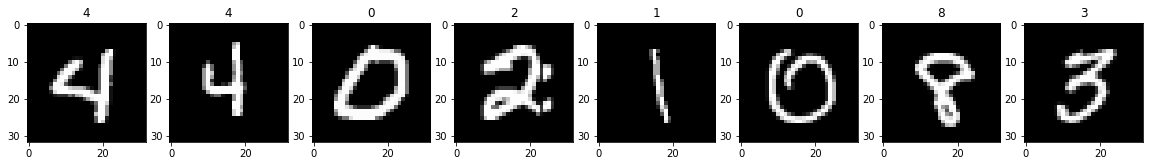

Epoch: 83, Iteration: 392176
Loss: 0.0696, Accuracy: 98.75%
Preds: [2 9 8 0 1 4 9 5]


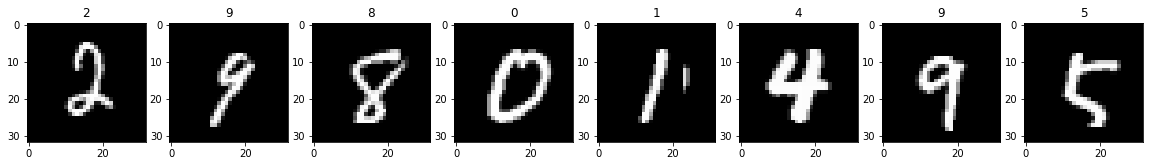

Epoch: 83, Iteration: 393176
Loss: 0.1345, Accuracy: 96.25%
Preds: [1 2 0 3 8 7 5 3]


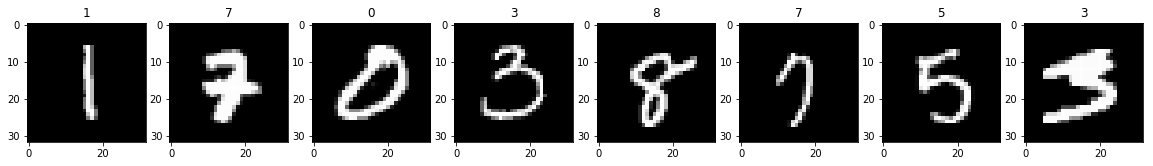

Epoch: 83, Iteration: 394176
Loss: 0.0721, Accuracy: 96.25%
Preds: [9 3 4 3 1 6 4 8]


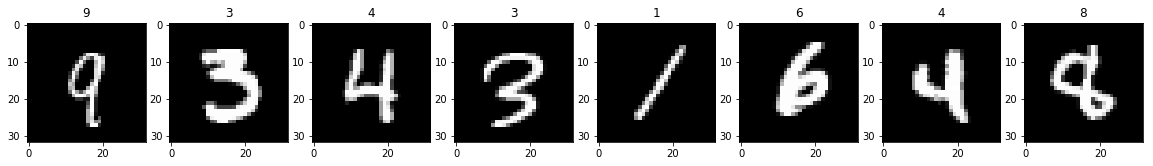

Epoch: 83, Iteration: 395176
Loss: 0.1388, Accuracy: 96.25%
Preds: [8 2 0 7 1 5 3 6]


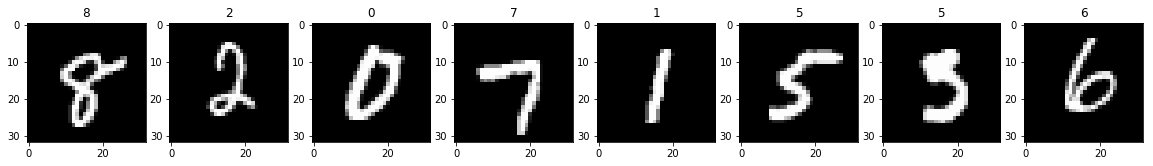

Epoch: 83, Iteration: 396176
Loss: 0.0904, Accuracy: 98.75%
Preds: [4 1 9 7 1 3 4 0]


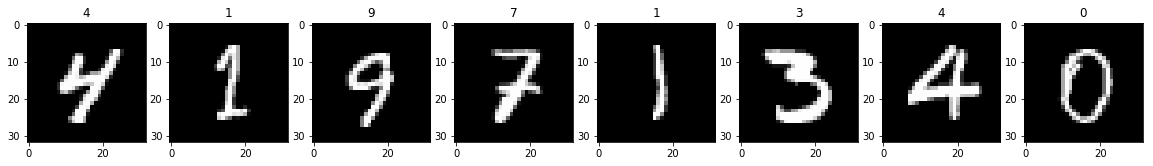

Epoch: 84, Iteration: 396901
Loss: 0.0369, Accuracy: 97.50%
Preds: [8 3 0 5 7 1 8 8]


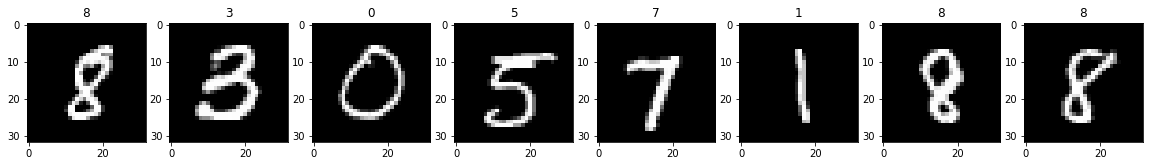

Epoch: 84, Iteration: 397901
Loss: 0.0650, Accuracy: 97.50%
Preds: [2 0 1 9 9 2 1 5]


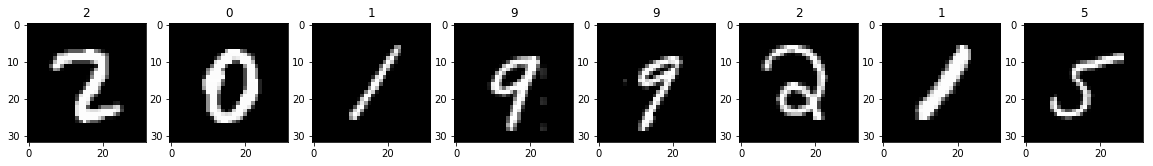

Epoch: 84, Iteration: 398901
Loss: 0.1032, Accuracy: 96.25%
Preds: [6 8 5 4 2 9 4 7]


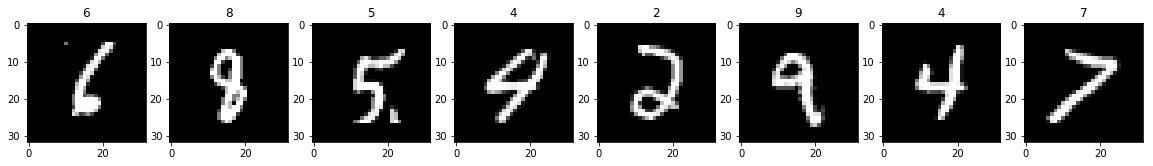

Epoch: 84, Iteration: 399901
Loss: 0.0634, Accuracy: 98.75%
Preds: [9 3 7 9 7 9 8 8]


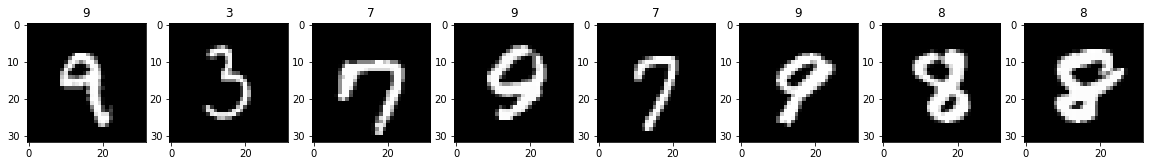

Epoch: 84, Iteration: 400901
Loss: 0.0505, Accuracy: 98.75%
Preds: [6 0 0 5 1 5 9 5]


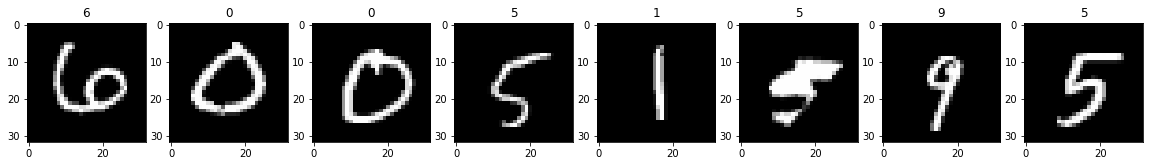

Epoch: 85, Iteration: 401626
Loss: 0.1158, Accuracy: 96.25%
Preds: [8 0 5 6 0 8 3 9]


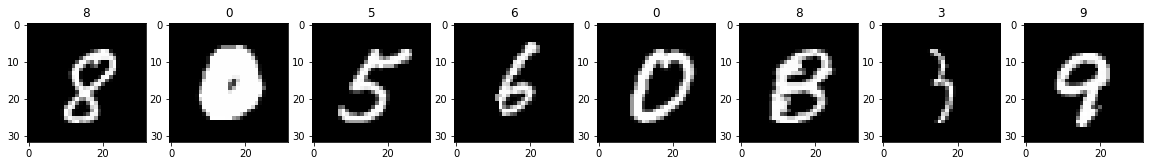

Epoch: 85, Iteration: 402626
Loss: 0.0822, Accuracy: 97.50%
Preds: [0 2 8 6 4 5 9 3]


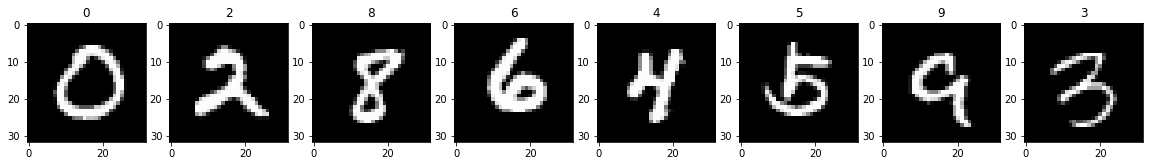

Epoch: 85, Iteration: 403626
Loss: 0.0291, Accuracy: 98.75%
Preds: [7 1 5 2 1 8 8 4]


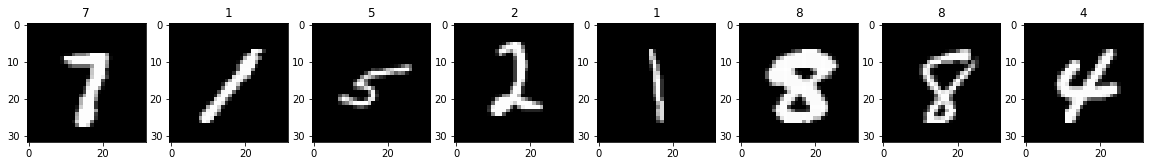

Epoch: 85, Iteration: 404626
Loss: 0.0665, Accuracy: 98.75%
Preds: [7 4 0 7 9 3 6 2]


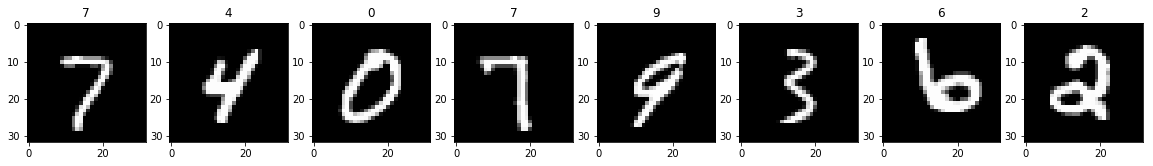

Epoch: 85, Iteration: 405626
Loss: 0.0401, Accuracy: 98.75%
Preds: [0 6 5 4 1 0 4 7]


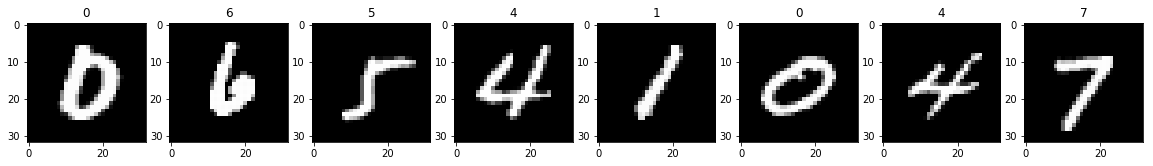

Epoch: 86, Iteration: 406351
Loss: 0.1576, Accuracy: 95.00%
Preds: [3 7 1 3 6 3 3 9]


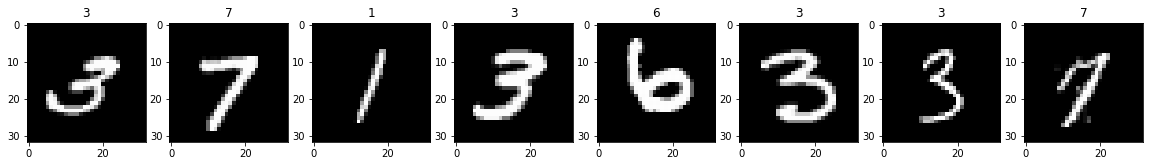

Epoch: 86, Iteration: 407351
Loss: 0.0931, Accuracy: 96.25%
Preds: [3 0 7 3 7 9 6 8]


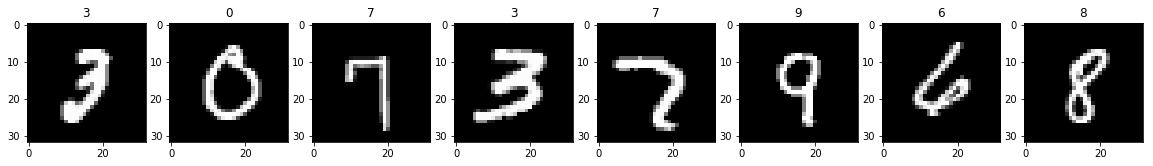

Epoch: 86, Iteration: 408351
Loss: 0.0640, Accuracy: 98.75%
Preds: [7 4 9 4 7 3 9 9]


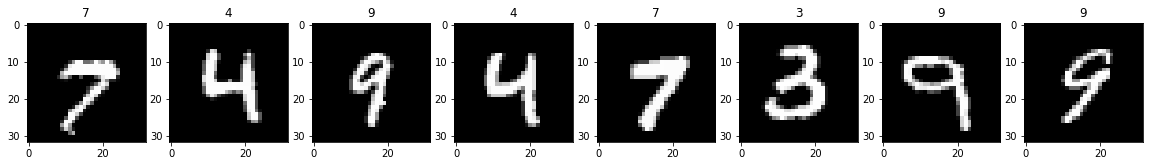

Epoch: 86, Iteration: 409351
Loss: 0.1163, Accuracy: 96.25%
Preds: [9 4 7 4 5 3 4 4]


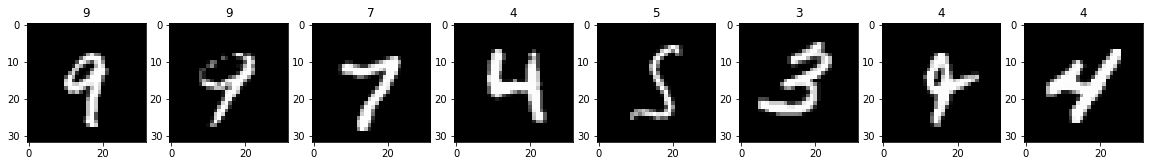

Epoch: 86, Iteration: 410351
Loss: 0.1270, Accuracy: 95.00%
Preds: [6 7 4 6 9 0 3 8]


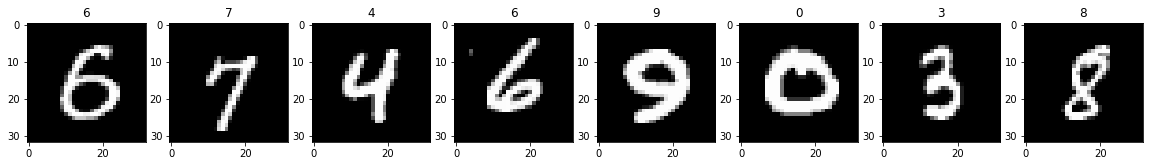

Epoch: 87, Iteration: 411076
Loss: 0.0334, Accuracy: 98.75%
Preds: [1 3 4 9 0 5 0 9]


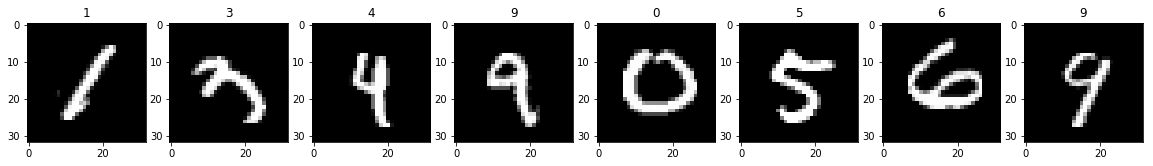

Epoch: 87, Iteration: 412076
Loss: 0.0585, Accuracy: 98.75%
Preds: [0 2 5 6 5 4 8 0]


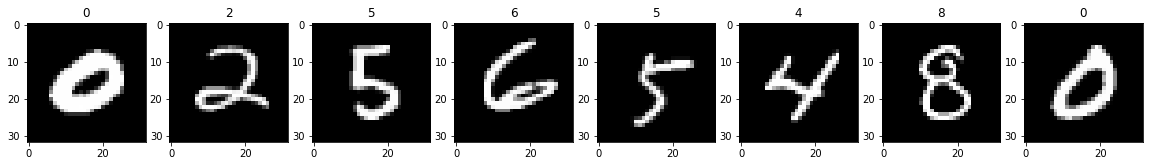

Epoch: 87, Iteration: 413076
Loss: 0.0923, Accuracy: 98.75%
Preds: [0 7 9 8 1 5 0 8]


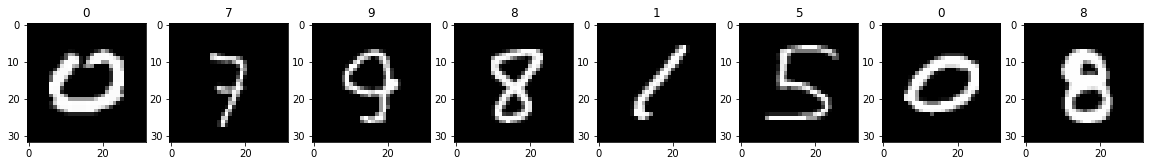

Epoch: 87, Iteration: 414076
Loss: 0.1716, Accuracy: 93.75%
Preds: [4 7 0 2 8 0 7 0]


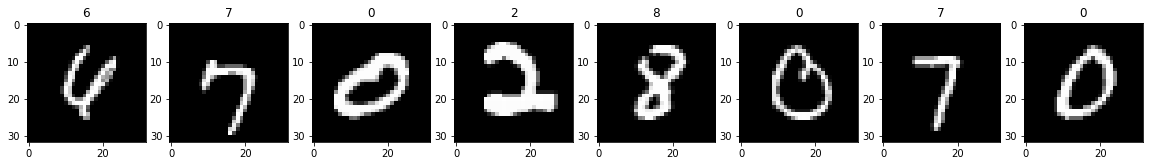

Epoch: 87, Iteration: 415076
Loss: 0.0991, Accuracy: 96.25%
Preds: [1 9 9 8 3 7 4 0]


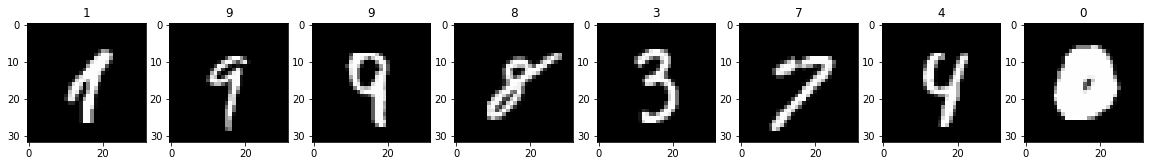

Epoch: 88, Iteration: 415801
Loss: 0.1369, Accuracy: 96.25%
Preds: [4 0 5 7 1 0 2 0]


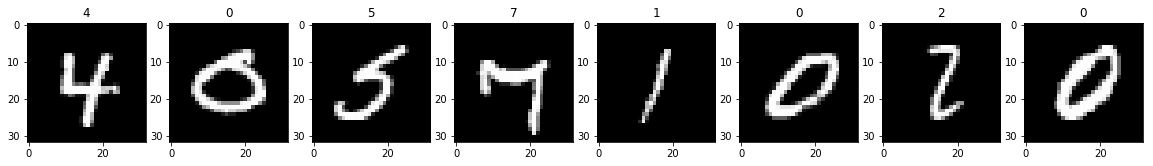

Epoch: 88, Iteration: 416801
Loss: 0.0331, Accuracy: 100.00%
Preds: [0 7 4 1 4 8 9 3]


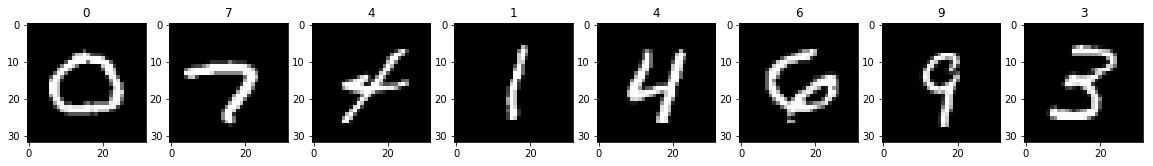

Epoch: 88, Iteration: 417801
Loss: 0.0677, Accuracy: 97.50%
Preds: [5 6 8 2 8 2 2 3]


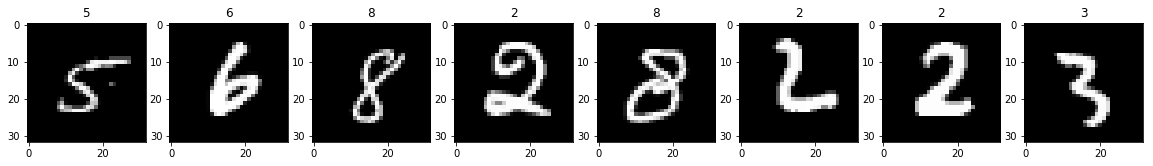

Epoch: 88, Iteration: 418801
Loss: 0.0674, Accuracy: 96.25%
Preds: [6 5 2 1 7 7 9 2]


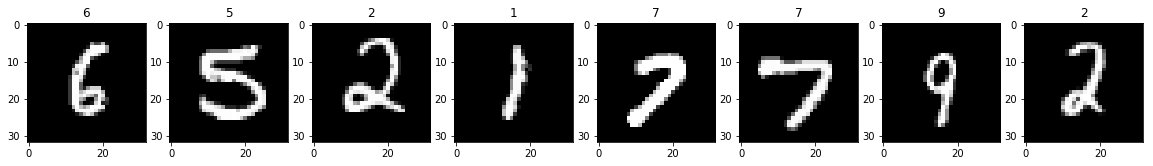

Epoch: 88, Iteration: 419801
Loss: 0.0613, Accuracy: 97.50%
Preds: [1 2 1 4 1 3 0 4]


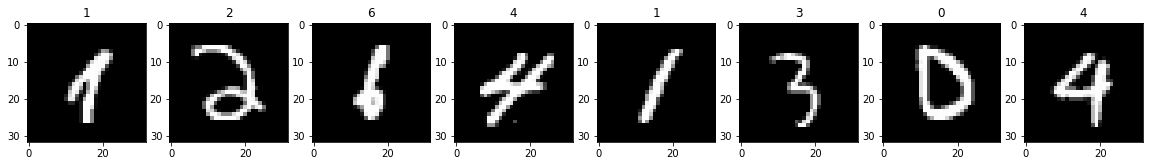

Epoch: 89, Iteration: 420526
Loss: 0.1085, Accuracy: 96.25%
Preds: [6 4 0 7 8 4 1 0]


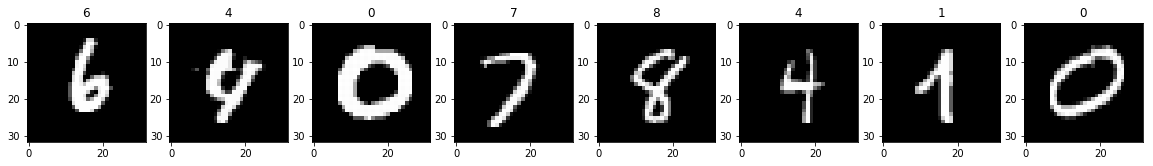

Epoch: 89, Iteration: 421526
Loss: 0.0183, Accuracy: 100.00%
Preds: [0 3 3 0 3 7 9 1]


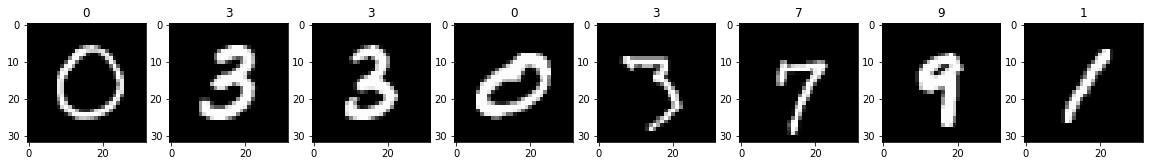

Epoch: 89, Iteration: 422526
Loss: 0.0269, Accuracy: 98.75%
Preds: [6 3 6 6 5 6 0 1]


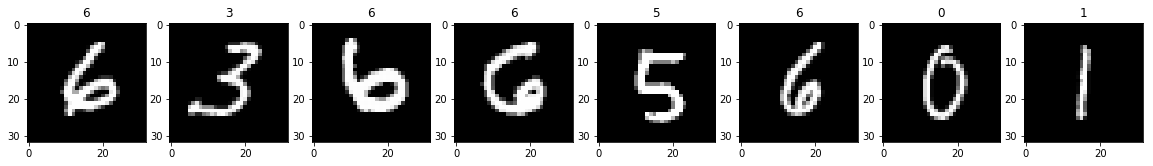

Epoch: 89, Iteration: 423526
Loss: 0.1276, Accuracy: 97.50%
Preds: [3 9 6 7 2 5 8 5]


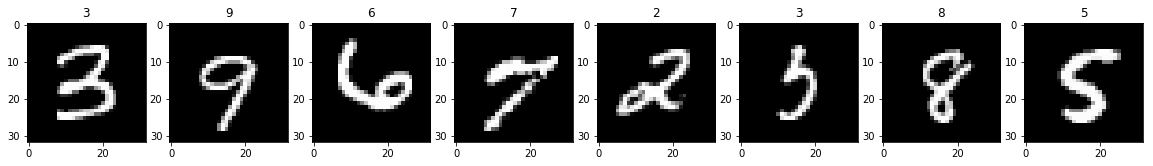

Epoch: 89, Iteration: 424526
Loss: 0.1438, Accuracy: 93.75%
Preds: [8 3 0 9 6 9 5 7]


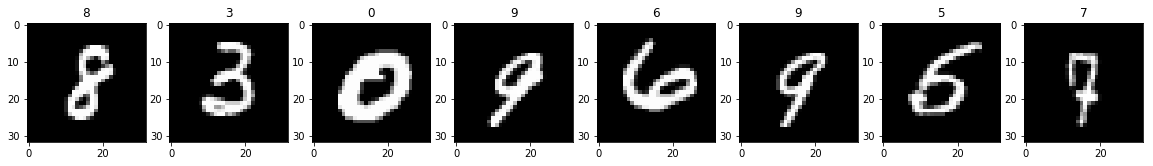

Epoch: 90, Iteration: 425251
Loss: 0.0600, Accuracy: 98.75%
Preds: [9 9 9 6 6 7 7 0]


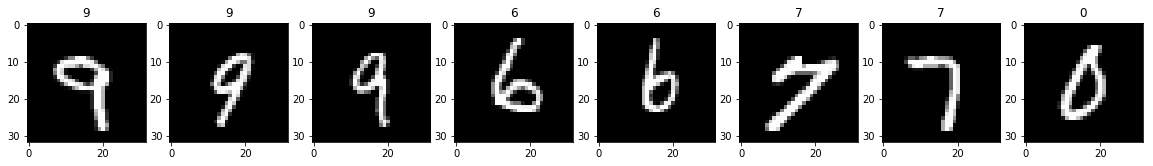

Epoch: 90, Iteration: 426251
Loss: 0.0270, Accuracy: 100.00%
Preds: [0 1 7 7 9 7 0 8]


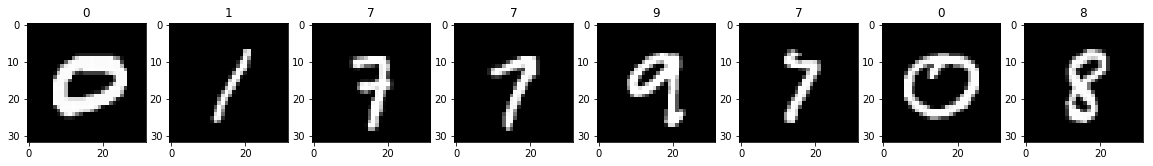

Epoch: 90, Iteration: 427251
Loss: 0.0623, Accuracy: 97.50%
Preds: [0 8 8 0 6 5 1 1]


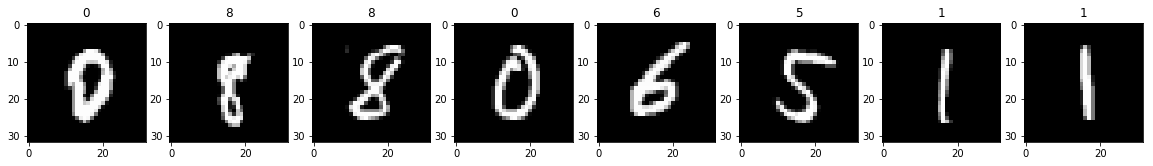

Epoch: 90, Iteration: 428251
Loss: 0.0978, Accuracy: 97.50%
Preds: [6 6 7 2 2 8 1 5]


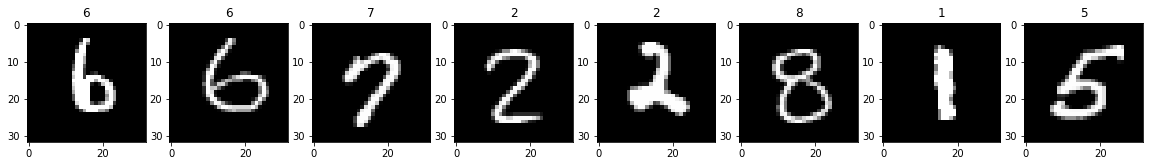

Epoch: 90, Iteration: 429251
Loss: 0.0838, Accuracy: 95.00%
Preds: [5 7 6 8 0 5 9 1]


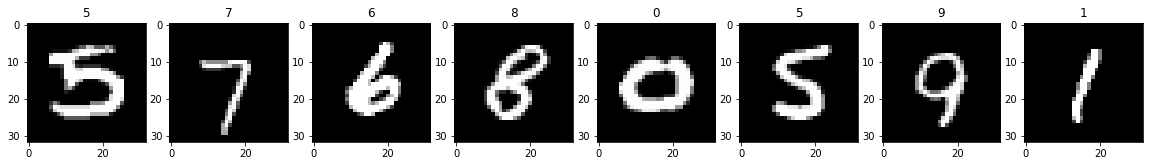

Epoch: 91, Iteration: 429976
Loss: 0.0208, Accuracy: 100.00%
Preds: [4 4 0 0 8 8 8 2]


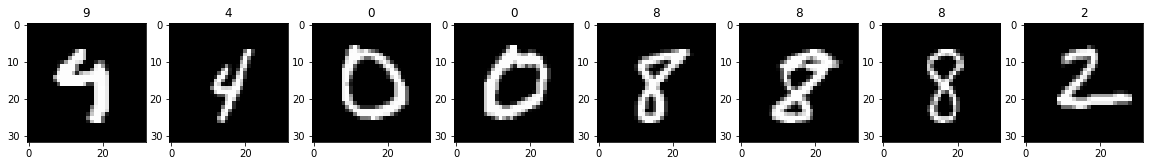

Epoch: 91, Iteration: 430976
Loss: 0.0444, Accuracy: 98.75%
Preds: [7 5 4 0 4 3 7 6]


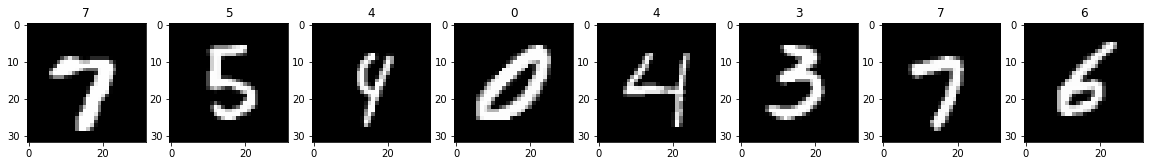

Epoch: 91, Iteration: 431976
Loss: 0.0433, Accuracy: 97.50%
Preds: [1 1 0 4 9 1 2 3]


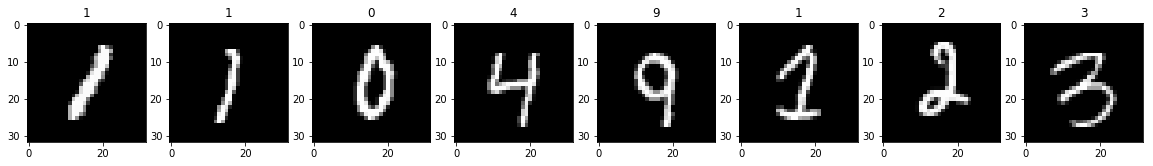

Epoch: 91, Iteration: 432976
Loss: 0.0415, Accuracy: 98.75%
Preds: [7 1 2 2 0 4 1 3]


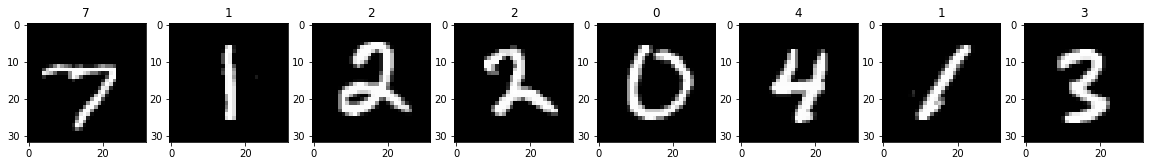

Epoch: 91, Iteration: 433976
Loss: 0.1003, Accuracy: 98.75%
Preds: [0 1 9 1 0 0 0 9]


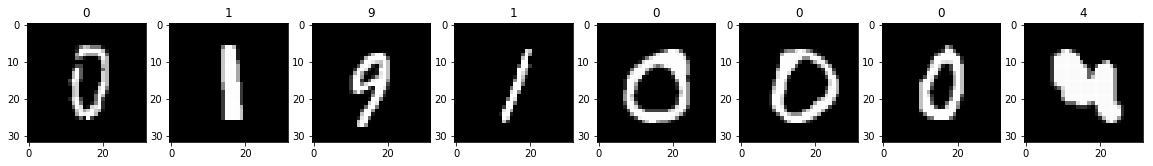

Epoch: 92, Iteration: 434701
Loss: 0.1319, Accuracy: 93.75%
Preds: [1 3 0 6 8 7 5 3]


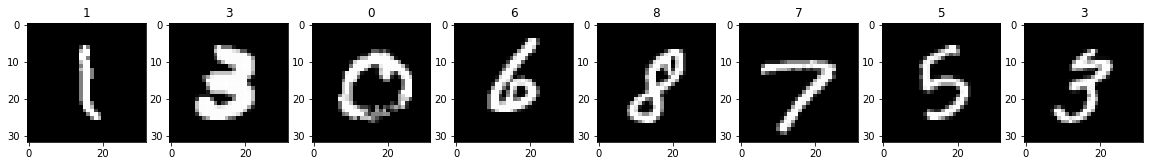

Epoch: 92, Iteration: 435701
Loss: 0.1960, Accuracy: 96.25%
Preds: [9 5 0 9 3 7 7 9]


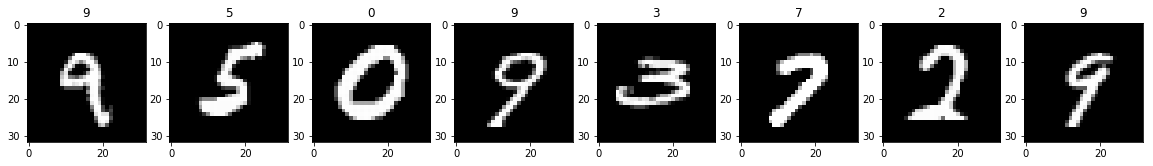

Epoch: 92, Iteration: 436701
Loss: 0.1571, Accuracy: 96.25%
Preds: [4 8 7 9 9 1 6 5]


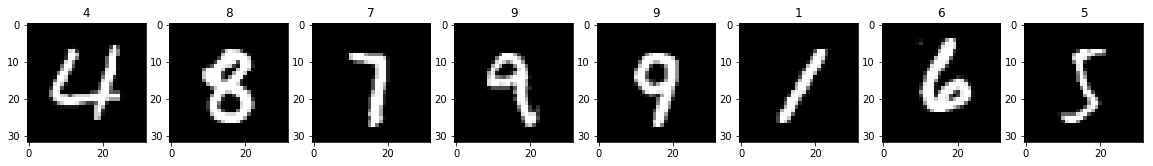

Epoch: 92, Iteration: 437701
Loss: 0.1517, Accuracy: 96.25%
Preds: [8 8 2 1 5 6 5 4]


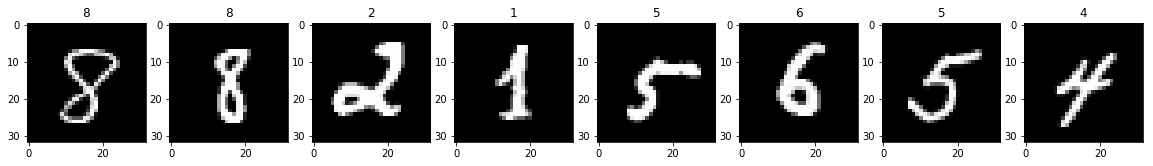

Epoch: 92, Iteration: 438701
Loss: 0.0181, Accuracy: 100.00%
Preds: [2 0 5 1 9 9 2 3]


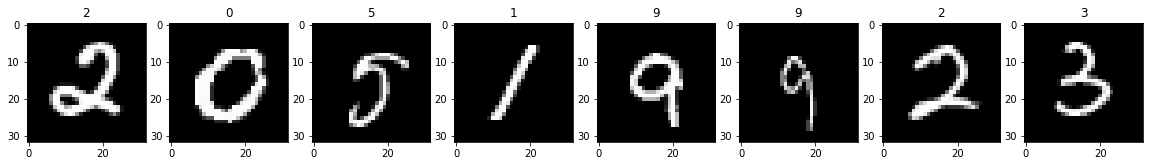

Epoch: 93, Iteration: 439426
Loss: 0.0235, Accuracy: 100.00%
Preds: [9 0 2 5 6 9 3 7]


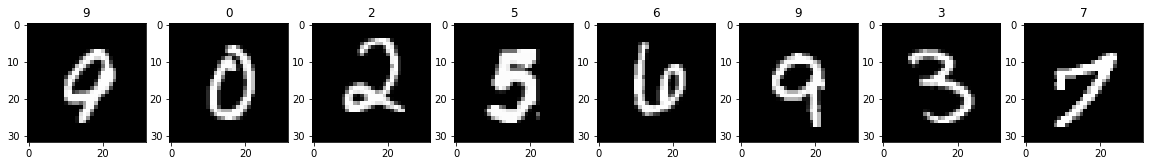

Epoch: 93, Iteration: 440426
Loss: 0.0422, Accuracy: 97.50%
Preds: [1 9 5 4 3 4 9 2]


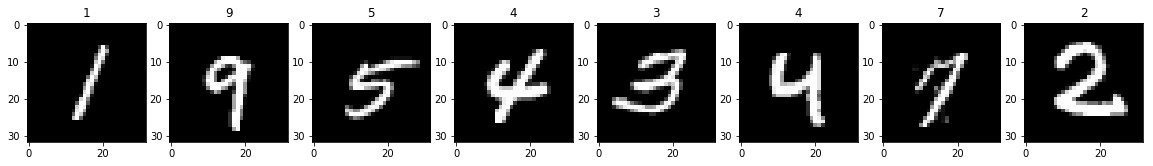

Epoch: 93, Iteration: 441426
Loss: 0.2166, Accuracy: 95.00%
Preds: [3 6 2 4 0 5 3 4]


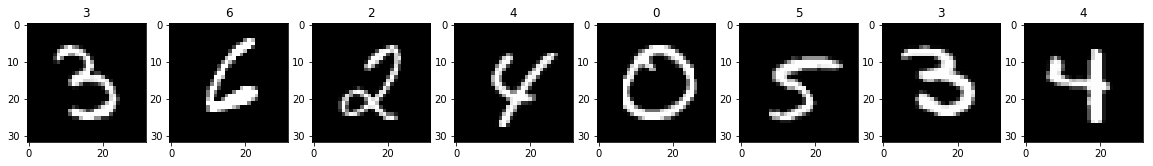

Epoch: 93, Iteration: 442426
Loss: 0.0394, Accuracy: 98.75%
Preds: [5 5 8 4 9 8 7 1]


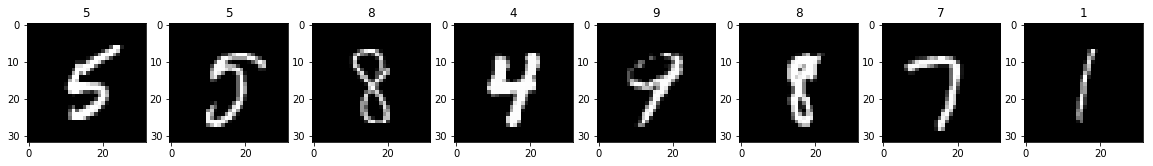

Epoch: 93, Iteration: 443426
Loss: 0.0904, Accuracy: 96.25%
Preds: [7 1 9 0 5 6 6 0]


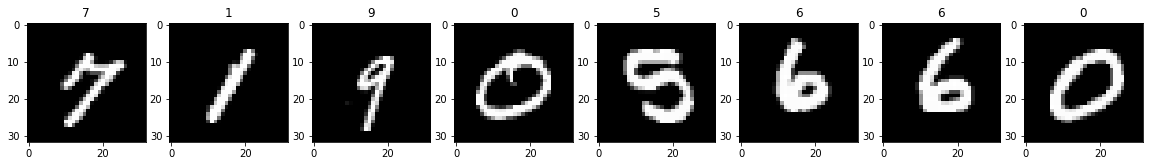

Epoch: 94, Iteration: 444151
Loss: 0.1360, Accuracy: 96.25%
Preds: [0 9 4 7 2 6 5 6]


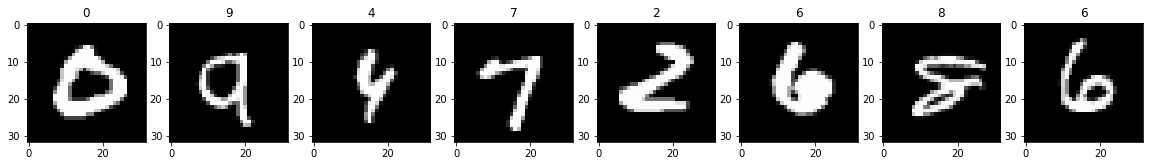

Epoch: 94, Iteration: 445151
Loss: 0.0413, Accuracy: 97.50%
Preds: [0 3 1 0 1 8 8 6]


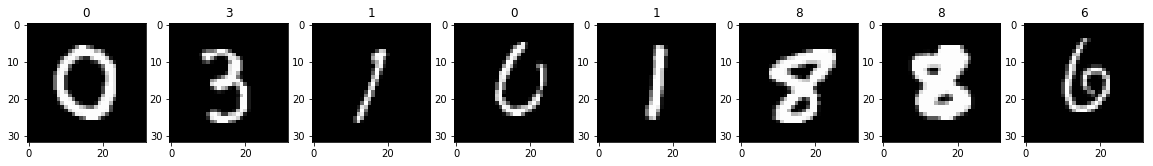

Epoch: 94, Iteration: 446151
Loss: 0.0135, Accuracy: 100.00%
Preds: [1 7 8 7 0 4 9 0]


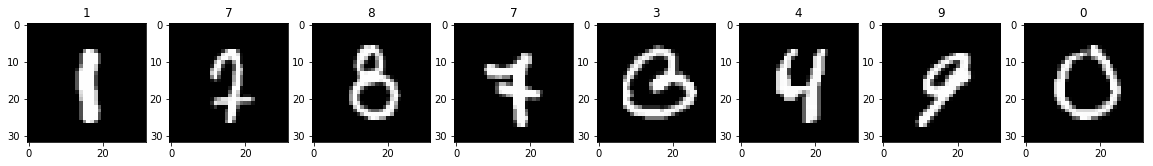

Epoch: 94, Iteration: 447151
Loss: 0.2537, Accuracy: 93.75%
Preds: [0 3 8 0 3 5 2 4]


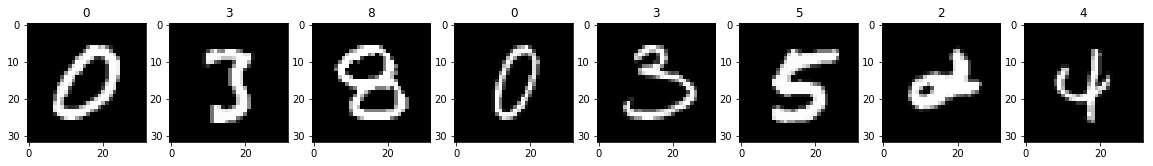

Epoch: 94, Iteration: 448151
Loss: 0.1037, Accuracy: 97.50%
Preds: [4 9 9 0 0 6 6 1]


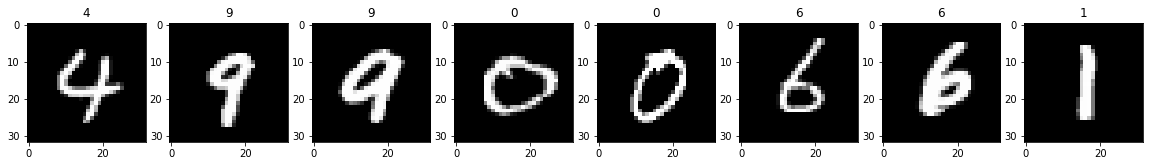

Epoch: 95, Iteration: 448876
Loss: 0.0751, Accuracy: 97.50%
Preds: [1 9 5 7 8 4 6 4]


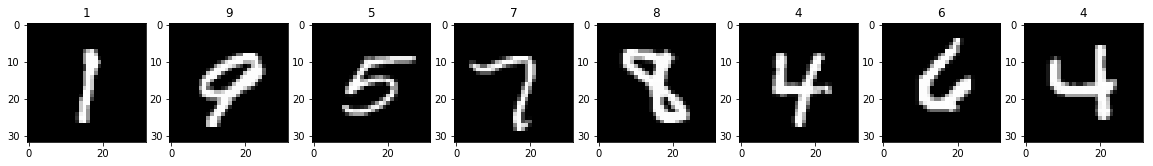

Epoch: 95, Iteration: 449876
Loss: 0.0549, Accuracy: 97.50%
Preds: [0 4 4 0 4 7 0 5]


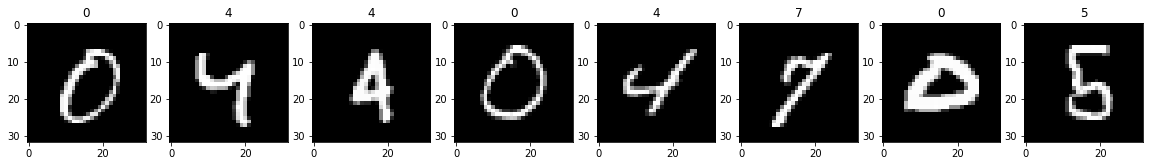

Epoch: 95, Iteration: 450876
Loss: 0.0346, Accuracy: 98.75%
Preds: [9 0 2 3 4 2 3 7]


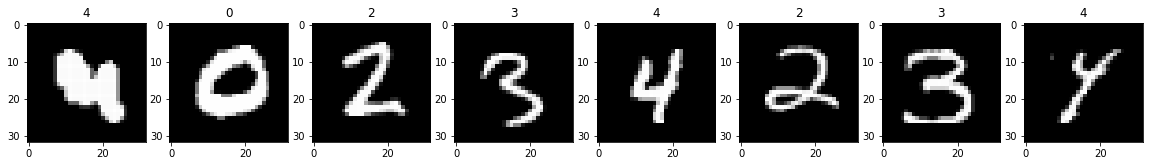

Epoch: 95, Iteration: 451876
Loss: 0.1347, Accuracy: 95.00%
Preds: [9 2 1 1 0 9 5 8]


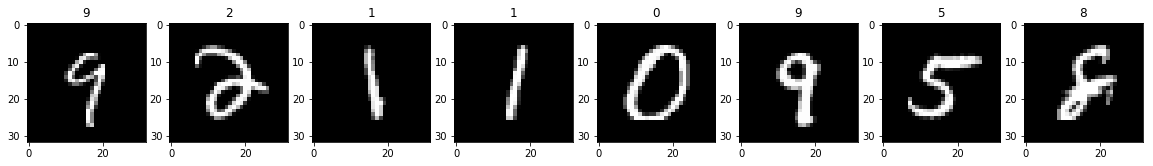

Epoch: 95, Iteration: 452876
Loss: 0.0513, Accuracy: 97.50%
Preds: [0 8 3 2 2 9 9 4]


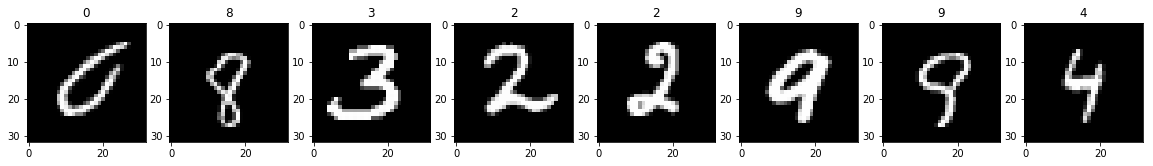

Epoch: 96, Iteration: 453601
Loss: 0.0461, Accuracy: 98.75%
Preds: [5 8 6 3 2 2 6 4]


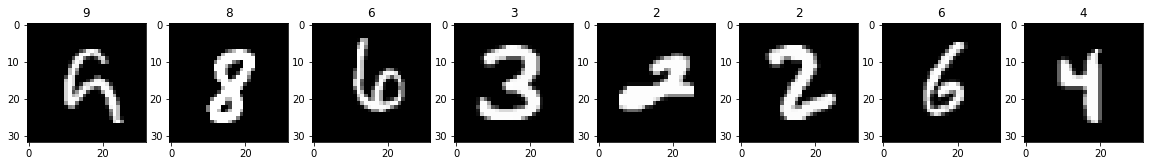

Epoch: 96, Iteration: 454601
Loss: 0.2809, Accuracy: 95.00%
Preds: [2 7 1 7 1 0 4 8]


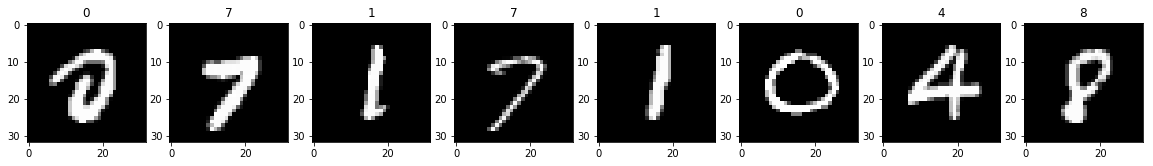

Epoch: 96, Iteration: 455601
Loss: 0.0881, Accuracy: 97.50%
Preds: [9 4 0 8 9 9 5 2]


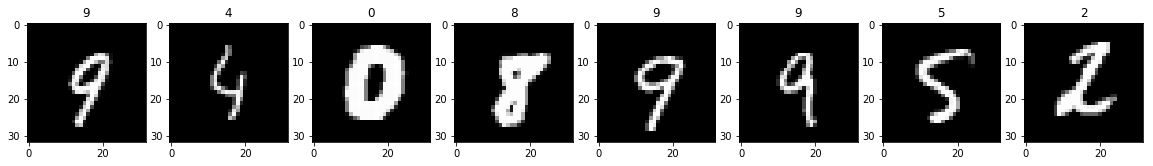

Epoch: 96, Iteration: 456601
Loss: 0.0501, Accuracy: 97.50%
Preds: [1 1 9 4 7 5 5 8]


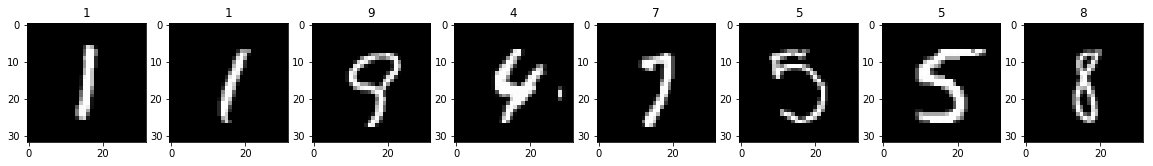

Epoch: 96, Iteration: 457601
Loss: 0.0787, Accuracy: 97.50%
Preds: [0 6 9 1 0 2 5 8]


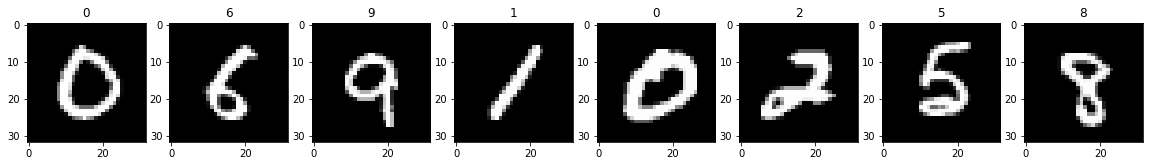

Epoch: 97, Iteration: 458326
Loss: 0.0542, Accuracy: 98.75%
Preds: [9 6 1 1 2 3 9 8]


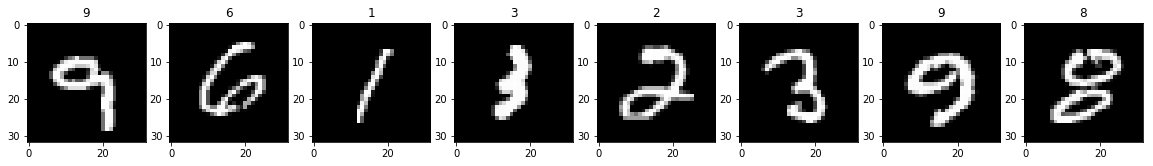

Epoch: 97, Iteration: 459326
Loss: 0.0721, Accuracy: 98.75%
Preds: [6 9 2 7 5 9 9 9]


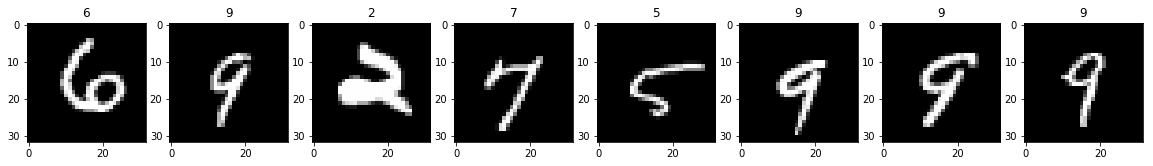

Epoch: 97, Iteration: 460326
Loss: 0.0685, Accuracy: 97.50%
Preds: [5 6 1 8 9 9 6 6]


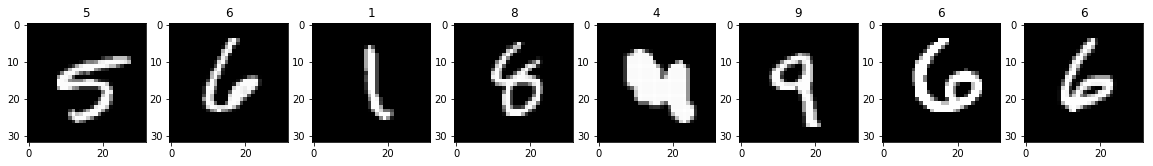

Epoch: 97, Iteration: 461326
Loss: 0.1184, Accuracy: 96.25%
Preds: [7 4 2 3 3 2 4 1]


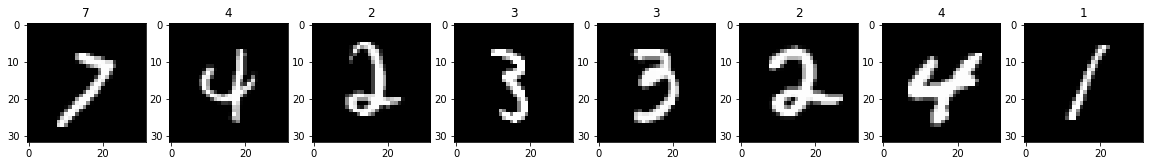

Epoch: 97, Iteration: 462326
Loss: 0.0961, Accuracy: 97.50%
Preds: [0 9 7 0 4 6 0 7]


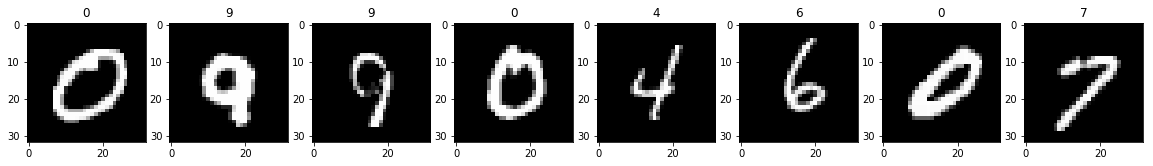

Epoch: 98, Iteration: 463051
Loss: 0.0464, Accuracy: 97.50%
Preds: [2 5 8 1 5 8 4 5]


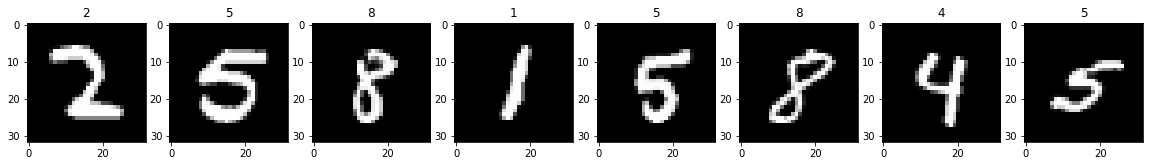

Epoch: 98, Iteration: 464051
Loss: 0.0608, Accuracy: 97.50%
Preds: [6 7 0 4 9 9 4 8]


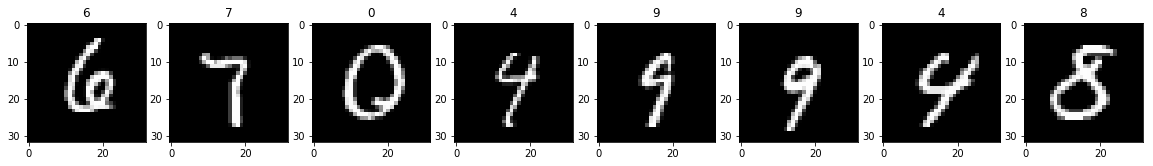

Epoch: 98, Iteration: 465051
Loss: 0.0401, Accuracy: 98.75%
Preds: [4 8 0 3 3 3 9 6]


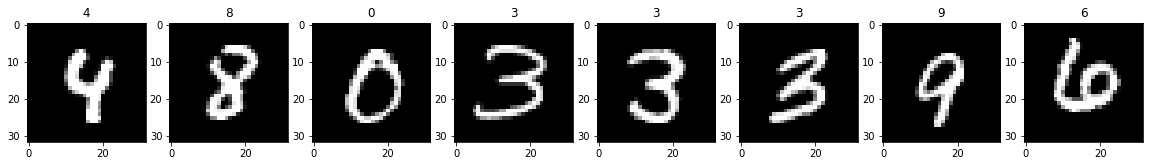

Epoch: 98, Iteration: 466051
Loss: 0.1604, Accuracy: 95.00%
Preds: [3 5 1 3 4 0 5 1]


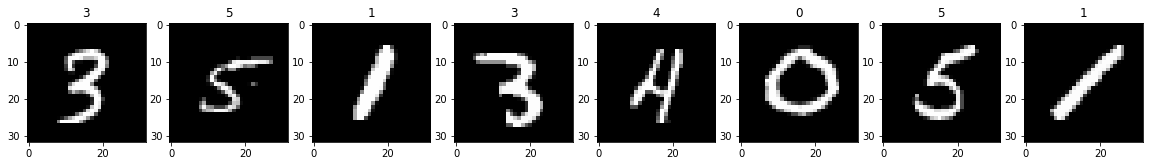

Epoch: 98, Iteration: 467051
Loss: 0.0910, Accuracy: 97.50%
Preds: [6 2 1 9 2 4 9 9]


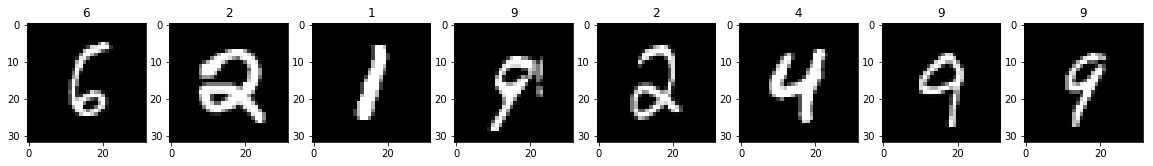

Epoch: 99, Iteration: 467776
Loss: 0.0503, Accuracy: 98.75%
Preds: [2 7 9 8 8 8 6 4]


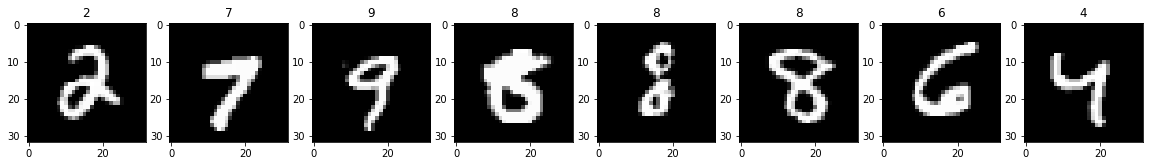

Epoch: 99, Iteration: 468776
Loss: 0.1867, Accuracy: 96.25%
Preds: [0 2 1 8 3 0 3 5]


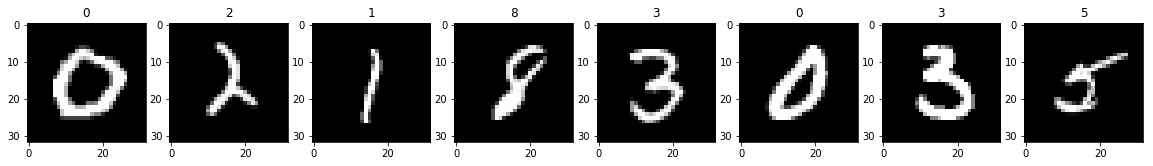

Epoch: 99, Iteration: 469776
Loss: 0.0300, Accuracy: 98.75%
Preds: [4 4 7 1 6 8 0 8]


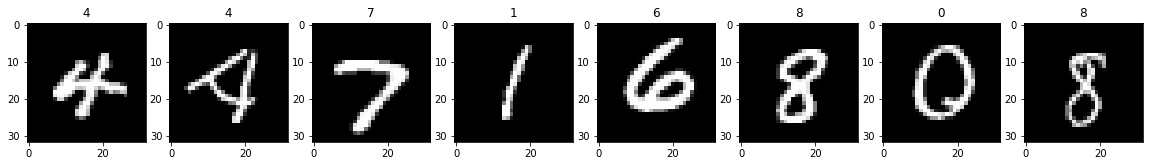

Epoch: 99, Iteration: 470776
Loss: 0.0249, Accuracy: 98.75%
Preds: [5 5 0 6 7 1 1 8]


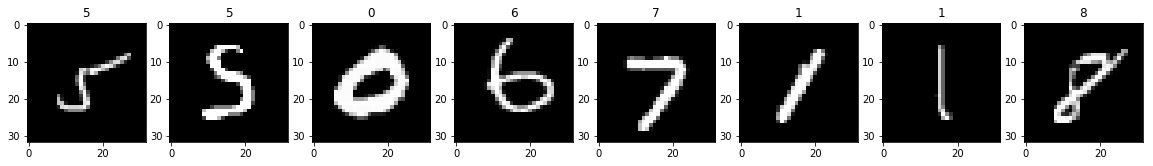

Epoch: 99, Iteration: 471776
Loss: 0.0201, Accuracy: 100.00%


In [65]:
train(model)

Preds: [9 1 7 7 3 5 1 9]


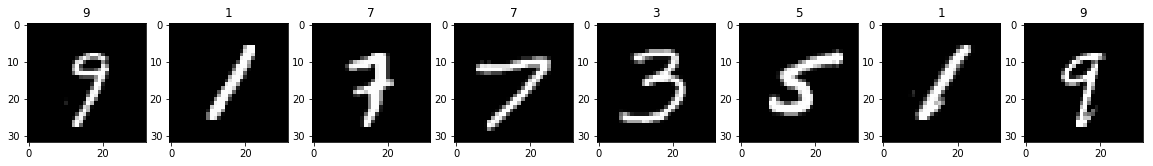

(0.1438211131550665, 0.975)

In [53]:
validate_model(model, dataloader_val, loss, n_iters=500)